# 0 - Import des données brutes

**Warning**

A l'importation, on nous prévient que les colonnes : (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) contiennent des données de type mixtes. 

Dans le code ci dessous, on voit comment importer les colonnes en spécifiant le type de données voulues. 

Il faudra y revenir

In [157]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




df = pd.read_csv('DataSet/fr.openfoodfacts.org.products.csv', sep='\t')


/tmp/ipykernel_24391/865034402.py:18: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('DataSet/fr.openfoodfacts.org.products.csv', sep='\t')


# 1 - Nettoyage et filtrage du Dataset

**Objectifs :**

 - Identification de la cible
 - Mise en place d'un processus clair et automatisé pour filtrer les features (variables/colonnes) et des produits (lignes) qui seront utilisés pour atteindre l'objectif


## Listage de l'ensemble des features du fichiers et séparation entre quantitatives et qualitatives

In [158]:
colonnes = df.columns.to_list()

# Obtenir les types de données de chaque colonne
types_de_donnees = df.dtypes

# Créer des listes pour stocker les noms des colonnes quantitatives et qualitatives
features_quantitatives = []
features_qualitatives = []

# Parcourir les colonnes et les types de données
for colonne, dtype in types_de_donnees.items():
    if dtype == 'object':
        # Si le type de données est un objet, il est probablement qualitatif
        features_qualitatives.append(colonne)
    else:
        # Sinon, il est probablement quantitatif
        features_quantitatives.append(colonne)

# Afficher les résultats
print("Features quantitatives :", features_quantitatives)
print("Features qualitatives :", features_qualitatives)

Features quantitatives : ['no_nutriments', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'elaidic-acid_100g', 'gondoic-acid_100g', 'mead-acid_100g', 'eruci

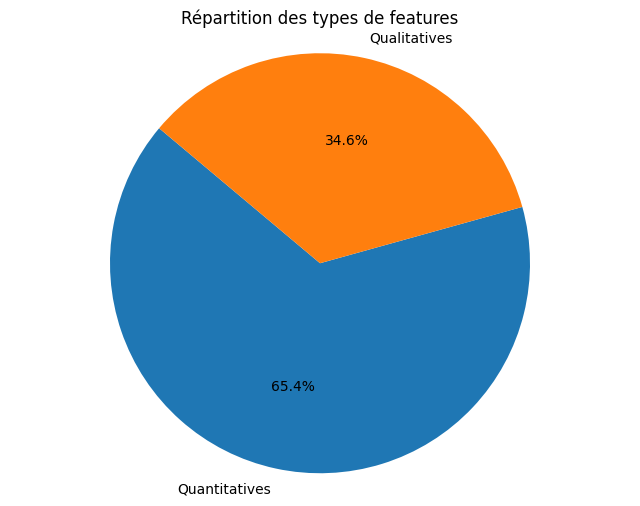

In [159]:
# Compter le nombre de features quantitatives et qualitatives
nb_quantitatives = len(features_quantitatives)
nb_qualitatives = len(features_qualitatives)

# Créer une liste pour contenir le nombre de features de chaque type
nb_features = [nb_quantitatives, nb_qualitatives]

# Étiquettes pour les parts du camembert
etiquettes = ['Quantitatives', 'Qualitatives']

# Créer le camembert
plt.figure(figsize=(8, 6))
plt.pie(nb_features, labels=etiquettes, autopct='%1.1f%%', startangle=140)

# Titre du camembert
plt.title('Répartition des types de features')

# Afficher le camembert
plt.axis('equal') 
plt.show()


## Forme du dataframe

In [160]:
df.shape

(320772, 162)

Le dataframe contient 320 772 lignes et 162 colonnes

In [161]:
df.head(2)

code                                                url  \
0  3087  http://world-fr.openfoodfacts.org/produit/0000...   
1  4530  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  

[2 rows x 162 columns]

## Etude des intitulés de colonnes et du remplissage 

In [162]:
i = 0
for colonne in df.columns:
    missing_value = df[colonne].isna().sum() #compte du nombre de valeurs manquantes dans la colonne
    print(f"L'intitulé de la colonne {i} est le suivant : {colonne}, celle ci contient {missing_value} valeurs manquantes")
    i+=1


L'intitulé de la colonne 0 est le suivant : code, celle ci contient 23 valeurs manquantes
L'intitulé de la colonne 1 est le suivant : url, celle ci contient 23 valeurs manquantes
L'intitulé de la colonne 2 est le suivant : creator, celle ci contient 2 valeurs manquantes
L'intitulé de la colonne 3 est le suivant : created_t, celle ci contient 3 valeurs manquantes
L'intitulé de la colonne 4 est le suivant : created_datetime, celle ci contient 9 valeurs manquantes
L'intitulé de la colonne 5 est le suivant : last_modified_t, celle ci contient 0 valeurs manquantes
L'intitulé de la colonne 6 est le suivant : last_modified_datetime, celle ci contient 0 valeurs manquantes
L'intitulé de la colonne 7 est le suivant : product_name, celle ci contient 17762 valeurs manquantes
L'intitulé de la colonne 8 est le suivant : generic_name, celle ci contient 267977 valeurs manquantes
L'intitulé de la colonne 9 est le suivant : quantity, celle ci contient 215953 valeurs manquantes
L'intitulé de la colonne 1

In [163]:
# Analyse du contenu d'une colonne en particulier
df['serving_size'].unique()

array([nan, '28 g (1 ONZ)', '28 g (0.25 cup)', ..., '12.5 g (0.45 oz)',
       '22 g (3 PCS)', '25 g (bun)'], dtype=object)

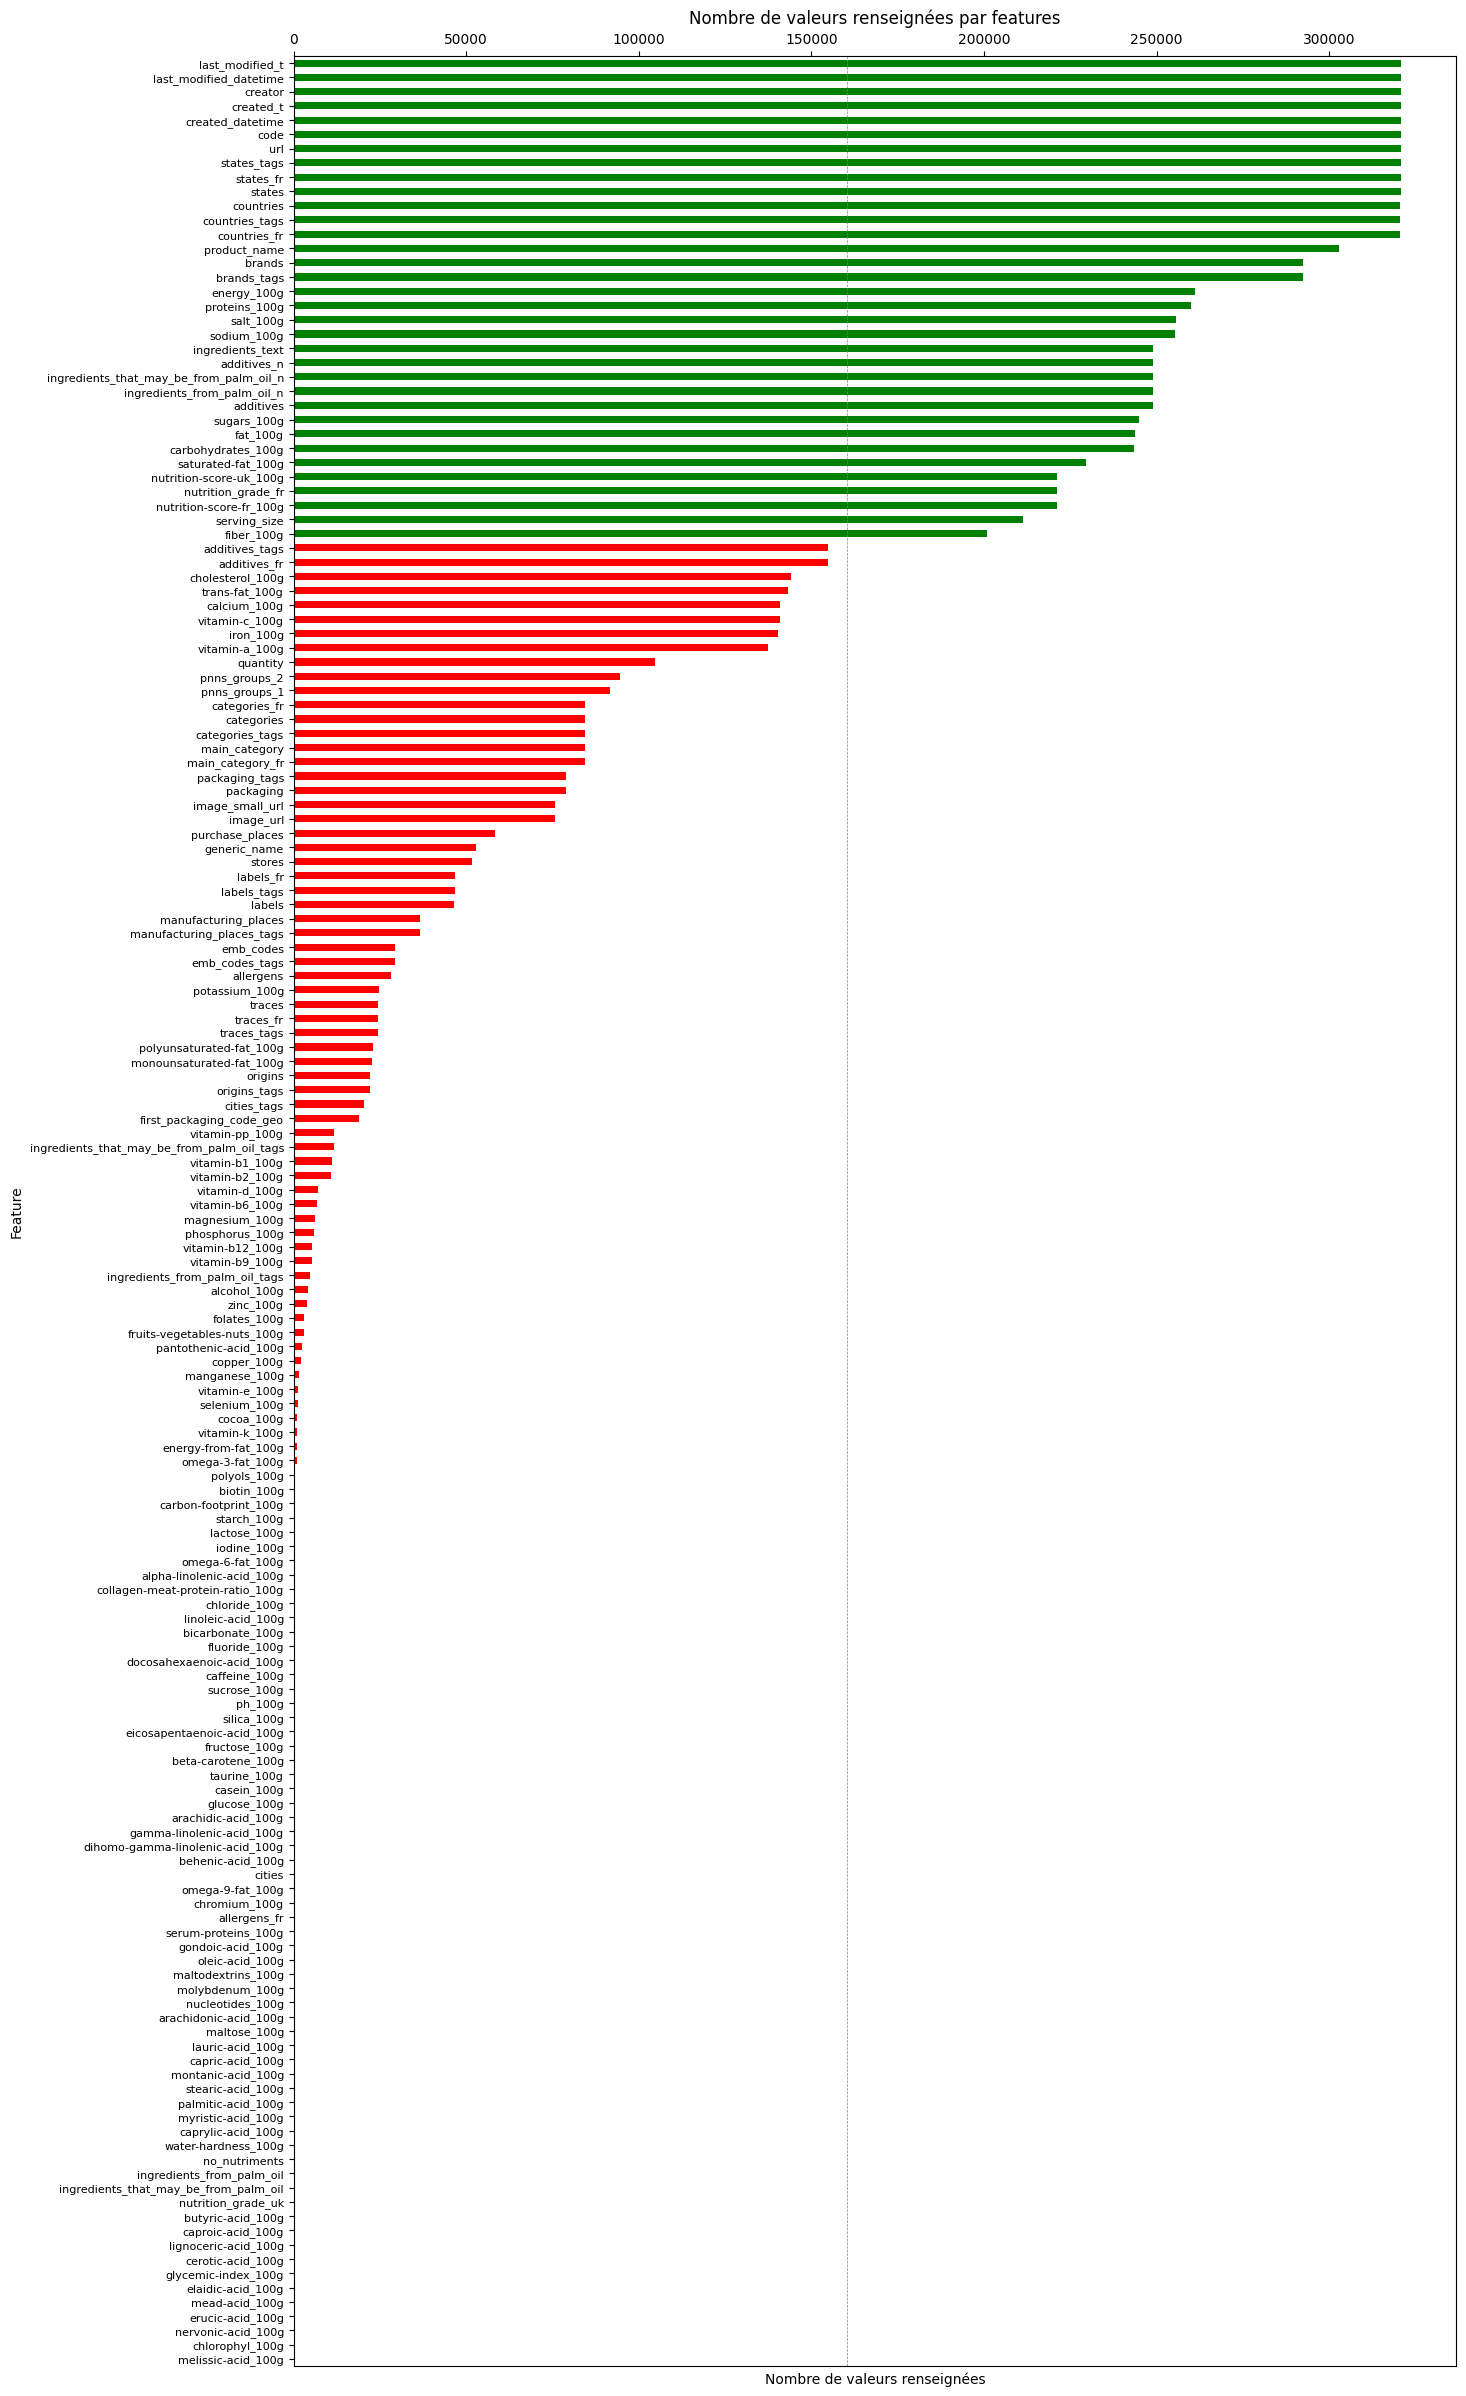

In [164]:
ma_serie = df.notna().sum(axis = 0).sort_values(ascending = True)

# Créer une liste de couleurs en fonction des valeurs de la série
couleurs = ['green' if valeur >= 0.5 * ma_serie.max() else 'red' for valeur in ma_serie]


# Créer un graphique à barres horizontales
plt.figure(figsize=(15, 30))
graphique = ma_serie.plot(kind='barh', color=couleurs) 

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre de valeurs renseignées')
plt.ylabel('Feature')
plt.title('Nombre de valeurs renseignées par features')

# Ajuster la taille du texte des labels sur l'axe des y
plt.yticks(fontsize=8)

# Placer les graduations de l'axe des abscisses en haut
graphique.xaxis.tick_top()

# Ajouter une barre verticale en pointillé gris à x = 50%
plt.axvline(ma_serie.max()/2, color='gray', linestyle='--', linewidth=0.5)

# Afficher le graphique
plt.show()

## Coup d'oeil rapide à certaines catégories

In [165]:
df['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

In [166]:
df['pnns_groups_2'].unique()

array([nan, 'unknown', 'Vegetables', 'Biscuits and cakes', 'Bread',
       'Legumes', 'Pizza pies and quiche', 'Meat', 'Sweets',
       'Non-sugared beverages', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'vegetables', 'Soups',
       'Chocolate products', 'Alcoholic beverages', 'Fruits', 'Sandwich',
       'Cereals', 'Milk and yogurt', 'Fats', 'Cheese', 'Appetizers',
       'Nuts', 'Breakfast cereals', 'Artificially sweetened beverages',
       'Fruit juices', 'Eggs', 'Fish and seafood', 'Dried fruits',
       'Ice cream', 'Processed meat', 'Potatoes', 'Dairy desserts',
       'Fruit nectars', 'pastries', 'Tripe dishes', 'fruits',
       'Salty and fatty products', 'cereals', 'legumes', 'nuts'],
      dtype=object)

In [167]:
df['main_category_fr'].value_counts()

main_category_fr
Boissons                                   6054
Epicerie                                   2902
Chocolats                                  2789
Aliments et boissons à base de végétaux    2745
Conserves                                  2519
                                           ... 
Anchoiade                                     1
Creme-de-riz                                  1
Creme-de-sarrasin                             1
en:Crackers-sans-gluten                       1
pl:Szprot                                     1
Name: count, Length: 3543, dtype: int64

In [168]:
df.loc[:, 'ingredients_text']

0                                                       NaN
1         Bananas, vegetable oil (coconut oil, corn oil ...
2         Peanuts, wheat flour, sugar, rice flour, tapio...
3         Organic hazelnuts, organic cashews, organic wa...
4                                           Organic polenta
                                ...                        
320767                                                  NaN
320768    Organic peppermint, organic lemon grass, organ...
320769                                                  NaN
320770                                                  NaN
320771    Citric acid, maltodextrin, instant tea, aspart...
Name: ingredients_text, Length: 320772, dtype: object

La colonne 'energy-kj_100g' n'existe pas dans le DataFrame.
La colonne 'energy-kcal_100g' n'existe pas dans le DataFrame.


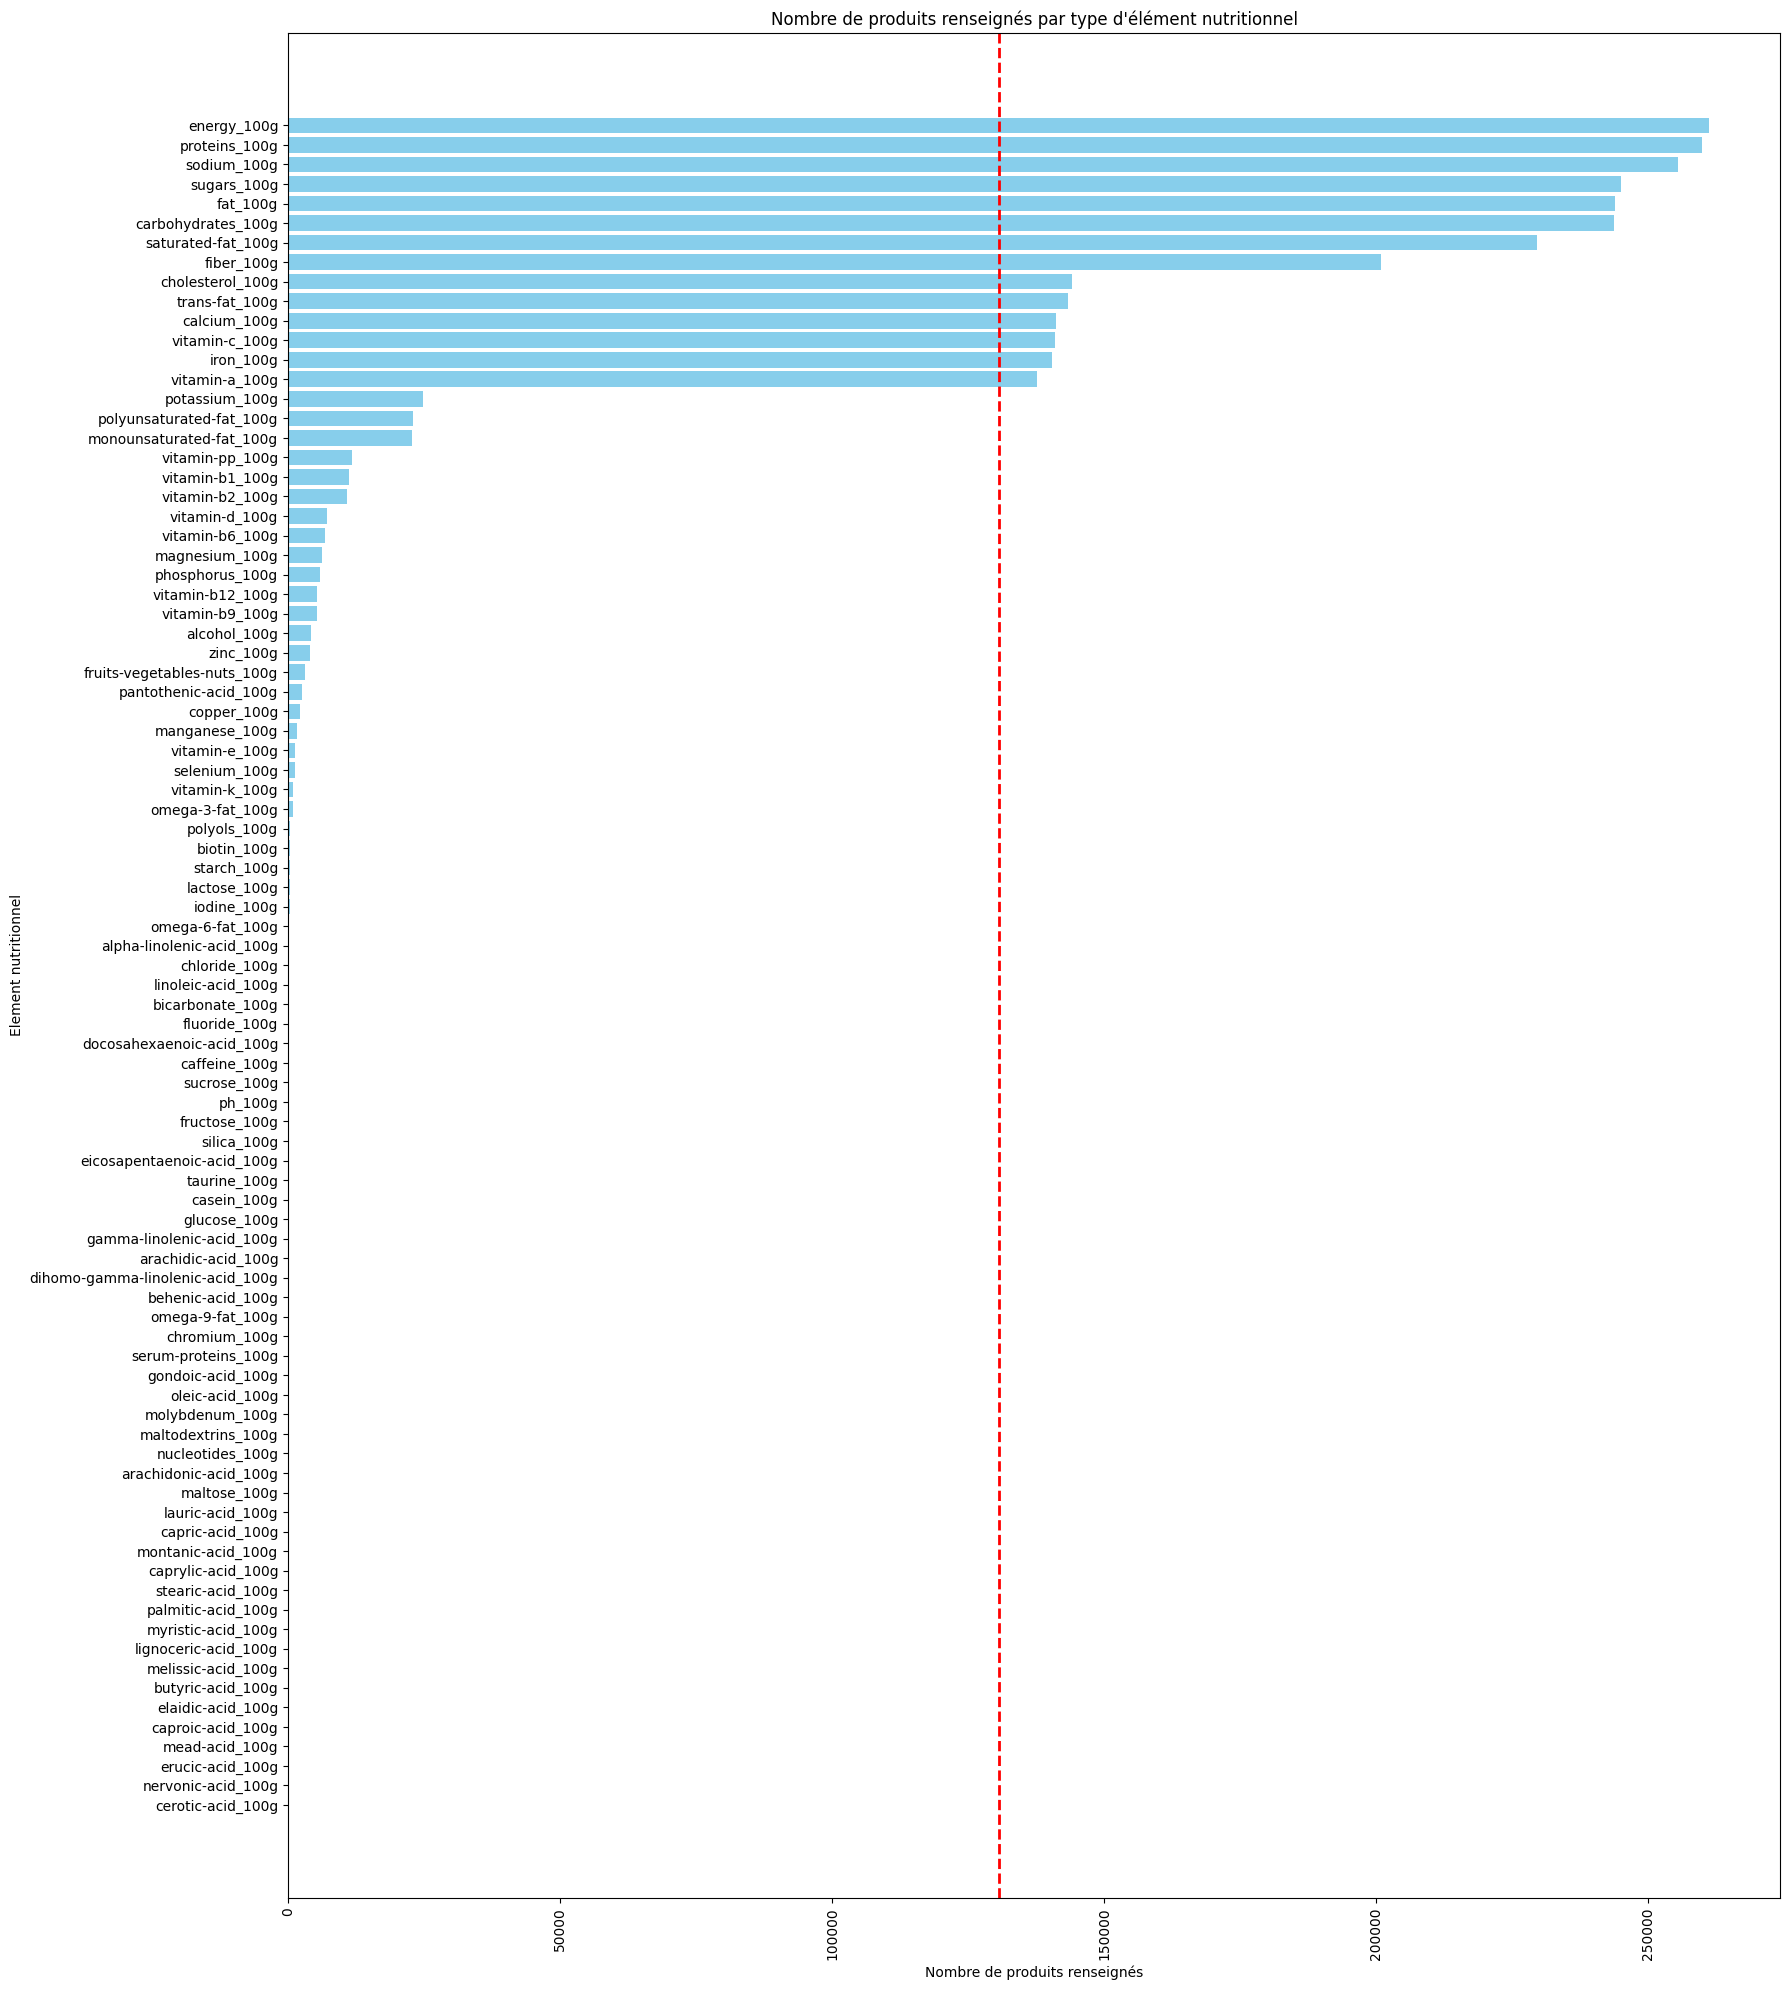

In [169]:
#Création d'une liste contenant les intitulés des colonnes concernant les informations nutritionnelles telles qu'évoquée dans la documentation (nécessitant une mise à jour)
nutrition = [
'energy_100g',
'energy-kj_100g',
'energy-kcal_100g',
'proteins_100g',
'casein_100g',
'serum-proteins_100g',
'nucleotides_100g',
'carbohydrates_100g',
'sugars_100g',
'sucrose_100g',
'glucose_100g',
'fructose_100g',
'lactose_100g',
'maltose_100g',
'maltodextrins_100g',
'starch_100g',
'polyols_100g',
'fat_100g',
'saturated-fat_100g',
'butyric-acid_100g',
'caproic-acid_100g',
'caprylic-acid_100g',
'capric-acid_100g',
'lauric-acid_100g',
'myristic-acid_100g',
'palmitic-acid_100g',
'stearic-acid_100g',
'arachidic-acid_100g',
'behenic-acid_100g',
'lignoceric-acid_100g',
'cerotic-acid_100g',
'montanic-acid_100g',
'melissic-acid_100g',
'monounsaturated-fat_100g',
'polyunsaturated-fat_100g',
'omega-3-fat_100g',
'alpha-linolenic-acid_100g',
'eicosapentaenoic-acid_100g',
'docosahexaenoic-acid_100g',
'omega-6-fat_100g',
'linoleic-acid_100g',
'arachidonic-acid_100g',
'gamma-linolenic-acid_100g',
'dihomo-gamma-linolenic-acid_100g',
'omega-9-fat_100g',
'oleic-acid_100g',
'elaidic-acid_100g',
'gondoic-acid_100g',
'mead-acid_100g',
'erucic-acid_100g',
'nervonic-acid_100g',
'trans-fat_100g',
'cholesterol_100g',
'fiber_100g',
'sodium_100g',
'alcohol_100g', #% vol of alcohol
'vitamin-a_100g',
'vitamin-d_100g',
'vitamin-e_100g',
'vitamin-k_100g',
'vitamin-c_100g',
'vitamin-b1_100g',
'vitamin-b2_100g',
'vitamin-pp_100g',
'vitamin-b6_100g',
'vitamin-b9_100g',
'vitamin-b12_100g',
'biotin_100g', #also known as Vitamine B8
'pantothenic-acid_100g', #also known as Vitamine B5
'silica_100g',
'bicarbonate_100g',
'potassium_100g',
'chloride_100g',
'calcium_100g',
'phosphorus_100g',
'iron_100g',
'magnesium_100g',
'zinc_100g',
'copper_100g',
'manganese_100g',
'fluoride_100g',
'selenium_100g',
'chromium_100g',
'molybdenum_100g',
'iodine_100g',
'caffeine_100g',
'taurine_100g',
'ph_100g', #pH (no unit)
'fruits-vegetables-nuts_100g',
]

#création d'un dictionnaire qui va accueillir les données présentes dans le Dataframe
nutrition_elements = {}

for colonne in nutrition:
    if colonne in df.columns:
        nutrition_elements[colonne] = df[colonne].value_counts().sum()
    else:
        print(f"La colonne '{colonne}' n'existe pas dans le DataFrame.")

#création d'un dataframe à partir du dictionnaire
df_nutri = pd.DataFrame(list(nutrition_elements.items()), columns=['colonne', 'total'])

#tri des valeurs dans le dataframe
df_nutri = df_nutri.sort_values(by='total', ascending = True)

#tracé de la figure
plt.figure(figsize=(18, 20))
plt.barh(df_nutri['colonne'], df_nutri['total'], color='skyblue')
plt.xlabel('Nombre de produits renseignés')
plt.ylabel('Element nutritionnel')
plt.title("Nombre de produits renseignés par type d'élément nutritionnel")
plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe x pour plus de lisibilité
plt.tight_layout()  # Ajustement automatique des marges pour éviter la coupure des étiquettes

valeur_50pc = df_nutri['total'].max() * 0.5
plt.axvline(x=valeur_50pc, color='red', linestyle='--', linewidth=2, label='50%')

plt.show()

## Etude des lignes



In [170]:
#étude du nombre de valeurs manquantes par ligne
df.notna().sum(axis = 1).describe()

count    320772.000000
mean         38.521052
std          11.618040
min          10.000000
25%          31.000000
50%          41.000000
75%          44.000000
max          92.000000
dtype: float64

Chaque individu renseigne en moyenne à propos de 38 features

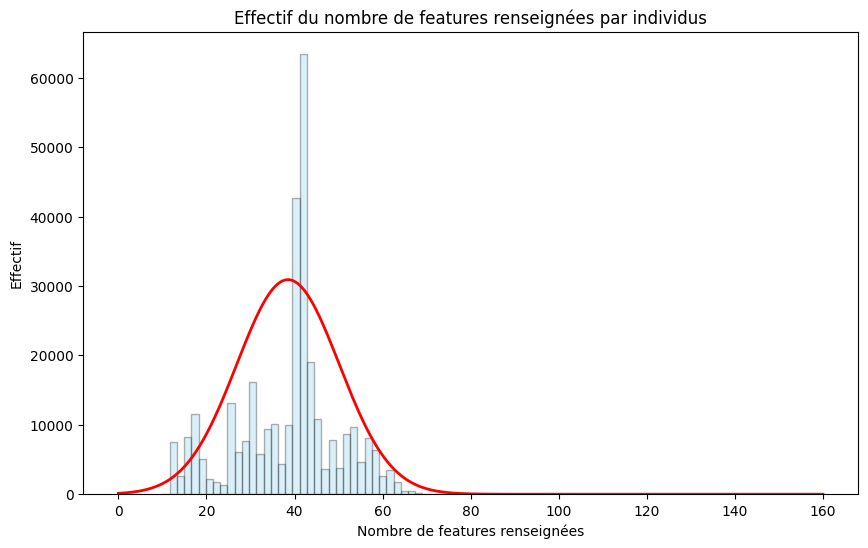

In [171]:
serie = df.notna().sum(axis = 1)

from scipy.stats import norm

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(serie, bins=50, color='skyblue', edgecolor='black', alpha=0.3)

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre de features renseignées')
plt.ylabel('Effectif')
plt.title('Effectif du nombre de features renseignées par individus')

# Estimer les paramètres de la distribution normale (moyenne et écart-type)
mu, sigma = serie.describe()['mean'], serie.describe()['std']

# Créer une plage de valeurs pour la courbe de Gauss
x = np.linspace(0, 160,1000)

# Calculer les valeurs de la courbe de Gauss
y = norm.pdf(x, mu, sigma)*900000

# Tracer la courbe de Gauss
plt.plot(x, y, 'r-', linewidth=2, label='Courbe de Gauss')

# Afficher le graphique
plt.show()

In [172]:
serie.describe()

count    320772.000000
mean         38.521052
std          11.618040
min          10.000000
25%          31.000000
50%          41.000000
75%          44.000000
max          92.000000
dtype: float64

## Etude du type de données présentes dans la colonne code

In [173]:
serie = []
for code in df['code'].unique():
    serie.append(code)

types = []
for element in serie:
    types.append(type(element))

val_types = set(types)
val_types

{'3351700061639',
 '52745728862',
 '3073780580830',
 '86854060322',
 '6253506180996',
 '760232901062',
 '11213162201',
 '598491',
 '70200550124',
 '4100590153400',
 '3350030162382',
 '741643452121',
 '01110869630',
 '6281022118230',
 '4902156025189',
 '3046920074001',
 '3263855096353',
 '885616003856',
 '26031330',
 '41224704848',
 '818401000686',
 '71899321019',
 '853299003609',
 '725439984539',
 '5000169122938',
 '3580280775340',
 '12511946067',
 '36632008527',
 '3288110162338',
 '7610800969921',
 '641497153826',
 '3240931536835',
 '3263852950917',
 '851770005012',
 '780993543219',
 '15984610251',
 '3252950047308',
 '3523230026888',
 '8001344023887',
 '85239906293',
 '780994812437',
 '4311501311721',
 '50336911150',
 '705105686370',
 '639460403535',
 '74270006734',
 '76310440119',
 '9003100123021',
 '52100889511',
 '3230890016806',
 '23637469163',
 '855109006053',
 '38900040000',
 '75450134858',
 '5420005740070',
 '74175003043',
 '708820951594',
 '5707196139709',
 '4020500964202',
 '

On voit que la colonne code contient des valeurs de types float, int et str

Comptons le nombre de valeurs de chaque type dans la colonne

In [174]:
val_float = 0
val_int = 0
val_str = 0

for type in types:
    if str(type) == "<class 'int'>":
        val_int+=1
    elif str(type) == "<class 'float'>":
        val_float+=1
    elif str(type) == "<class 'str'>": 
        val_str+=1

print(f"Il y a dans la colonne code \n {val_float} valeurs de type float \n {val_int} de type int \n et {val_str} valeurs de type str")

Il y a dans la colonne code 
 0 valeurs de type float 
 0 de type int 
 et 0 valeurs de type str


## Recherche des colonnes contenant plus de 50% de valeurs manquantes

In [175]:
i = 0
for colonne in df.columns:
    i+=1
    perc_missing = round(df[colonne].isna().sum()/df.shape[0]*100)
    if 50 <= perc_missing  : 
        print(f"La colonne de rang {i} intitulée {colonne}, contient \n {perc_missing} % de valeurs manquantes")

La colonne de rang 9 intitulée generic_name, contient 
 84 % de valeurs manquantes
La colonne de rang 10 intitulée quantity, contient 
 67 % de valeurs manquantes
La colonne de rang 11 intitulée packaging, contient 
 75 % de valeurs manquantes
La colonne de rang 12 intitulée packaging_tags, contient 
 75 % de valeurs manquantes
La colonne de rang 15 intitulée categories, contient 
 74 % de valeurs manquantes
La colonne de rang 16 intitulée categories_tags, contient 
 74 % de valeurs manquantes
La colonne de rang 17 intitulée categories_fr, contient 
 74 % de valeurs manquantes
La colonne de rang 18 intitulée origins, contient 
 93 % de valeurs manquantes
La colonne de rang 19 intitulée origins_tags, contient 
 93 % de valeurs manquantes
La colonne de rang 20 intitulée manufacturing_places, contient 
 89 % de valeurs manquantes
La colonne de rang 21 intitulée manufacturing_places_tags, contient 
 89 % de valeurs manquantes
La colonne de rang 22 intitulée labels, contient 
 85 % de valeu

## Analyse succinte de 8 features qualitatives : 

 - labels
 - categories
 - generic_name
 - packaging
 - pnns_groups_1
 - pnns_groups_2
 - main_category
 - main_category_fr

### Labels

In [176]:
#analyse curieuse des valeurs présentes dans la colonne labels
labels = df['labels'].value_counts()
print(f"Il y a {len(labels)} modalités différentes dans la colonne labels")
labels.head(50)

Il y a 18114 modalités différentes dans la colonne labels


labels
Organic, EU Organic, fr:AB Agriculture Biologique                        3223
Point Vert                                                               2053
Vegetariano,Vegano                                                       1048
Bio,Bio européen,AB Agriculture Biologique                                979
Point Vert,Eco-Emballages                                                 609
AB,Bio européen                                                           459
AOP                                                                       405
Produit en Bretagne                                                       392
Bio,Bio européen,FR-BIO-01,AB Agriculture Biologique                      320
IGP                                                                       267
Sélection Intermarché                                                     259
Sans gluten                                                               259
Grüner Punkt                                             

### Generic name

In [177]:
#analyse curieuse des valeurs présentes dans la colonne generic_names
generic_name = df['generic_name'].value_counts()
print(f"Il y a {len(generic_name)} modalités différentes dans la colonne generic_name")
generic_name.head(50)

Il y a 38584 modalités différentes dans la colonne generic_name


generic_name
Pâtes alimentaires au blé dur de qualité supérieure                                         201
Aliment pour bébés                                                                           92
Pâtes alimentaires de qualité supérieure                                                     82
Jambon cuit supérieur                                                                        80
Jus d'orange                                                                                 73
Fromage industriel de France, à pâte molle à croûte fleurie, au lait pasteurisé de vache     69
Plat préparé en conserve                                                                     68
Natürliches Mineralwasser mit Kohlensäure versetzt                                           65
Lait demi-écrémé stérilisé UHT                                                               59
Chocolat noir                                                                                58
Bière blonde               

### Packaging

In [178]:
#analyse curieuse des valeurs présentes dans la colonne emballages
emballages = df['packaging'].value_counts()
print(f"Il y a {len(emballages)} modalités différentes dans la colonne emballages")
emballages.head(50)

Il y a 14547 modalités différentes dans la colonne emballages


packaging
Carton                                                                           2153
Sachet,Plastique                                                                 2141
Plastique                                                                        1902
Bouteille,Verre                                                                  1342
Kunststoff                                                                       1331
Conserve                                                                         1282
sachet,plastique                                                                 1116
Bocal,Verre                                                                      1107
Bouteille,Plastique                                                              1032
barquette,plastique                                                               926
plastique                                                                         888
Plastic                                     

### Categories

In [179]:
#analyse curieuse des valeurs présentes dans la colonne categories
categories = df['categories'].value_counts()
print(f"Il y a {len(categories)} modalités différentes dans la colonne categories")
categories.head(50)

Il y a 36982 modalités différentes dans la colonne categories


categories
Snacks sucrés,Biscuits et gâteaux,Biscuits                                                                                                                                                                                              301
Biscuits                                                                                                                                                                                                                                287
Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat                                                                                                                                                                         247
Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner                                                                        222
Bonbons                                      

### Pnns groups 1 & 2

In [180]:
#analyse curieuse des valeurs présentes dans la colonne pnns_groups_1
pnns1 = df['pnns_groups_1'].value_counts()
print(f"Il y a {len(pnns1)} modalités différentes dans la colonne pnns_groups_1")
pnns1.head(50)

Il y a 14 modalités différentes dans la colonne pnns_groups_1


pnns_groups_1
unknown                    22624
Sugary snacks              12368
Beverages                   9033
Milk and dairy products     8825
Cereals and potatoes        8442
Fish Meat Eggs              8041
Composite foods             6747
Fruits and vegetables       5908
Fat and sauces              5216
Salty snacks                2809
fruits-and-vegetables        987
sugary-snacks                496
cereals-and-potatoes          16
salty-snacks                   1
Name: count, dtype: int64

In [181]:
#analyse curieuse des valeurs présentes dans la colonne pnns_groups_2
pnns2 = df['pnns_groups_2'].value_counts()
print(f"Il y a {len(pnns2)} modalités différentes dans la colonne pnns_groups_1")
pnns2.head(50)

Il y a 42 modalités différentes dans la colonne pnns_groups_1


pnns_groups_2
unknown                             22624
One-dish meals                       5546
Sweets                               4698
Biscuits and cakes                   4561
Non-sugared beverages                4302
Cereals                              4106
Cheese                               4024
Dressings and sauces                 3602
Milk and yogurt                      3297
Processed meat                       3247
Chocolate products                   3109
Alcoholic beverages                  2909
Vegetables                           2840
Fish and seafood                     2638
Sweetened beverages                  2170
Appetizers                           2101
Fruits                               2068
Fruit juices                         1924
Bread                                1838
Meat                                 1694
Fats                                 1614
Breakfast cereals                    1408
vegetables                            934
Legumes             

### Main category

In [182]:
#analyse curieuse des valeurs présentes dans la colonne main_category
main_cat = df['main_category'].value_counts()
print(f"Il y a {len(main_cat)} modalités différentes dans la colonne main_category")
main_cat.head(50)

Il y a 3543 modalités différentes dans la colonne main_category


main_category
en:beverages                          6054
en:groceries                          2902
en:chocolates                         2789
en:plant-based-foods-and-beverages    2745
en:canned-foods                       2519
en:biscuits                           2097
en:meals                              2079
en:sugary-snacks                      1946
en:frozen-foods                       1889
en:breakfasts                         1793
en:cheeses                            1785
en:breads                             1771
en:desserts                           1684
en:pastas                             1529
en:meals-with-meat                    1319
en:cakes                              1266
en:chips-and-fries                    1222
en:salted-spreads                     1181
en:candies                            1113
en:fresh-vegetables                   1089
en:milks                              1079
en:yogurts                            1015
en:soups                              10

### Main category fr

In [183]:
#analyse curieuse des valeurs présentes dans la colonne main_category_fr
main_cat_fr = df['main_category_fr'].value_counts()
print(f"Il y a {len(main_cat_fr)} modalités différentes dans la colonne main_category_fr")
main_cat_fr.head(50)

Il y a 3543 modalités différentes dans la colonne main_category_fr


main_category_fr
Boissons                                   6054
Epicerie                                   2902
Chocolats                                  2789
Aliments et boissons à base de végétaux    2745
Conserves                                  2519
Biscuits                                   2097
Plats préparés                             2079
Snacks sucrés                              1946
Surgelés                                   1889
Petit-déjeuners                            1793
Fromages                                   1785
Pains                                      1771
Desserts                                   1684
Pâtes alimentaires                         1529
Plats à base de viande                     1319
Gâteaux                                    1266
Chips et frites                            1222
Produits à tartiner salés                  1181
Bonbons                                    1113
Légumes frais                              1089
Laits                  

## Etude Nutriscore

Le calcul du nutriscore est basé sur plusieurs critères

 - La catégorie du produit (colonnes)
 - La présence d'un composant et sa quantité (lignes)

|                                                          | Cas général | Viande rouge | Fromage | Mat grasse,fr à coque,graines | Boissons |
|----------------------------------------------------------|:-----------:|:------------:|:-------:|:-----------------------------:|:--------:|
| Energie (kJ/100g)                                        |     -1      |      -1      |   -1    |              -1               |    -1    |
| Sucres (g/100 g)                                         |     -1      |      -1      |   -1    |              -1               |    -1    |
| Acides gras saturés (g/100 g)                            |     -1      |      -1      |   -1    |              -1               |    -1    |
| Sel (g/100 g)                                            |     -1      |      -1      |   -1    |              -1               |    -1    |
| Présence d'édulcorant non-nutritif (OUI/NON)             |      0      |       0      |    0    |               0               |    -1    |
| Fruits, légumes et légumes secs (%)                      |     +1      |      +1      |   +1    |               0               |    +1    |
| Fibres (g/100 g)                                         |     +1      |      +1      |   +1    |              +1               |    +1    |
| Protéines (g/100 g)                                      |     +1      |      +1      |   +1    |              +1               |    +1    |
| Huiles dérivées des fruits, légumes and légumes secs (%) |      0      |       0      |    0    |              +1               |     0    |
| Eau (sans aucune addition)                               |      0      |       0      |    0    |               0               |    +1    |
| Matière grasse (g/100 g)                                 |      0      |       0      |    0    |              -1               |     0    |

*légende*

- +1 indique que le composant est pris en compte positivement dans le calcul du nutriscore
- 0 indique que le composant n'est pas pris en compte dans le calcul du nutriscore
- -1 indique que le composant est pris en compte négativement dans le calcul du nutriscore

**colonnes du dataframe**

Il semble que des colonnes correspondent assez spécifiquement aux composants rentrant en compte dans le calcul du nutriscore

---

**infos générales sur le nutriscore** : https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score

**mode de calcul du nutriscore** : https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/outil-de-calcul-du-nutri-score-algorithme-actualise

*Notons que le mode de calcul du nutriscore a été mis à jour récemment (au 31 Décembre 2023)*

---



In [184]:
#liste des colonnes intéressantes

colonnes_interessantes = [
    
    # valeurs qualitatives
    
    'product_name', #name of the product
    'generic_name',
    'packaging', #shape, material
    'brands', 
    'categories', 
    'labels', 
    'nutrition_grade_fr', #nutrition grade ('a' to 'e'). see https://fr.openfoodfacts.org/nutriscore
    'nutrition-score-fr_100g', #idem ci-dessus mais donnée numérique
    'pnns_groups_1', 
    'pnns_groups_2', 
    'main_category', 
    'main_category_fr',
    # valeurs quantitatives
    
    'energy_100g', 
#    'energy-kj_100g', colonne inexistante
#    'energy-kcal_100g', colonne inexistante
    'fat_100g', 
    'saturated-fat_100g', 
    'carbohydrates_100g', 
    'sugars_100g', 
    'fiber_100g', 
    'proteins_100g', 
    'salt_100g', 
    'fruits-vegetables-nuts_100g', #% of fruits, vegetables and nuts (excluding potatoes, yams, manioc)
    'sodium_100g', 
    'cholesterol_100g', 
    'trans-fat_100g', 
    'calcium_100g',
    'vitamin-c_100g',
    'iron_100g',
    'vitamin-a_100g',
]

#création d'un nouveau df contenant ces colonnes intéressantes 
df_col_int = df[colonnes_interessantes]

df_col_int.describe(include = 'all')

product_name                                       generic_name  \
count        303010                                              52795   
unique       221347                                              38584   
top       Ice Cream  Pâtes alimentaires au blé dur de qualité supér...   
freq            410                                                201   
mean            NaN                                                NaN   
std             NaN                                                NaN   
min             NaN                                                NaN   
25%             NaN                                                NaN   
50%             NaN                                                NaN   
75%             NaN                                                NaN   
max             NaN                                                NaN   

       packaging     brands                                  categories  \
count      78960     292360                                       84410   
unique     14547      58784                                       36982   
top       Carton  Carrefour  Snacks sucrés,Biscuits et gâteaux,Biscuits   
freq        2153       2978                                         301   
mean         NaN        NaN                                         NaN   
std          NaN        NaN                                         NaN   
min          NaN        NaN                                         NaN   
25%          NaN        NaN                                         NaN   
50%          NaN        NaN                                         NaN   
75%          NaN        NaN                                         NaN   
max          NaN        NaN                                         NaN   

                                                   labels nutrition_grade_fr  \
count                                               46559             221210   
unique                                              18114                  5   
top     Organic, EU Organic, fr:AB Agriculture Biologique                  d   
freq                                                 3223              62763   
mean                                                  NaN                NaN   
std                                                   NaN                NaN   
min                                                   NaN                NaN   
25%                                                   NaN                NaN   
50%                                                   NaN                NaN   
75%                                                   NaN                NaN   
max                                                   NaN                NaN   

        nutrition-score-fr_100g pnns_groups_1 pnns_groups_2  ...  \
count             221210.000000         91513         94491  ...   
unique                      NaN            14            42  ...   
top                         NaN       unknown       unknown  ...   
freq                        NaN         22624         22624  ...   
mean                   9.165535           NaN           NaN  ...   
std                    9.055903           NaN           NaN  ...   
min                  -15.000000           NaN           NaN  ...   
25%                    1.000000           NaN           NaN  ...   
50%                   10.000000           NaN           NaN  ...   
75%                   16.000000           NaN           NaN  ...   
max                   40.000000           NaN           NaN  ...   

        proteins_100g      salt_100g  fruits-vegetables-nuts_100g  \
count   259922.000000  255510.000000                  3036.000000   
unique            NaN            NaN                          NaN   
top               NaN            NaN                          NaN   
freq              NaN            NaN                          NaN   
mean         7.075940       2.028624                    31.458587   
std          8.409054    

In [185]:
#calcul du pourcentage de valeurs manquantes par variable

tableau = round(df_col_int.isna().sum()/df_col_int.shape[0]*100, 1)

for titre, missing_value in tableau.items():
    print(f"La colonne \033[1m{titre}\033[0m contient \033[1m{missing_value}%\033[0m de valeurs manquantes")

La colonne product_name contient 5.5% de valeurs manquantes
La colonne generic_name contient 83.5% de valeurs manquantes
La colonne packaging contient 75.4% de valeurs manquantes
La colonne brands contient 8.9% de valeurs manquantes
La colonne categories contient 73.7% de valeurs manquantes
La colonne labels contient 85.5% de valeurs manquantes
La colonne nutrition_grade_fr contient 31.0% de valeurs manquantes
La colonne nutrition-score-fr_100g contient 31.0% de valeurs manquantes
La colonne pnns_groups_1 contient 71.5% de valeurs manquantes
La colonne pnns_groups_2 contient 70.5% de valeurs manquantes
La colonne main_category contient 73.7% de valeurs manquantes
La colonne main_category_fr contient 73.7% de valeurs manquantes
La colonne energy_100g contient 18.6% de valeurs manquantes
La colonne fat_100g contient 24.0% de valeurs manquantes
La colonne saturated-fat_100g contient 28.4% de valeurs manquantes
La colonne carbohydrates_100g contient 24.1% de valeurs manquantes
La colonne s

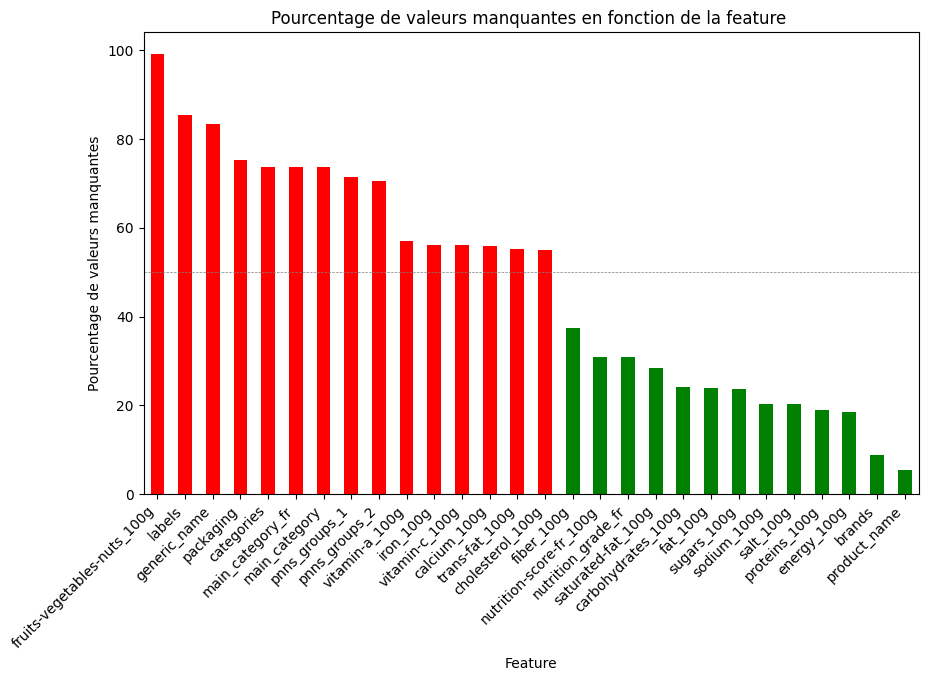

In [186]:
ma_serie = tableau.sort_values(ascending = False)

# Définir les couleurs en fonction des valeurs de la série
couleurs = ['red' if valeur >= 50 else 'green' for valeur in ma_serie]


# Créer un graphique à barres
plt.figure(figsize=(10, 6))
ma_serie.plot(kind='bar', color = couleurs)


# Ajouter des étiquettes et un titre
plt.xlabel('Feature')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes en fonction de la feature ')

plt.axhline(y=50, color='gray', linestyle='--', linewidth=0.5)

# Incliner le texte des labels sur l'axe des x
plt.xticks(rotation=45, ha='right') 

# Affichez le graphique
plt.show()

## Choix de la cible

Il y a 8 features potentielles (moins de 50% des valeurs présentes)
 - fruits-vegetables-nuts_100g
 - labels
 - generic_name
 - packaging
 - categories
 - pnns_groups_1
 - pnns_groups_2
 - main_category
 - main_category_fr

Nous privilégierons une cible catégorielle, et éliminerons ainsi fruits-vegetables-nuts_100g

On rappelle le nombre arrondi au millier de modalités différentes par feature ci dessous : 

 - packaging : 14k
 - labels : 18k
 - categories : 37k
 - generic_name : 38k
 - pnns_groups_1 : 14
 - pnns_groups_2 : 42
 - main_category : 3k
 - main_category_fr : 3k

Les feature pnns_groups_1 et pnns_groups_2 sont croisées

Le choix à priori se porte sur la catégorie **pnns_groups_1**

En effet, celle ci possède les caractéristiques suivantes : 

 - un nombre réduit de modalités de valeurs
 - un taux de remplissage inférieur à 50%
 - variable de type qualitatif

## Recherche des individus sans valeurs nutritionnelles renseignées

In [187]:
# Créer une liste des colonnes à considérer pour le calcul du nombre de valeurs renseignées
colonnes_a_considerer = ['pnns_groups_1', 'nutrition_grade_fr', 'energy_100g', 'proteins_100g',
                         'salt_100g', 'sodium_100g', 'sugars_100g', 'carbohydrates_100g',
                         'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition-score-fr_100g']

# Ajouter une nouvelle colonne 'nb_valeurs' contenant le nombre de valeurs renseignées dans les colonnes spécifiées
df['nb_valeurs'] = df[colonnes_a_considerer].count(axis=1)

df[df['nb_valeurs']==0]

code                                                url  \
0                3087  http://world-fr.openfoodfacts.org/produit/0000...   
48              27205  http://world-fr.openfoodfacts.org/produit/0000...   
178           1471762  http://world-fr.openfoodfacts.org/produit/0000...   
179           1798180  http://world-fr.openfoodfacts.org/produit/0000...   
193          13000004  http://world-fr.openfoodfacts.org/produit/0000...   
...               ...                                                ...   
320760       99044169  http://world-fr.openfoodfacts.org/produit/9904...   
320761  9906410000009  http://world-fr.openfoodfacts.org/produit/9906...   
320764           9918  http://world-fr.openfoodfacts.org/produit/9918...   
320767  9948282780603  http://world-fr.openfoodfacts.org/produit/9948...   
320770  9980282863788  http://world-fr.openfoodfacts.org/produit/9980...   

                           creator   created_t      created_datetime  \
0       openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
48                         tacinte  1458238630  2016-03-17T18:17:10Z   
178                canieatthis-app  1470247218  2016-08-03T18:00:18Z   
179                canieatthis-app  1468171601  2016-07-10T17:26:41Z   
193     openfoodfacts-contributors  1484431999  2017-01-14T22:13:19Z   
...                            ...         ...                   ...   
320760             date-limite-app  1421873458  2015-01-21T20:50:58Z   
320761                  agamitsudo  1373480408  2013-07-10T18:20:08Z   
320764                  woshilapin  1430167954  2015-04-27T20:52:34Z   
320767  openfoodfacts-contributors  1490631299  2017-03-27T16:14:59Z   
320770  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   

       last_modified_t last_modified_datetime                product_name  \
0           1474103893   2016-09-17T09:18:13Z          Farine de blé noir   
48          1458238638   2016-03-17T18:17:18Z                         NaN   
178         1470247218   2016-08-03T18:00:18Z        still Scottish water   
179         1468171601   2016-07-10T17:26:41Z   Fairtrade Ground Cinnamon   
193         1484432028   2017-01-14T22:13:48Z                   Kochspeck   
...                ...                    ...                         ...   
320760      1460898286   2016-04-17T13:04:46Z                    Poireaux   
320761      1451851215   2016-01-03T20:00:15Z   Roussette du Bugey (2011)   
320764      1430167992   2015-04-27T20:53:12Z  Cheese cake thé vert, yuzu   
320767      1491244498   2017-04-03T18:34:58Z           Tomato & ricotta    
320770      1492340089   2017-04-16T10:54:49Z    Tomates aux Vermicelles    

               generic_name quantity  ... fruits-vegetables-nuts_100g  \
0                       NaN      1kg  ...                         NaN   
48                      NaN      NaN  ...                         NaN   
178                     NaN      NaN  ...                         NaN   
179                     NaN      45g  ...                         NaN   
193                     NaN    686 g  ...                         NaN   
...                     ...      ...  ...                         ...   
320760                  NaN     1 kg  ...                         NaN   
320761  Vins blanc du Bugey   750 ml  ...                         NaN   
320764                  NaN      NaN  ...                         NaN   
320767                  NaN        1  ...                         NaN   
320770                  NaN      67g  ...                         NaN   

       collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                                   NaN        NaN             NaN   
48                                  NaN        NaN             NaN   
178                                 NaN        NaN             NaN   
179                                 NaN        NaN             NaN   
193                                 NaN        NaN             NaN   
...              

Il y a 35000 individus qui n'ont aucune valeurs renseignées, nous penserons à les supprimer dans la fonction de traitement

## Recherche et traitement des individus sans 'product_name'

In [188]:
# Sélectionner les individus sans valeurs dans la colonne 'product_name'
individus_sans_product_name = df[df['product_name'].isnull()]

# Afficher les individus sans valeur dans la colonne 'product_name'
print("Individus sans valeur dans la colonne 'product_name':")
individus_sans_product_name

Individus sans valeur dans la colonne 'product_name':


code                                                url  \
48            27205  http://world-fr.openfoodfacts.org/produit/0000...   
183         7020254  http://world-fr.openfoodfacts.org/produit/0000...   
187         9336247  http://world-fr.openfoodfacts.org/produit/0000...   
227        50157846  http://world-fr.openfoodfacts.org/produit/0000...   
233        69105241  http://world-fr.openfoodfacts.org/produit/0000...   
...             ...                                                ...   
320747   9800895250  http://world-fr.openfoodfacts.org/produit/9800...   
320748      9802735  http://world-fr.openfoodfacts.org/produit/9802735   
320752  98709870987  http://world-fr.openfoodfacts.org/produit/9870...   
320755       988639   http://world-fr.openfoodfacts.org/produit/988639   
320766     99410148  http://world-fr.openfoodfacts.org/produit/9941...   

                           creator   created_t      created_datetime  \
48                         tacinte  1458238630  2016-03-17T18:17:10Z   
183                       teolemon  1420150193  2015-01-01T22:09:53Z   
187                         tacite  1479029877  2016-11-13T09:37:57Z   
227                       teolemon  1482847730  2016-12-27T14:08:50Z   
233                date-limite-app  1466933518  2016-06-26T09:31:58Z   
...                            ...         ...                   ...   
320747          tacite-mass-editor  1490554697  2017-03-26T18:58:17Z   
320748             date-limite-app  1472728165  2016-09-01T11:09:25Z   
320752  openfoodfacts-contributors  1472254210  2016-08-26T23:30:10Z   
320755          tacite-mass-editor  1490554698  2017-03-26T18:58:18Z   
320766             date-limite-app  1463936572  2016-05-22T17:02:52Z   

       last_modified_t last_modified_datetime product_name  \
48          1458238638   2016-03-17T18:17:18Z          NaN   
183         1420210373   2015-01-02T14:52:53Z          NaN   
187         1479030010   2016-11-13T09:40:10Z          NaN   
227         1482847738   2016-12-27T14:08:58Z          NaN   
233         1466933519   2016-06-26T09:31:59Z          NaN   
...                ...                    ...          ...   
320747      1490554697   2017-03-26T18:58:17Z          NaN   
320748      1472728167   2016-09-01T11:09:27Z          NaN   
320752      1474729393   2016-09-24T15:03:13Z          NaN   
320755      1490554698   2017-03-26T18:58:18Z          NaN   
320766      1491244498   2017-04-03T18:34:58Z          NaN   

                          generic_name quantity  ...  \
48                                 NaN      NaN  ...   
183                                NaN      NaN  ...   
187     Bonbons acidulés Raisin Fraise   46,7 g  ...   
227                                NaN      NaN  ...   
233                                NaN      NaN  ...   
...                                ...      ...  ...   
320747                             NaN      NaN  ...   
320748                             NaN      NaN  ...   
320752                             NaN     33cl  ...   
320755                             NaN      NaN  ...   
320766                             NaN      NaN  ...   

       fruits-vegetables-nuts_100g collagen-meat-protein-ratio_100g  \
48                             NaN                              NaN   
183                            NaN                              NaN   
187                            NaN                              NaN   
227                            NaN                              NaN   
233                            NaN                              NaN   
...                            ...                              ...   
320747                         NaN                              NaN   
320748                         NaN                              NaN   
320752                         NaN                              NaN   
320755                         NaN                              NaN   
320766                         NaN                            

Il se trouve qu'un peu plus de 17 000 individus ne possèdent pas de valeurs pour 'product_name'. 

Ces individus ne seront malheureusement pas exploitables, donc nous les supprimerons

## Détection et traitement des doublons


In [189]:
df.duplicated(subset=['product_name']).sum()

99424

Il existe 100 000 doublons, soit quasiment le tiers du dataset. Affinons 

In [190]:
df.duplicated(subset=['product_name', 'brands']).sum()

37140

Nous avons donc 37000 doublons sur les clés product_name et brands. 
Nous supprimerons ces doublons en veillant à conserver celui qui contient le plus grand nombre de valeurs renseignées
Cette démarche sera automatisée

## Création d'une fonction de traitement automatique

- sélection des colonnes intéressantes
- suppression des lignes sans product_name
- suppression des lignes sans valeurs renseignées
- suppression des doublons en conservant les occurences contenant le plus de valeurs renseignées

In [191]:
#automatisation de la création du df de travail : 

#définition d'une fonction filtrage qui prends en argument notre dataframe
def filtre1(dataframe):
    
    #liste des colonnes intéressantes
    
    colonnes_interessantes = [
        
        # valeurs qualitatives
        
        'product_name', #name of the product
        'brands', 
        'pnns_groups_1', 
        'nutrition_grade_fr', 
    
        # valeurs quantitatives
        
        'energy_100g', 
        'proteins_100g', 
        'salt_100g', 
        'sodium_100g',
        'sugars_100g',
        'carbohydrates_100g',
        'fat_100g', 
        'saturated-fat_100g', 
        'fiber_100g', 
        'nutrition-score-fr_100g', 
        
    # valeurs supprimées sur la base du taux de remplissage insuffisant : 
    #    'fruits-vegetables-nuts_100g', #% of fruits, vegetables and nuts (excluding potatoes, yams, manioc)
    #    'cholesterol_100g', 
    #    'trans-fat_100g', 
    #    'calcium_100g',
    #    'vitamin-c_100g',
    #    'iron_100g',
    #    'vitamin-a_100g',
        
    ]

    #création d'un nouveau df contenant ces colonnes intéressantes 
    df_work = dataframe[colonnes_interessantes]

    #supprimer les individus sans valeur dans la colonne 'product_name'
    df_work = df_work.dropna(subset=['product_name'])
    
    #créer une liste des colonnes à considérer pour le calcul du nombre de valeurs renseignées
    colonnes_a_considerer = ['pnns_groups_1', 'nutrition_grade_fr', 'energy_100g', 'proteins_100g',
                         'salt_100g', 'sodium_100g', 'sugars_100g', 'carbohydrates_100g',
                         'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition-score-fr_100g']

    #ajouter une nouvelle colonne 'nb_valeurs' contenant le nombre de valeurs renseignées dans les colonnes spécifiées
    df_work['nb_valeurs'] = df_work[colonnes_a_considerer].count(axis=1)

    # suppression des lignes qui ne contiennent aucune information
    df_work = df_work[df_work['nb_valeurs'] != 0]

    #tri des lignes selon le nombre de valeurs renseignées
    df_work = df_work.sort_values(by='nb_valeurs', ascending=False)

    #suppression des doublons sur les clés 'product_name' et 'brands' en conservant la première occurence, qui contient le plus grand nombre de valeurs
    df_work = df_work.drop_duplicates(subset=['product_name', 'brands'], keep='first')

    
    #renvoi par la fonction du df prêt pour être utilisé afin d'atteindre l'objectif de mon projet
    return df_work

df_work = filtre1(df)
df_work


product_name  \
175609                           Piña &quot;Agropen&quot;   
222923                            Petit pot légumes verts   
222953  Babybio Junior, Mon p'tit plat : Mijoté de Pet...   
256855                     Soft Baked Brown-Style Cookies   
256854                                     Keks Geknusper   
...                                                   ...   
185675                         Prista Crispbread Original   
222488                                           Gazpacho   
222491          Mes carottes râpées aux coeurs de palmier   
222515                                     Œufs plein air   
215598                                     Miel de fleurs   

                                        brands          pnns_groups_1  \
175609  Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
222923                                 Babybio        Composite foods   
222953                                 Babybio         Fish Meat Eggs   
256855              Cookies Bakery,DeBeukelaer          Sugary snacks   
256854                                Griesson          Sugary snacks   
...                                        ...                    ...   
185675                             Damora,Aldi   Cereals and potatoes   
222488                         Pierre Martinet  Fruits and vegetables   
222491                         Pierre Martinet        Composite foods   
222515                                 Matines         Fish Meat Eggs   
215598                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
175609                  a        209.0            1.0   0.000000     0.000000   
222923                  a        186.0            1.7   0.014986     0.005900   
222953                  a        197.0            2.8   0.068580     0.027000   
256855                  e       1985.0            5.8   0.450000     0.177165   
256854                  d       2011.0            7.0   0.500000     0.196850   
...                   ...          ...            ...        ...          ...   
185675                NaN          NaN            NaN        NaN          NaN   
222488                NaN          NaN            NaN        NaN          NaN   
222491                NaN          NaN            NaN        NaN          NaN   
222515                NaN          NaN            NaN        NaN          NaN   
215598                NaN          NaN            NaN        NaN          NaN   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
175609         10.0                14.0       0.0                0.00   
222923          1.2                 7.1       0.5                0.10   
222953          1.1                 4.8       1.4                0.75   
256855         39.0                59.0      23.0               11.00   
256854         48.0                66.0      20.0                4.00   
...             ...                 ...       ...                 ...   
185675          NaN                 NaN       NaN                 NaN   
222488          NaN                 NaN       NaN                 NaN   
222491          NaN                 NaN       NaN                 NaN   
222515          NaN                 NaN       NaN                 NaN   
215598          NaN                 NaN       NaN                 NaN   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
175609         4.0                     -8.0          12  
222923         2.2                     -4.0          12  
222953         2.0                     -3.0          12  
256855         4.0                     19.0          12  
256854         3.8                     16.0          12  
...            ...                      ...         ...  
185675         NaN                      NaN           1  
222488         NaN                      NaN           1  
222491         NaN                      NaN           1  
22251

## Checkup fonction

In [192]:
df_work['nb_valeurs'].describe()

count    260594.000000
mean          9.625302
std           2.996516
min           1.000000
25%           9.000000
50%          11.000000
75%          11.000000
max          12.000000
Name: nb_valeurs, dtype: float64

Notre dataframe contient bien des individus qui renseignent **au minimum sur une feature.**

In [193]:
df_work.duplicated(subset = ['product_name', 'brands']).sum()

0

Notre dataframe ne contient pas de doublons sur les clés **product_name** et **brands**

In [194]:
df_work.columns

Index(['product_name', 'brands', 'pnns_groups_1', 'nutrition_grade_fr',
       'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
       'fiber_100g', 'nutrition-score-fr_100g', 'nb_valeurs'],
      dtype='object')

Notre dataframe contient bien les colonnes attendues

In [195]:
df_work['product_name'].isna().sum()

0

Notre dataframe contient bien des individus renseignant un nom de produit

## Conclusion

Nous avons désormais un dataframe intitulé df_work qui ne contient plus que des individus avec au moins
 - un nom du produit
 - une valeur renseignée dans les colonnes feature

et qui ne contient plus de doublons dans les colonnes 'product_name' et 'brands' en ayant conservé les occurences qui sont le plus renseignées.

# 2 - Identification et traitement des valeurs aberrantes

**Objectifs :**

 - Identification des valeurs aberrantes potentielles
 - Automatisation de l'exécution de la stratégie de traitement

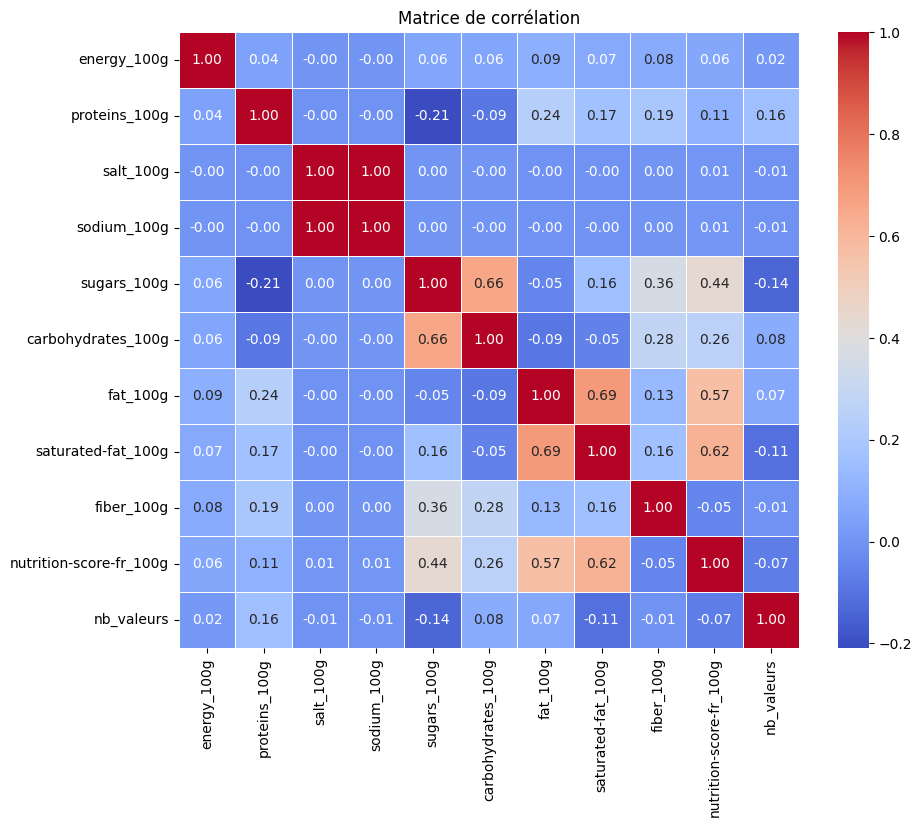

In [196]:
#tracé d'une matrice de corrélation
cormat = df_work[df_work.columns[4:]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cormat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Nous remarquons que trois couples de variables sont fortement corrélés : 

 - **salt_100g** & **sodium_100g**
 - **sugars_100g** & **carbohydrates_100g**
 - **fat_100g** & **saturated-fat_100g**

Nous étudierons plus en détails chacune de ces features en regroupant nos études par features correlées

## Analyse colonne energy_100g

**Informations générales à propos de l'énergie contenue dans 100g de nourriture**
 
 - Les légumes et les fruits frais ont tendance à avoir une faible densité énergétique, généralement entre 100 et 400 kJ/100g.
 - Les produits céréaliers comme le pain ou les pâtes peuvent varier entre 1000 et 1500 kJ/100g.
 - Les viandes, poissons et produits laitiers peuvent avoir une densité énergétique plus élevée, allant de 500 à 2500 kJ/100g selon le type et la teneur en matières grasses.

In [197]:
df_work['energy_100g'].describe()

count    2.395580e+05
mean     1.143646e+03
std      6.722267e+03
min      0.000000e+00
25%      3.850000e+02
50%      1.100000e+03
75%      1.674000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

In [198]:
# Calculer les quartiles Q1 et Q3
Q1 = df_work['energy_100g'].quantile(0.25)
Q3 = df_work['energy_100g'].quantile(0.75)

# Calculer l'écart interquartile (IQR)
IQR = Q3 - Q1

# Calculer les limites inférieure et supérieure pour les valeurs aberrantes
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Identifier les valeurs aberrantes
valeurs_aberrantes_energy = df_work[(df_work['energy_100g'] < limite_inf) | (df_work['energy_100g'] > limite_sup)]

# Afficher les valeurs aberrantes
print("30 dernières valeurs aberrantes dans la colonne 'energy_100g':")
valeurs_aberrantes_energy = valeurs_aberrantes_energy.loc[:, ['product_name', 'energy_100g']]
valeurs_aberrantes_energy.sort_values('energy_100g').tail(30)

30 dernières valeurs aberrantes dans la colonne 'energy_100g':


product_name  energy_100g
104932                            Twin Cherries Lollipops       6849.0
114969                                  Cooking Spray Oil       6975.0
27849     100% Natural Non-Stick Canola Cooking Spray Oil       6975.0
142141               Charras, Baked Corn Tostadas, Sesame       7012.0
250717                Gruyère France au lait cru (33% MG)       7029.0
218448                      300G TARTINABLE a LA NOISETTE       7339.0
286690                                  Sauce à la Crème        7341.0
311783                       Chocolate negro sin azúcares       7966.0
119387                   Raw 100% Cacao With Crunchy Nibs       8523.0
119389        Raw 100% Cacao, With Bits Of Delicate Dates       8523.0
268346                          Sir Norman Baker, Pilipit       8715.0
224442                                   Croûtons à l'ail       9050.0
275516  Cretamel, Crunchy Sesame Sticks With Cretan Honey       9623.0
178787                                 Halva with Almonds       9983.0
20070                                           Bread Mix      10757.0
66156          Crema Salvadorena, Soft Blend Dairy Spread      10966.0
80439                               Powder Spice, Classic      11954.0
290157                   Qualité & Prix Bretzels Précuits      12050.0
35308                                          Lemon Cake      13213.0
115777                              Flave!, Assorted Fish      14347.0
46967                               Instant Aka Miso Soup      14644.0
223318  Huiles vierge biologique de Colza - première p...      15481.0
245311         mini choux goût fromage de chèvre - poivre      18700.0
176697                                             bubbly      22000.0
153704                                    Salsa Hot Sauce      26861.0
119184               Sophia, Italian Drink, Squeezed Lime      94140.0
112681                     Premium Extra Virgin Olive Oil     110579.0
249101  Légume Noisettes Carottes, 500 Grammes, Marque...     182764.0
313506                 Nusco, Chocolate Spread, Chocolate     231199.0
212928                                        Pois cassés    3251373.0

In [199]:
# Expressions régulières pour détecter le mot "huile" dans différentes langues
motif_huile = r'huile|oil|aceite|olio|Öl|óleo|olie|масло|油|abura'

# Filtrer les lignes contenant les mots "huile" ou "oil" ou leurs traductions dans la colonne 'product_name'
filtre_huile = valeurs_aberrantes_energy['product_name'].str.contains(motif_huile, case=False, regex=True)

# Calculer le pourcentage d'individus contenant les mots "huile" ou "oil" ou leurs traductions
pourcentage_huile = (filtre_huile.sum() / len(valeurs_aberrantes_energy)) * 100

print(f"Le pourcentage d'individus contenant les mots 'huile' ou 'oil' avec une énergie en dehors des limites est de : {pourcentage_huile:.2f}%")

Le pourcentage d'individus contenant les mots 'huile' ou 'oil' avec une énergie en dehors des limites est de : 68.11%


L'huile est par définition composé de lipides, donc très energétique. Ces valeurs sont à conserver. 

In [200]:
valeurs_aberrantes_energy.describe()

energy_100g
count  1.013000e+03
mean   7.875991e+03
std    1.025152e+05
min    3.615000e+03
25%    3.700000e+03
50%    3.766000e+03
75%    3.887000e+03
max    3.251373e+06

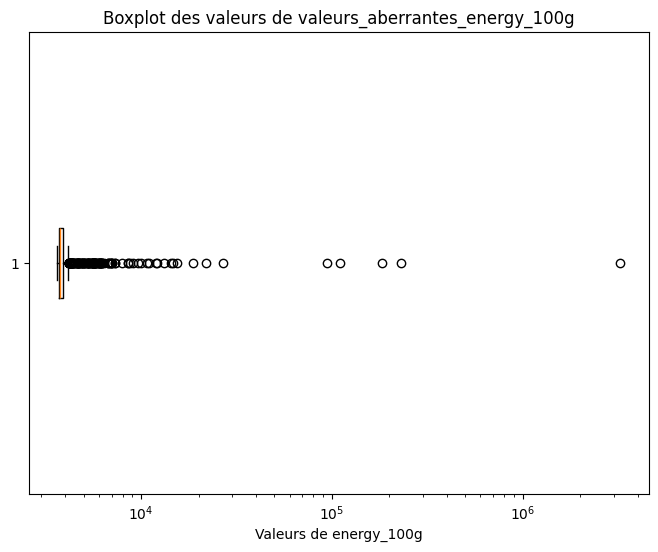

In [201]:
import matplotlib.pyplot as plt

# Créer un boxplot de la colonne 'energy_100g'
plt.figure(figsize=(8, 6))
plt.boxplot(valeurs_aberrantes_energy['energy_100g'], vert=False)
plt.xscale('log')  # Définir l'échelle logarithmique sur l'axe y
plt.xlabel('Valeurs de energy_100g')
plt.title('Boxplot des valeurs de valeurs_aberrantes_energy_100g')
plt.show()

La valeur maximale d'énergie contenue dans 100g d'aliment est déterminée par la densité énergétique des macronutriments principaux : les glucides, les protéines et les lipides.

Voici les valeurs approximatives pour chaque macronutriment :

 - Glucides : 17 kJ/g
 - Protéines : 17 kJ/g
 - Lipides : 37 kJ/g

Pour obtenir la valeur maximale d'énergie pour 100g d'aliment, nous devons rechercher l'aliment qui contient la plus grande quantité de lipides, car les lipides ont la plus grande densité énergétique par gramme.

Donc, pour obtenir la valeur maximale d'énergie pour 100g d'aliment, nous multiplions la densité énergétique des lipides par 100g :

37 kJ/g * 100g = 3700 kJ

Ainsi, la valeur maximale d'énergie contenue dans 100g d'aliment est de 3700 kJ.

**CRITERE sur la feature energy_100g** : Nous supprimerons toutes les valeurs supérieures à 4000

## Analyse colonne proteins_100g

Pour calculer la moyenne de la teneur en protéines dans les aliments généralement consommés, on peut se référer à des bases de données nutritionnelles ou des études alimentaires. La teneur en protéines des aliments varie considérablement en fonction du type d'aliment. Cependant, voici une approximation générale de la teneur en protéines pour quelques catégories d'aliments courants, basée sur les recommandations nutritionnelles et les données typiques :

 - Viandes (bœuf, poulet, porc, etc.) : Environ 20-25 g de protéines pour 100 g.
 - Poissons (saumon, thon, etc.) : Environ 20-25 g de protéines pour 100 g.
 - Œufs : Environ 12-15 g de protéines pour 100 g.
 - Légumineuses (haricots, pois chiches, lentilles, etc.) : Environ 7-9 g de protéines pour 100 g.
 - Produits laitiers (fromage, yaourt, lait) : Environ 3-8 g de protéines pour 100 g, selon le produit.
 - Céréales (riz, blé, etc.) : Environ 6-8 g de protéines pour 100 g.

In [202]:
df_work[df_work['proteins_100g']>100]

product_name    brands pnns_groups_1  \
313506  Nusco, Chocolate Spread, Chocolate  Brinkers           NaN   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
313506                  e     231199.0          430.0    0.01016        0.004   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
313506       3520.0                 NaN       NaN               550.0   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
313506      5380.0                     25.0           9

Une valeur supérieure à 100 n'a pas de sens dans ce contexte. On supprimera ces valeurs

In [203]:
df_work[df_work['proteins_100g']<0]

product_name          brands  \
169119                    Lightly Dried Cilantro  Gourmet Garden   
115310  Gourmet Blends, Seasoning, Garlic Pepper   Spice Islands   

       pnns_groups_1 nutrition_grade_fr  energy_100g  proteins_100g  \
169119           NaN                NaN          0.0         -800.0   
115310           NaN                NaN          0.0         -500.0   

        salt_100g  sodium_100g  sugars_100g  carbohydrates_100g  fat_100g  \
169119       7.62          3.0          0.0                 0.0       0.0   
115310      25.40         10.0          NaN                 0.0       0.0   

        saturated-fat_100g  fiber_100g  nutrition-score-fr_100g  nb_valeurs  
169119                 NaN         NaN                      NaN           7  
115310                 NaN         NaN                      NaN           6

Une valeur inférieure à 0 n'a pas de sens dans ce contexte. On supprimera ces valeurs

In [204]:
df_work['proteins_100g']

175609    1.0
222923    1.7
222953    2.8
256855    5.8
256854    7.0
         ... 
185675    NaN
222488    NaN
222491    NaN
222515    NaN
215598    NaN
Name: proteins_100g, Length: 260594, dtype: float64

In [205]:
df_work['pnns_groups_1'].unique()

array(['Fruits and vegetables', 'Composite foods', 'Fish Meat Eggs',
       'Sugary snacks', 'unknown', 'Cereals and potatoes', 'Salty snacks',
       'Beverages', 'Milk and dairy products', 'fruits-and-vegetables',
       'Fat and sauces', 'sugary-snacks', 'cereals-and-potatoes',
       'salty-snacks', nan], dtype=object)

le groupe Fruits and vegetables contient 
 count    3776.000000
mean        2.172818
std         3.702491
min         0.000000
25%         0.500000
50%         1.100000
75%         2.100000
max        34.000000
Name: proteins_100g, dtype: float64
le groupe Composite foods contient 
 count    5872.000000
mean        7.586239
std         4.441000
min         0.000000
25%         4.700000
50%         7.000000
75%        10.000000
max        44.000000
Name: proteins_100g, dtype: float64
le groupe Fish Meat Eggs contient 
 count    5588.000000
mean       18.608377
std         6.306588
min         0.000000
25%        14.000000
50%        19.000000
75%        22.000000
max        59.100000
Name: proteins_100g, dtype: float64
le groupe Sugary snacks contient 
 count    9684.000000
mean        5.411115
std         3.751519
min         0.000000
25%         3.500000
50%         5.800000
75%         7.100000
max        72.000000
Name: proteins_100g, dtype: float64
le groupe unknown contient 
 coun

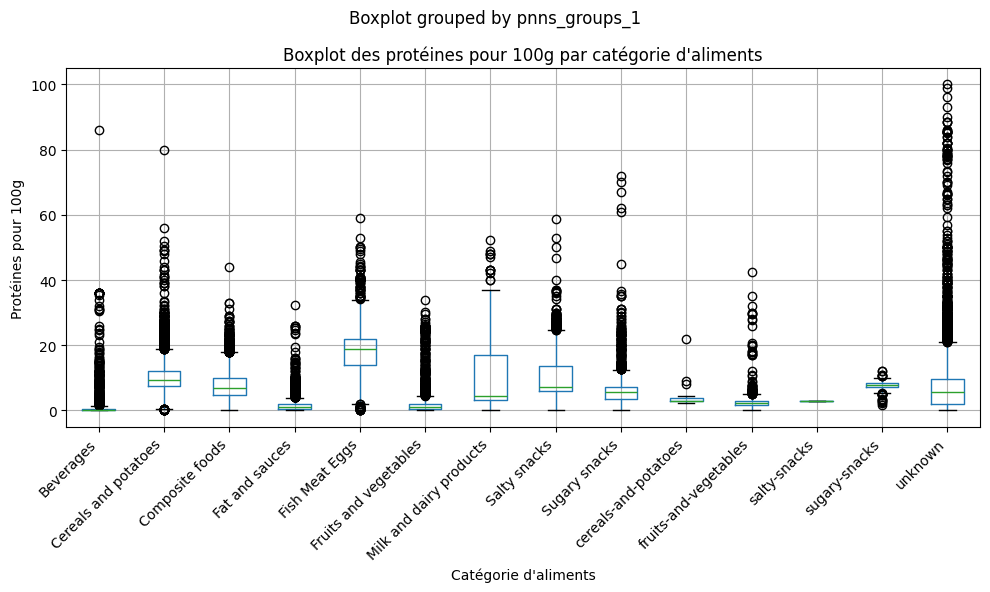

In [206]:
for groupe in df_work['pnns_groups_1'].unique():
    description = (df_work.loc[df_work['pnns_groups_1'] == groupe])['proteins_100g'].describe()
    print(f"le groupe {groupe} contient \n {description}")

    
# Créer une figure et un ensemble d'axes
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer une boxplot pour chaque groupe
df_work.boxplot(column='proteins_100g', by='pnns_groups_1', ax=ax)

# Ajuster les étiquettes d'axe et le titre
plt.xlabel('Catégorie d\'aliments')
plt.ylabel('Protéines pour 100g')
plt.title('Boxplot des protéines pour 100g par catégorie d\'aliments')

# Afficher le graphique
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes sur l'axe x
plt.tight_layout()  # Ajustement automatique de la disposition
plt.show()

## Analyse colonne salt_100g et sodium_100g

En termes de nutrition, "sel" et "sodium" sont souvent utilisés de manière interchangeable, mais ils désignent des choses légèrement différentes :

 - Sel : Le sel de table est principalement composé de chlorure de sodium (NaCl). En termes de nutrition, lorsque nous parlons de la teneur en sel d'un aliment, nous nous référons généralement à la quantité totale de chlorure de sodium.

 - Sodium : Le sodium est un élément chimique présent dans de nombreux aliments. Il est présent naturellement dans de nombreux aliments et est également ajouté sous forme de sel de table (chlorure de sodium) lors de la préparation des aliments ou dans les produits transformés.

Il est possible pour un aliment d'avoir des quantités différentes de sel et de sodium, car la teneur en sodium dans le sel de table n'est pas de 100 %. En effet, le sel de table contient environ 40 % de sodium (Na) et 60 % de chlorure (Cl). Par conséquent, la quantité de sodium dans un aliment ne sera pas exactement la même que la quantité de sel.

Cependant, dans de nombreuses circonstances, la teneur en sel est souvent exprimée en termes de sodium pour des raisons de clarté, car le sodium est l'élément préoccupant pour la santé en termes de régulation de la pression artérielle et d'autres fonctions physiologiques.

En conclusion, bien que le sel et le sodium soient étroitement liés, ils ne sont pas exactement les mêmes, et il est possible pour un aliment d'avoir des quantités différentes de sel et de sodium.

In [207]:
df_work[['salt_100g', 'sodium_100g']].describe()

salt_100g    sodium_100g
count  234554.000000  234515.000000
mean        2.064829       0.813057
std       133.714770      52.647985
min         0.000000       0.000000
25%         0.063500       0.025000
50%         0.591820       0.233000
75%         1.384300       0.545000
max     64312.800000   25320.000000

On remarque que la valeur de sodium est environ de 40% de celle du sel. Ce qui est plutôt rassurant. En effet, le sel contient 40% de sodium. 

In [208]:
df_work[df_work['salt_100g']>100]

product_name            brands  pnns_groups_1  \
176696                           herdhey's               NaN        unknown   
176694                               flake               NaN  Sugary snacks   
232239                           Keeny Bio        Bio Soleil  Sugary snacks   
233372         Sel de Guérande Label Rouge     Le guerandais        unknown   
32371   Light & Fit Greek Crunch - S'mores            Dannon        unknown   
...                                    ...               ...            ...   
165333            Garlic And Rosemary Salt             Amola            NaN   
165334              Mountain Mushroom Salt             Amola            NaN   
298059                        Kids Cristal             Aproz            NaN   
121706       Primordial Himalayan Sea Salt       Himala Salt            NaN   
121707       Primordial Himalayan Sea Salt  No  Manufacturer            NaN   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
176696                  d        215.0            3.4  124.46000    49.000000   
176694                  e        519.0            8.5  276.86000   109.000000   
232239                  e       1720.0            6.3  211.00000    83.000000   
233372                  c          0.0            0.0  125.00000    49.212598   
32371                   d        386.0            7.8  153.00000    60.300000   
...                   ...          ...            ...        ...          ...   
165333                NaN          0.0            NaN  118.11000    46.500000   
165334                NaN          0.0            NaN  118.11000    46.500000   
298059                NaN          NaN            NaN  930.00000   366.141732   
121706                NaN          NaN            NaN  112.18418    44.167000   
121707                NaN          NaN            NaN  107.69600    42.400000   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
176696         19.2                22.0     11.90               6.700   
176694         57.6                60.7     28.50              17.700   
232239         26.7                47.8     23.00               3.330   
233372          0.0                 0.0      0.00               0.000   
32371           7.8                11.3      1.77               0.709   
...             ...                 ...       ...                 ...   
165333          NaN                 0.0      0.00                 NaN   
165334          NaN                 NaN      0.00                 NaN   
298059          NaN                 NaN       NaN                 NaN   
121706          NaN                 NaN       NaN                 NaN   
121707          NaN                 NaN       NaN                 NaN   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
176696       1.600                     18.0          12  
176694       1.900                     29.0          12  
232239       0.741                     22.0          12  
233372       0.000                     10.0          12  
32371        0.709                     11.0          12  
...            ...                      ...         ...  
165333         NaN                      NaN           5  
165334         NaN                      NaN           4  
298059         NaN                      NaN           2  
121706         NaN                      NaN           2  
121707         NaN                      NaN           2  

[143 rows x 15 columns]

Des valeurs supérieures à 100g pour la colonne salt_100g n'ont pas de sens dans le contexte, on les supprimera

In [209]:
df_work[df_work['sodium_100g']>50]

product_name  \
176694                                              flake   
232239                                          Keeny Bio   
32371                  Light & Fit Greek Crunch - S'mores   
274767                                      Cheese salad    
160684            Sausage Patties, Veggie Sausage Patties   
148914                Sweet Goodies White Chocolate Balls   
120960                           Granlund's, Peco Brittle   
121892                  Inc., California Thompson Raisins   
137618                                Piri-Piri Hot Sauce   
140616       Gold Raw & Dry Roasted Combo Trail Mix Blend   
284225                                      Bamboo Shoots   
171990                                          Seasoning   
172425            Sweet Bread & Butter Pickling Seasoning   
172421                                   Bruschetta Blend   
39679                                         Garlic Salt   
68379   Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   
68388   Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   
55514                Pure Carrot With Organic Lemon Juice   
58007                                String Cheese Snacks   
11129                             Autumn Cookie Selection   
1435                                  Dill Pickle Cashews   
7983                                         Butter Beans   
28787             Fratelli Comino, Tochetti With Sea Salt   
20821                       Special Blend, Peas & Carrots   
21892   Marie Sharp's, Orange Pulp Habanero Pepper Sau...   
23590                             Original Barbecue Sauce   
106330          Small Potato Dumplings, Potato Gnocchetti   
105006                             Bastoncini Whole Wheat   
94631   Swiss Recipe Smoked Almonds & Sea Salt In Dark...   
145844                                      Prickly Syrup   
117667                                           Sea Salt   
135064                             Chiles Habaneros Rojos   
108367                            Natural Yogurt Pretzels   
120946      Evolution Salt Co, Gourmet Pink Himalaya Salt   
122061                               Smokey Tomato Speard   
51348                  Crispy Fried Onions, White Cheddar   
150718                          Quinoa Curvo Rigate Pasta   
150717                               Quinoa Pasta Fusilli   
165311                                Dressing & Marinade   
120995                         Anisa's Secrets, Steak Rub   
120994                                     Seasoning Salt   
120996             Anisa's Secrets, Rosemary Lemon Pepper   
120999                    Anisa's Secrets, Moroccan Spice   
121006                        Anisa's Secrets, Lemon Dill   
121005                 Anisa's Secrets, Poultry Seasoning   
81379              All Purpose Adobo Seasoning With Sazon   
81378                        Adobo Seasoning With Pimento   
155803         Tamarind Juice With Nata De Coco, Tamarind   
298059                                       Kids Cristal   

                                                brands    pnns_groups_1  \
176694                                             NaN    Sugary snacks   
232239                                      Bio Soleil    Sugary snacks   
32371                                           Dannon          unknown   
274767                                             NaN  Composite foods   
160684                            Heritage Health Food              NaN   
148914                                           Shefa              NaN   
120960                           Keeler & Dunkel  Inc.              NaN   
121892  Dsd Merchandisers,  D.S.D. Merchandisers  Inc.              NaN   
137618                               Taste Of Portugal              NaN   
140616                       Perfect Balance Trail Mix              NaN   
284225                                         Slender              NaN   
171990                                        Unilever              NaN   
172425             

In [210]:
#recherche des lignes du df_work dont la valeur dans la colonne sodium est supérieure à 40% de la valeur dans la colonne salt
df_work.query('sodium_100g > 0.40 * salt_100g')

Empty DataFrame
Columns: [product_name, brands, pnns_groups_1, nutrition_grade_fr, energy_100g, proteins_100g, salt_100g, sodium_100g, sugars_100g, carbohydrates_100g, fat_100g, saturated-fat_100g, fiber_100g, nutrition-score-fr_100g, nb_valeurs]
Index: []

In [211]:
df_work[(df_work['salt_100g']>90) & (df_work['salt_100g']<101)]

product_name                        brands  \
256812                  Jodsalz + Fluorid             Bad Reichenhaller   
186608                           Jod-Salz                          esco   
263291                   Meersalz mit Jod                      Alnatura   
84757   Hawaiian seasonning salt original                           Noh   
21608                 Morton Iodized Salt                        Morton   
...                                   ...                           ...   
267565   Соль илецкая пищевая высший сорт                       Руссоль   
267592                   Соль Без добавок          Тыретский солерудник   
285324    Finkornigt hushållssalt med jod  Falksalt,Ab Hanson & Möhring   
25                     Real Salt Granular                       Redmond   
71                          Fine Sea Salt                          Unfi   

       pnns_groups_1 nutrition_grade_fr  energy_100g  proteins_100g  \
256812       unknown                  c          0.0            0.0   
186608       unknown                  c          0.0            0.0   
263291       unknown                  c          0.0            0.0   
84757        unknown                  c          0.0            0.0   
21608        unknown                  c          0.0            0.0   
...              ...                ...          ...            ...   
267565       unknown                NaN          NaN            NaN   
267592       unknown                NaN          NaN            NaN   
285324       unknown                NaN          NaN            NaN   
25               NaN                NaN          NaN            NaN   
71               NaN                NaN          NaN            NaN   

        salt_100g  sodium_100g  sugars_100g  carbohydrates_100g  fat_100g  \
256812   97.94240    38.560000          0.0                 0.0       0.0   
186608   99.90000    39.330709          0.0                 0.0       0.0   
263291   99.50000    39.173228          0.0                 0.0       0.0   
84757    99.06000    39.000000          0.0                 0.0       0.0   
21608    99.90000    39.300000          0.0                 0.0       0.0   
...           ...          ...          ...                 ...       ...   
267565  100.00000    39.370079          NaN                 NaN       NaN   
267592   98.40000    38.740157          NaN                 NaN       NaN   
285324   99.90000    39.330709          NaN                 NaN       NaN   
25       96.15678    37.857000          NaN                 NaN       NaN   
71       99.90582    39.333000          NaN                 NaN       NaN   

        saturated-fat_100g  fiber_100g  nutrition-score-fr_100g  nb_valeurs  
256812                 0.0         0.0                     10.0          12  
186608                 0.0         0.0                     10.0          12  
263291                 0.0         0.0                     10.0          12  
84757                  0.0         0.0                     10.0          12  
21608                  0.0         0.0                     10.0          12  
...                    ...         ...                      ...         ...  
267565                 NaN         NaN                      NaN           3  
267592                 NaN         NaN                      NaN           3  
285324                 NaN         NaN                      NaN           3  
25                     NaN         NaN                      NaN           2  
71                     NaN         NaN                      NaN           2  

[369 rows x 15 columns]

/tmp/ipykernel_24391/1094863377.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtre_sel_salt = df_sel[df_sel['product_name'].str.contains('(sel|salt|salz|säl|sól|sal|so|sout|soutan|suol|соль|salis|salu|slāpe|Αλάτι|só|salis|sòl|soli|sool|sool)', case=False, na=False)]


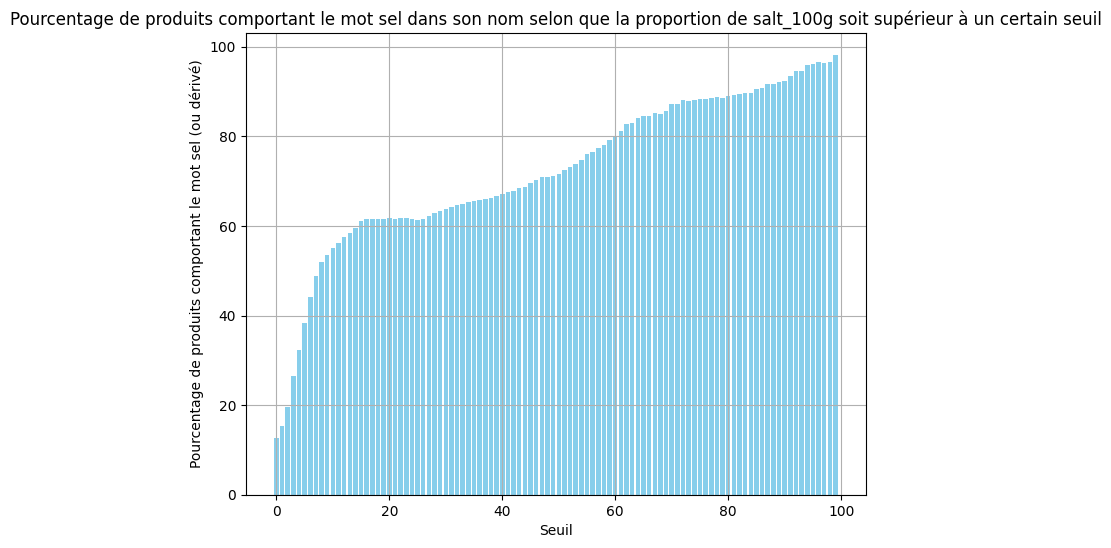

In [212]:
mondic = {}

for min in range(100):

    #recherche du pourcentage de nom de produit qui contient le mot sel ou salt 
    df_sel = df_work[(df_work['salt_100g'] < 100) & (df_work['salt_100g'] > min)]
        
    filtre_sel_salt = df_sel[df_sel['product_name'].str.contains('(sel|salt|salz|säl|sól|sal|so|sout|soutan|suol|соль|salis|salu|slāpe|Αλάτι|só|salis|sòl|soli|sool|sool)', case=False, na=False)]
    
    # Calculer le pourcentage
    pourcentage_sel_salt = (len(filtre_sel_salt) / len(df_sel)) * 100

    mondic[min] = pourcentage_sel_salt

# Extraire les clés et les valeurs du dictionnaire
cles = list(mondic.keys())
valeurs = list(mondic.values())

# Créer un graphique à barres
plt.figure(figsize=(8, 6))
plt.bar(cles, valeurs, color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel('Seuil')
plt.ylabel('Pourcentage de produits comportant le mot sel (ou dérivé)')
plt.title('Pourcentage de produits comportant le mot sel dans son nom selon que la proportion de salt_100g soit supérieur à un certain seuil')

# Afficher le graphique
plt.grid(True)
plt.show()

Il semble qu'au delà de 25% il se passe quelque chose dans la dynamique

Fixons le seuil à 25%

/tmp/ipykernel_24391/423891139.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtre_salt = df_salt[~df_salt['product_name'].str.contains('(sel|salt|salz|säl|sól|sal|so|sout|soutan|suol|соль|salis|salu|slāpe|Αλάτι|só|salis|sòl|soli|sool|sool)', case=False, na=False)]


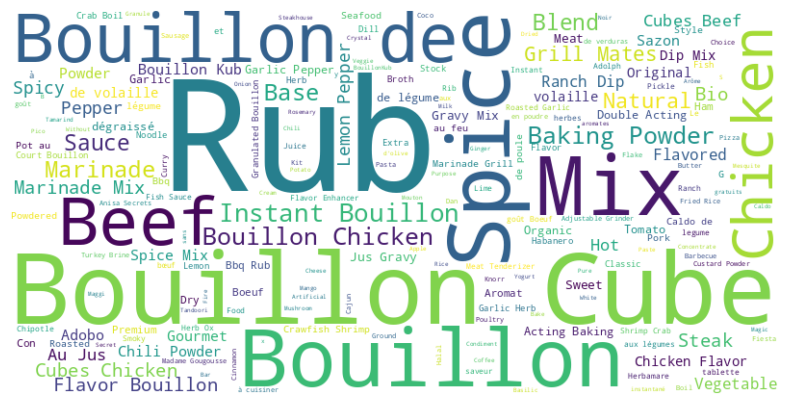

In [213]:
#Définition d'un seuil
seuil = 25

#filtrage du dataframe dont les colonnes salt_100g indiquent une valeur supérieure au seuil
df_salt = df_work[df_work['salt_100g']>seuil]

# Filtrer les lignes où la colonne 'product_name' ne contient pas le mot 'sel' ou 'salt' ou ses traductions
df_filtre_salt = df_salt[~df_salt['product_name'].str.contains('(sel|salt|salz|säl|sól|sal|so|sout|soutan|suol|соль|salis|salu|slāpe|Αλάτι|só|salis|sòl|soli|sool|sool)', case=False, na=False)]

serie_de_donnees = df_filtre_salt['product_name']


# Concaténer tous les mots de la série de données en une seule chaîne
texte = ' '.join(serie_de_donnees.astype(str))

# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

On voit que les produits contenant une quantité supérieure à 25 % (hors ceux dont le nom comporte le mot sel ou ses dérivés) sont principalement des aides culinaires, comportant naturellement beaucoup d'aromates, dont du sel. 

On conservera ces produits dans la base.

Le sel de table (chlorure de sodium) contient environ 40% de sodium et 60% de chlorure. Cela signifie que pour chaque gramme de sel, environ 400 milligrammes (mg) sont du sodium.

Voici une explication plus détaillée :

    Le sel de table est composé principalement de deux éléments : le sodium (Na) et le chlorure (Cl).
    La formule chimique du sel de table est NaCl, ce qui signifie qu'un atome de sodium est lié à un atome de chlore.
    La masse molaire du sodium (Na) est d'environ 23 g/mol et celle du chlore (Cl) est d'environ 35,5 g/mol.
    Dans un gramme de sel de table (NaCl), il y a environ 23 g/mol (sodium) / 58,5 g/mol (NaCl) ≈ 0,39 g de sodium.
    Cela signifie que 1 g de sel de table contient environ 0,39 g (ou 390 mg) de sodium.

Donc, bien que le sel de table soit souvent appelé simplement "sel", il est important de comprendre qu'il contient à la fois du sodium et du chlorure, avec le sodium représentant environ 40% de sa composition.

**CRITERE Salt_100g** supprimer valeurs supérieures à 100g

**CRITERE Sodium_100g** supprimer valeurs supérieur à 40g 

## Analyse colonne sugars_100g et carbohydrates_100g et fiber_100g

Dans une information nutritionnelle typique, la quantité totale de glucides (carbohydrates) devrait généralement être plus grande que la quantité de sucres (sugar). Cela est dû au fait que les glucides comprennent non seulement les sucres simples, mais aussi les amidons complexes et les fibres alimentaires.

Voici une brève explication de chaque composant :

 - Glucides (Carbohydrates) :

    Les glucides comprennent à la fois les sucres simples et les glucides complexes. Ils constituent la principale source d'énergie pour notre corps. Les glucides complexes sont constitués de longues chaînes de molécules de glucose, et ils sont trouvés dans des aliments tels que les céréales complètes, les légumineuses, les fruits et les légumes. Les fibres alimentaires, qui sont un type de glucide complexe, sont également incluses dans cette catégorie. Les glucides fournissent de l'énergie durable et soutiennent de nombreuses fonctions corporelles.

 - Sucres (Sugar) :

    Les sucres sont un sous-ensemble des glucides et comprennent des sucres simples comme le glucose, le fructose, le saccharose, le lactose, etc. Ils sont présents naturellement dans des aliments comme les fruits, le lait et certains légumes, ainsi que ajoutés aux aliments transformés sous forme de sucre ajouté. Les sucres ajoutés sont souvent associés à des aliments transformés tels que les boissons sucrées, les desserts, les bonbons, etc. Les sucres ajoutés peuvent fournir de l'énergie rapide, mais leur consommation excessive peut contribuer à divers problèmes de santé.

En général, la quantité totale de glucides dans une information nutritionnelle comprend à la fois les sucres et d'autres formes de glucides, comme les fibres et les amidons. Par conséquent, il est courant que la quantité totale de glucides soit plus grande que la quantité de sucres dans un produit alimentaire. Cependant, cela peut varier en fonction du type d'aliment et de sa composition nutritionnelle spécifique

In [214]:
df_sucre = df_work[['sugars_100g', 'carbohydrates_100g', 'fiber_100g']]
df_sucre.describe()

sugars_100g  carbohydrates_100g     fiber_100g
count  225214.000000       222616.000000  185256.000000
mean       15.883228           32.217482       2.876605
std        22.307991           29.782922      13.342872
min       -17.860000            0.000000      -6.700000
25%         1.300000            6.000000       0.000000
50%         5.600000           21.000000       1.500000
75%        24.000000           58.820000       3.600000
max      3520.000000         2916.670000    5380.000000

In [215]:
#affichage des produits qui contiennent plus de sucres que de carbohydrates
df_work[(df_work['sugars_100g']) > df_work['carbohydrates_100g']]


product_name  \
183860                 Filets de poulet rôtis   
257122                           Ajolix Chili   
149041  Wild Pacific Sardines in Tomato Sauce   
184952                       Compote de pêche   
195237         tomates entières pelées au jus   
...                                       ...   
33266           Brown Sugar & Sucralose Blend   
62599     Lea & Perrins, Marinade For Chicken   
65596          Fruit Tart, Strawberry Rhubarb   
170121        Party Peanuts, Roasted & Salted   
150779                                    Jam   

                                      brands          pnns_groups_1  \
183860                            Le gaulois         Fish Meat Eggs   
257122                     Feinkost Dittmann  Fruits and vegetables   
149041                     Raincoast Trading         Fish Meat Eggs   
184952                         Queen s jewel  Fruits and vegetables   
195237                          Louis martin  Fruits and vegetables   
...                                      ...                    ...   
33266     Food Club,  Topco Associates  Inc.                    NaN   
62599                    Lea & Perrins  Inc.                    NaN   
65596                       Clearbrook Farms                    NaN   
170121  Smart Sense,  Sears  Roebuck And Co.                    NaN   
150779                      Lbb Imports  Llc                    NaN   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
183860                  b        635.0           23.0    1.28000     0.503937   
257122                  c        408.0            4.9    4.48000     1.763780   
149041                  b        673.0           17.9    0.81600     0.321000   
184952                  b        448.0            0.7    0.01000     0.003937   
195237                  a         19.0            1.0    0.50000     0.196850   
...                   ...          ...            ...        ...          ...   
33266                 NaN       2092.0            0.0    0.00000     0.000000   
62599                 NaN        418.0            0.0    3.72618     1.467000   
65596                 NaN        669.0            NaN    0.00000     0.000000   
170121                NaN          NaN            NaN        NaN          NaN   
150779                NaN       1134.0            0.5        NaN          NaN   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
183860         0.60                 0.5      6.10                1.60   
257122        10.90                 9.5      4.40                0.40   
149041         1.79                 0.0      8.93                1.79   
184952        24.00                23.0      0.10                0.10   
195237         2.70                 2.3      0.10                0.01   
...             ...                 ...       ...                 ...   
33266        100.00                50.0      0.00                 NaN   
62599          6.67                 0.0      0.00                 NaN   
65596         12.00                 0.0      0.00                 NaN   
170121         0.88                 0.0      4.21                0.59   
150779        67.00                66.4      0.10                 NaN   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
183860         0.5                      2.0          12  
257122         0.0                      5.0          12  
149041         0.0                      1.0          12  
184952         0.0                      1.0          12  
195237         2.2                     -6.0          12  
...            ...                      ...         ...  
33266          NaN                      NaN           7  
62599          NaN                      NaN           7  
65596          NaN                      NaN           6  
170121         0.4                      NaN           5  
150779         NaN                      NaN           5  

[650 rows x 15 columns]

**decision** : On supprimera ces individus puisque ces valeurs sont incohérentes

In [216]:
#affichage des produits qui contiennent plus de (sucres+fibres) que de carbohydrates
df_work[(df_work['sugars_100g'] + df_work['fiber_100g']) > df_work['carbohydrates_100g']]

product_name  \
256878                                         Stevi Drop   
222939                                     Poire Williams   
222943                             Mes fruits Pomme Coing   
184021  Rote-Rübensaft aus den Regionen Weinviertel un...   
222972  Petits pots carotte, potimarron, pomme & canar...   
...                                                   ...   
238230  Spécialité de Fuits Pomme Pêche Sans Sucres Aj...   
162                                Organic Zante Currants   
65851                         Mint Flutes, Dark Chocolate   
240084                                     Compote gourde   
289979                                 Mélange de salades   

                     brands          pnns_groups_1 nutrition_grade_fr  \
256878               Haribo          Sugary snacks                  a   
222939              Babybio                unknown                  b   
222943              BabyBio  Fruits and vegetables                  a   
184021  zurück zum Ursprung                unknown                  b   
222972              Babybio                unknown                  a   
...                     ...                    ...                ...   
238230            Carrefour  Fruits and vegetables                NaN   
162                    Unfi                    NaN                NaN   
65851        Elizabeth Shaw                    NaN                NaN   
240084            Carrefour                unknown                NaN   
289979     Coop Betty Bossi                    NaN                NaN   

        energy_100g  proteins_100g  salt_100g  sodium_100g  sugars_100g  \
256878        757.0           8.10   0.635000     0.250000         2.50   
222939        187.0           0.40   0.025908     0.010200         9.20   
222943        191.0           0.20   0.013208     0.005200         8.41   
184021        175.0           1.00   0.101600     0.040000         8.00   
222972        155.0           2.30   0.050000     0.019685         3.80   
...             ...            ...        ...          ...          ...   
238230        200.0            NaN        NaN          NaN        10.00   
162          1046.0           3.75        NaN          NaN        62.50   
65851        2176.0            NaN        NaN          NaN        58.20   
240084        277.0            NaN        NaN          NaN        14.00   
289979         50.0            NaN        NaN          NaN         1.00   

        carbohydrates_100g  fat_100g  saturated-fat_100g  fiber_100g  \
256878                16.0       0.1                0.10       48.60   
222939                 9.2       0.2                0.10        2.00   
222943                 9.7       0.1                0.10        2.39   
184021                 8.5       0.1                0.10        1.20   
222972                 3.8       1.0                0.18        1.80   
...                    ...       ...                 ...         ...   
238230                10.0       NaN                 NaN        2.00   
162                   65.0       NaN                 NaN        5.00   
65851                 60.0      29.7                 NaN        4.00   
240084                15.0       NaN                 NaN        1.70   
289979                 1.0       NaN                 NaN        1.50   

        nutrition-score-fr_100g  nb_valeurs  
256878                     -6.0          12  
222939                      0.0          12  
222943                     -7.0          12  
184021                      0.0          12  
222972                     -3.0          12  
...                         ...         ...  
238230                      NaN           5  
162                         NaN           5  
65851                       NaN           5  
240084                      NaN           5  
289979                      NaN           4  

[13895 rows x 15 columns]

**remarque** Les fibres sont considérés par les nutritionnistes comme des glucides (carbohydrates). Néanmoins, les fibres n'étant pas digérées par l'organisme, la manière de les intégrer au calcul de la quantité de glucides varients selon le fabricant. 

Ainsi, nous ne traiterons pas les individus dont la somme sugar + fiber > carbohydrates

### sugars_100g

In [217]:
df_sucre = df_work[(df_work['sugars_100g']<=100) & (df_work['sugars_100g']>=0)]['sugars_100g']
df_sucre.describe()

count    225196.000000
mean         15.863978
std          21.040509
min           0.000000
25%           1.300000
50%           5.600000
75%          24.000000
max         100.000000
Name: sugars_100g, dtype: float64

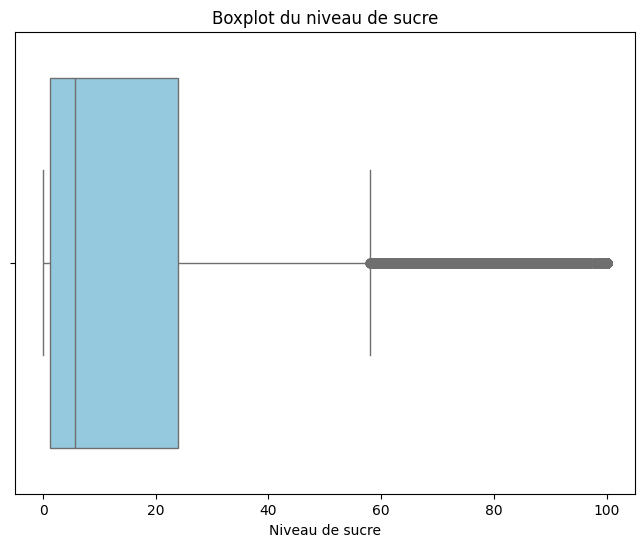

In [218]:
# Tracer le boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_sucre, color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Niveau de sucre')
plt.title('Boxplot du niveau de sucre')

# Afficher le boxplot
plt.show()


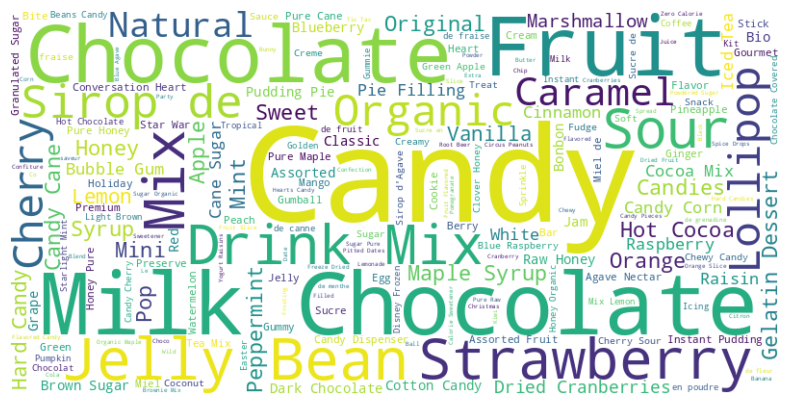

In [219]:
#analyse des outliers

df_out_suc = df_work[['product_name', 'sugars_100g']][df_work['sugars_100g']>60]

serie_de_donnees = df_out_suc['product_name']
# Concaténer tous les mots de la série de données en une seule chaîne
texte = ' '.join(serie_de_donnees.astype(str))

# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Critere Sugars_100g** On conserve les données dont les valeurs sont situées entre 0 et 100

### carbohydrates_100g

In [220]:
df_carbo = df_work[(df_work['carbohydrates_100g']<=100) & (df_work['carbohydrates_100g']>=0)]['carbohydrates_100g']
df_carbo.describe()

count    222599.000000
mean         32.197781
std          29.137647
min           0.000000
25%           6.000000
50%          21.000000
75%          58.820000
max         100.000000
Name: carbohydrates_100g, dtype: float64

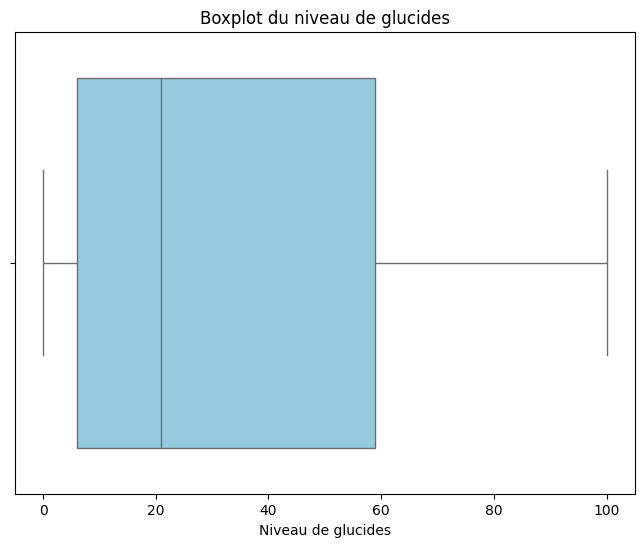

In [221]:
# Tracer le boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_carbo, color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Niveau de glucides')
plt.title('Boxplot du niveau de glucides')

# Afficher le boxplot
plt.show()


Il semble ne pas y avoir beaucoup d'outliers pour la feature carbohydrate. 
**Critere Carbohydrates_100g** On conservera toutes les valeurs entre 0 et 100

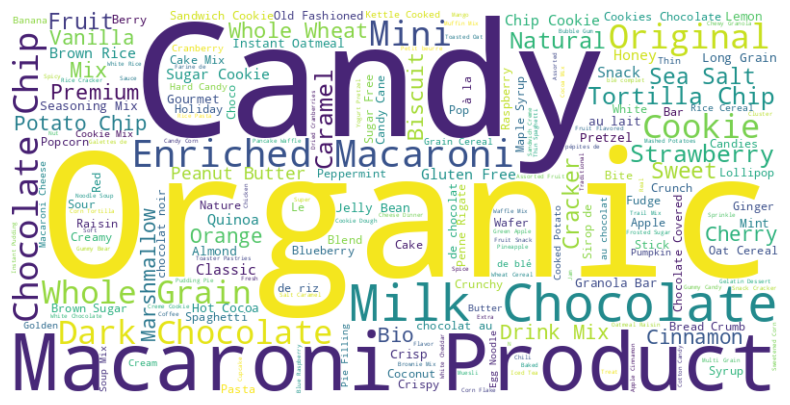

In [222]:
#analyse des valeurs les plus grandes

df_out_carbo = df_work[['product_name', 'carbohydrates_100g']][df_work['carbohydrates_100g']>60]

serie_de_donnees = df_out_carbo['product_name']
# Concaténer tous les mots de la série de données en une seule chaîne
texte = ' '.join(serie_de_donnees.astype(str))

# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Critere Sugars_100g** On conserve les données dont les valeurs sont situées entre 0 et 100

### fiber_100g

In [223]:
df_fib = df_work[(df_work['fiber_100g']<=100) & (df_work['fiber_100g']>=0)]['fiber_100g']
df_fib.describe()

count    185251.000000
mean          2.844466
std           4.617076
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

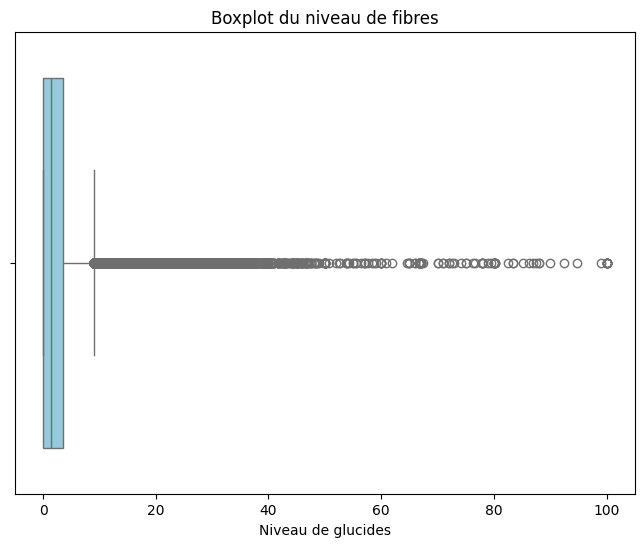

In [224]:
# Tracer le boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_fib, color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Niveau de glucides')
plt.title('Boxplot du niveau de fibres')

# Afficher le boxplot
plt.show()


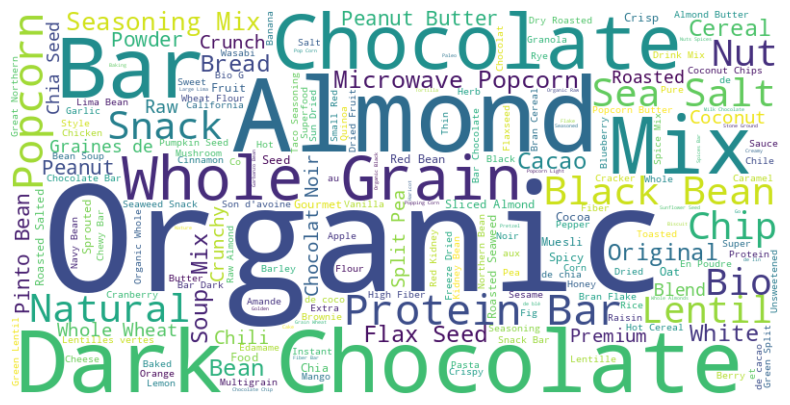

In [225]:
#analyse des valeurs les plus grandes

df_out_fib = df_work[['product_name', 'fiber_100g']][(df_work['fiber_100g']>12) &(df_work['fiber_100g']<100)]

serie_de_donnees = df_out_fib['product_name']
# Concaténer tous les mots de la série de données en une seule chaîne
texte = ' '.join(serie_de_donnees.astype(str))

# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Critere fiber_100g** On conservera les valeurs situées entre 0 et 100

## Analyse colonne fat_100g et trans-fat_100g

Le lien entre le gras (fat) et les gras saturés (saturated fat) réside dans leur composition et leur effet sur la santé :

 - Composition :
        Le gras (fat) est une classe générale de macronutriments qui comprend différents types d'acides gras, y compris les saturés, les insaturés et les trans.
        Les gras saturés sont une catégorie spécifique d'acides gras présents dans de nombreux aliments d'origine animale et végétale.

 - Effets sur la santé :
        Les gras saturés ont tendance à augmenter le taux de cholestérol LDL (mauvais cholestérol) dans le sang, ce qui peut contribuer à l'accumulation de plaques dans les artères et augmenter le risque de maladies cardiovasculaires.
        La consommation excessive de gras saturés est associée à des problèmes de santé comme les maladies cardiaques et l'obésité.
        La plupart des aliments riches en gras contiennent une combinaison de gras saturés, insaturés et, dans certains cas, trans.

 - Aliments sources :
        Les aliments riches en gras peuvent contenir une combinaison de gras saturés et insaturés. Par exemple, les aliments d'origine animale comme la viande, le beurre et les produits laitiers sont souvent riches en gras saturés.
        Certains aliments végétaux, comme les huiles de coco et de palme, ainsi que certaines noix et graines, contiennent également des quantités significatives de gras saturés.

En résumé, bien que tous les gras (fat) ne soient pas saturés, une partie des graisses alimentaires peut être constituée de gras saturés. Ces gras saturés, lorsqu'ils sont consommés en excès, peuvent avoir des effets néfastes sur la santé cardiovasculaire. Il est donc recommandé de surveiller et de limiter la consommation de gras saturés dans le cadre d'une alimentation équilibrée.

In [226]:
df_fats = df_work[['fat_100g', 'saturated-fat_100g']][(df_work['fat_100g']<100)&(df_work['fat_100g']>0)&(df_work['saturated-fat_100g']<100)&(df_work['saturated-fat_100g']>0)]
df_fats.describe()

fat_100g  saturated-fat_100g
count  132460.000000       132460.000000
mean       19.029253            7.255904
std        17.196157            7.980743
min         0.000100            0.000100
25%         5.500000            1.670000
50%        15.150000            4.600000
75%        28.000000           10.620000
max        99.900000           94.000000

In [227]:
#recherche des lignes du dataframe dont les valeurs de fat sont inf à sat_fat
df_fats[(df_fats['fat_100g'] < df_fats['saturated-fat_100g'])]

fat_100g  saturated-fat_100g
224682      3.10                6.40
224179      7.80                8.80
223953      0.50                1.00
253530      0.30                2.10
253699     22.20               24.00
...          ...                 ...
114333      9.29               10.00
3450        1.31                1.62
289618     16.00               28.00
299811      3.00               19.60
295593      0.50               14.00

[221 rows x 2 columns]

**Critere fat_100g et saturated-fat_100g** : On supprimera les individus dont les valeurs en fat est inférieures à la valeur saturated fat

### fat_100g

In [228]:
df_fat = df_fats[(df_fats['fat_100g'] > df_fats['saturated-fat_100g'])]
df_fat = df_fat['fat_100g']
df_fat.describe()

count    129149.000000
mean         19.362479
std          17.215432
min           0.005000
25%           6.000000
50%          15.790000
75%          28.570000
max          99.900000
Name: fat_100g, dtype: float64

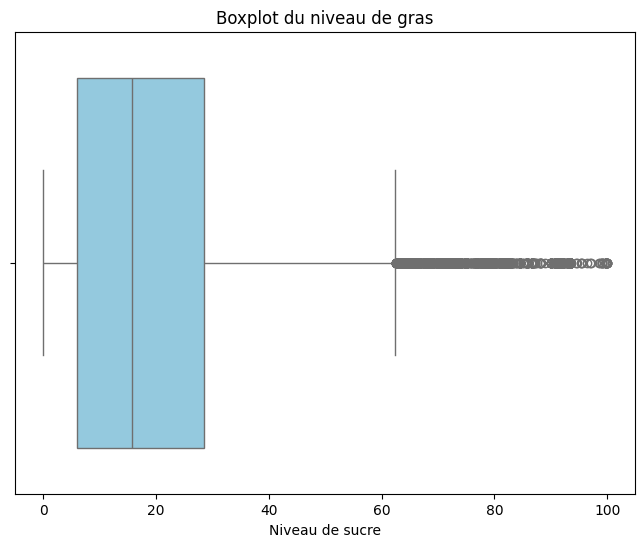

In [229]:
# Tracer le boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_fat, color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Niveau de sucre')
plt.title('Boxplot du niveau de gras')

# Afficher le boxplot
plt.show()


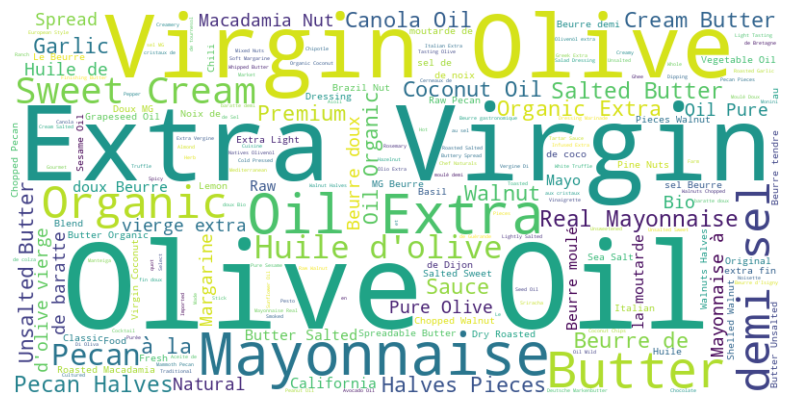

In [230]:
#analyse des outliers

df_out_fat = df_work[['product_name', 'fat_100g']][(df_work['fat_100g']>60) & (df_work['fat_100g']<100)]

serie_de_donnees = df_out_fat['product_name']
# Concaténer tous les mots de la série de données en une seule chaîne
texte = ' '.join(serie_de_donnees.astype(str))

# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Critere fat_100g** : On voit clairement que les outliers sont constitués de produits à base de gras telles que huiles beurre etc.. on conservera ces outliers

### saturated-fat_100g

In [231]:
df_sat_fat = df_fats[(df_fats['fat_100g'] > df_fats['saturated-fat_100g'])]
df_sat_fat = df_sat_fat['saturated-fat_100g']
df_sat_fat.describe()

count    129149.000000
mean          7.272717
std           7.894601
min           0.000100
25%           1.750000
50%           4.690000
75%          10.640000
max          93.000000
Name: saturated-fat_100g, dtype: float64

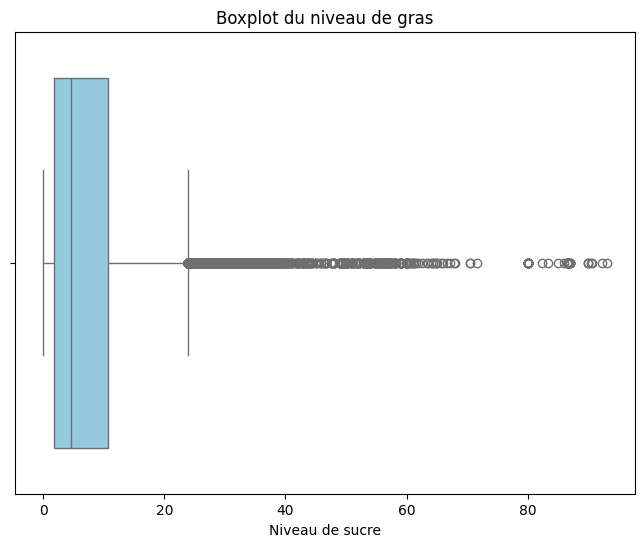

In [232]:
# Tracer le boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_sat_fat, color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Niveau de sucre')
plt.title('Boxplot du niveau de gras')

# Afficher le boxplot
plt.show()


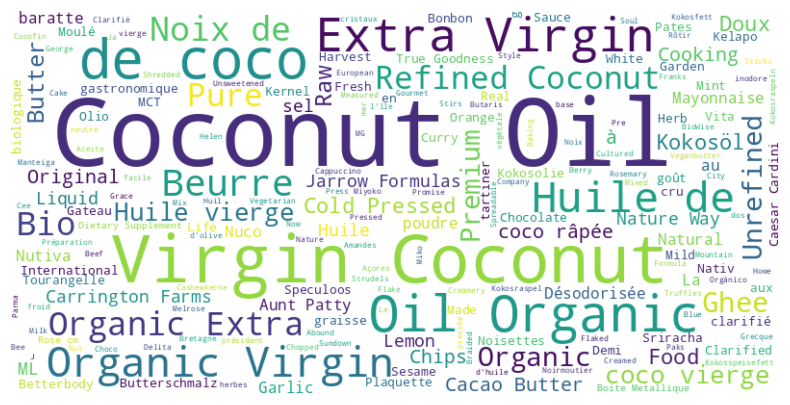

In [233]:
#analyse des outliers

df_out_sat_fat = df_work[['product_name', 'saturated-fat_100g']][(df_work['saturated-fat_100g']>60) & (df_work['saturated-fat_100g']<100)]

serie_de_donnees = df_out_sat_fat['product_name']
# Concaténer tous les mots de la série de données en une seule chaîne
texte = ' '.join(serie_de_donnees.astype(str))

# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Critere saturated-fat_100g** : On voit clairement que les outliers sont constitués de produits à base de gras telles que huiles beurre etc.. on conservera ces outliers

## Analyse conjointe des quantités de nutriments fondamentaux

Les trois composants fondamentaux d'un aliment sont 
 - carbohydrate
 - proteins
 - fat

La somme totale des masses doit être inférieure à 100

Recherchons ces individus

In [234]:
df_filtered = df_work[
    (df_work['carbohydrates_100g'] > 0) & (df_work['carbohydrates_100g'] < 100) &
    (df_work['proteins_100g'] > 0) & (df_work['proteins_100g'] < 100) &
    (df_work['fat_100g'] > 0) & (df_work['fat_100g'] < 100)
][['carbohydrates_100g', 'proteins_100g', 'fat_100g']]
df_filtered = df_filtered[df_filtered.sum(axis = 1)>100]
df_filtered.sum(axis = 1).describe()

count    1432.000000
mean      108.347457
std        12.537398
min       100.000000
25%       100.010000
50%       103.570000
75%       110.000000
max       212.500000
dtype: float64

Il y a 1500 individus hors limites, on supprimera ces individus. 

## Récapitulatif critères

Suite à l'analyse de chacunes des feature effectuée ci dessus, nous dégageons certains critères de tri qui pourront nous permettre de supprimer les individus ne respectant pas ces critères

**critère feature unique** : 

 - 0 <= energy_100g<= 4000 

*critère sur feature unique identique* :
 
 - 0 <= proteins_100g<= 100 
 - 0 <= salt_100g<= 100 
 - 0 <= sodium_100g<= 40
 - 0 <= sugars_100g<= 100 
 - 0 <= carbohydrates_100g<= 100
 - 0 <= fiber_100g<= 100 
 - 0 <= fat_100g <= 100
 - 0 <= saturated-fat_100g <= 100

**critere features croisées** : 

 - sodium_100g < 45%(salt_100g)
 - sugars_100g < carbohydrates_100g
 - fat_100g + proteins_100g + carbohydrate_100g <= 100

In [235]:
df_work

product_name  \
175609                           Piña &quot;Agropen&quot;   
222923                            Petit pot légumes verts   
222953  Babybio Junior, Mon p'tit plat : Mijoté de Pet...   
256855                     Soft Baked Brown-Style Cookies   
256854                                     Keks Geknusper   
...                                                   ...   
185675                         Prista Crispbread Original   
222488                                           Gazpacho   
222491          Mes carottes râpées aux coeurs de palmier   
222515                                     Œufs plein air   
215598                                     Miel de fleurs   

                                        brands          pnns_groups_1  \
175609  Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
222923                                 Babybio        Composite foods   
222953                                 Babybio         Fish Meat Eggs   
256855              Cookies Bakery,DeBeukelaer          Sugary snacks   
256854                                Griesson          Sugary snacks   
...                                        ...                    ...   
185675                             Damora,Aldi   Cereals and potatoes   
222488                         Pierre Martinet  Fruits and vegetables   
222491                         Pierre Martinet        Composite foods   
222515                                 Matines         Fish Meat Eggs   
215598                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
175609                  a        209.0            1.0   0.000000     0.000000   
222923                  a        186.0            1.7   0.014986     0.005900   
222953                  a        197.0            2.8   0.068580     0.027000   
256855                  e       1985.0            5.8   0.450000     0.177165   
256854                  d       2011.0            7.0   0.500000     0.196850   
...                   ...          ...            ...        ...          ...   
185675                NaN          NaN            NaN        NaN          NaN   
222488                NaN          NaN            NaN        NaN          NaN   
222491                NaN          NaN            NaN        NaN          NaN   
222515                NaN          NaN            NaN        NaN          NaN   
215598                NaN          NaN            NaN        NaN          NaN   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
175609         10.0                14.0       0.0                0.00   
222923          1.2                 7.1       0.5                0.10   
222953          1.1                 4.8       1.4                0.75   
256855         39.0                59.0      23.0               11.00   
256854         48.0                66.0      20.0                4.00   
...             ...                 ...       ...                 ...   
185675          NaN                 NaN       NaN                 NaN   
222488          NaN                 NaN       NaN                 NaN   
222491          NaN                 NaN       NaN                 NaN   
222515          NaN                 NaN       NaN                 NaN   
215598          NaN                 NaN       NaN                 NaN   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
175609         4.0                     -8.0          12  
222923         2.2                     -4.0          12  
222953         2.0                     -3.0          12  
256855         4.0                     19.0          12  
256854         3.8                     16.0          12  
...            ...                      ...         ...  
185675         NaN                      NaN           1  
222488         NaN                      NaN           1  
222491         NaN                      NaN           1  
22251

In [236]:
df_work['pnns_groups_1'].value_counts()

pnns_groups_1
unknown                    19497
Sugary snacks              11796
Milk and dairy products     8518
Beverages                   8350
Cereals and potatoes        8066
Fish Meat Eggs              7691
Composite foods             6582
Fruits and vegetables       5643
Fat and sauces              4838
Salty snacks                2667
fruits-and-vegetables        949
sugary-snacks                488
cereals-and-potatoes          16
salty-snacks                   1
Name: count, dtype: int64

## Création d'une fonction de traitement automatique des valeurs aberrantes

In [237]:
def filtre2(dataframe):
    
    df_work = dataframe.copy()

    df_work = filtre1(df_work)

    #filtrage feature energy 100g (sans supprimer les nan)

    df_work = df_work[(df_work['energy_100g'].isna()) | (df_work['energy_100g'] <= 4000)]

    #filtrage >0 & <100 (suppression colonnes)
    
    columns_to_check = ['proteins_100g', 'salt_100g', 'sugars_100g', 'carbohydrates_100g', 'fiber_100g', 'fat_100g', 'saturated-fat_100g']
    
    for colonne in columns_to_check:
        df_work = df_work[(df_work[colonne].isna()) | ((df_work[colonne] >= 0) & (df_work[colonne] <= 100))]
    

    
    # filtrage features croisées

    # conservation des lignes où le sodium est inf à 45% salt
    df_work = df_work[(df_work['sodium_100g'].isna()) | (df_work['salt_100g'].isna()) | (df_work['sodium_100g'] <= 0.45 * df_work['salt_100g'])]

    #conservation lignes ou le sucre est inf aux carbohydrate (glucides)
    df_work = df_work[(df_work['sugars_100g'].isna()) | (df_work['carbohydrates_100g'].isna()) | (df_work['sugars_100g'] <= df_work['carbohydrates_100g'])]
    

    # Calculer la somme des valeurs dans les colonnes energy_100g, proteins_100g et carbohydrates_100g
    sum_values = df_work[['fat_100g', 'proteins_100g', 'carbohydrates_100g']].sum(axis=1)

    # Filtrer les lignes où la somme est inférieure ou égale à 100 (enconservant les nans)
    df_work = df_work[(sum_values.isna()) | (sum_values <= 100)]

    
    return df_work   

In [238]:
df_work2 = filtre2(df_work)

In [239]:
df_work2

product_name  \
175609                Piña &quot;Agropen&quot;   
204933                    Cookies Nougat' Choc   
202210  Burger Gourmand aux graines & céréales   
204930                      Sirop de grenadine   
202208              Longue Conservation nature   
...                                        ...   
250606        Le Haché 100 % canard assaisonné   
250607                                 Endives   
250609                       Pur jus de pommes   
250771                          Basilic Grande   
215598                          Miel de fleurs   

                                        brands          pnns_groups_1  \
175609  Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
204933                                Chabrior          Sugary snacks   
202210                          Harrys,Barilla   Cereals and potatoes   
204930                                 Paquito              Beverages   
202208                                  Harrys   Cereals and potatoes   
...                                        ...                    ...   
250606                          Les Thomasines         Fish Meat Eggs   
250607                                 En'Diva  Fruits and vegetables   
250609                     Le petit producteur              Beverages   
250771                               Pronatura                unknown   
215598                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
175609                  a        209.0            1.0    0.00000        0.000   
204933                  e       2117.0            5.8    1.21920        0.480   
202210                  a       1118.0           10.3    1.09982        0.433   
204930                  e       1376.0            1.6    0.00254        0.001   
202208                  c       1201.0            9.5    1.32842        0.523   
...                   ...          ...            ...        ...          ...   
250606                NaN          NaN            NaN        NaN          NaN   
250607                NaN          NaN            NaN        NaN          NaN   
250609                NaN          NaN            NaN        NaN          NaN   
250771                NaN          NaN            NaN        NaN          NaN   
215598                NaN          NaN            NaN        NaN          NaN   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
175609         10.0                14.0       0.0                 0.0   
204933         27.8                61.1      26.0                13.1   
202210          2.8                44.9       3.7                 0.6   
204930         77.6                77.6       0.8                 0.1   
202208          6.0                51.8       4.1                 2.4   
...             ...                 ...       ...                 ...   
250606          NaN                 NaN       NaN                 NaN   
250607          NaN                 NaN       NaN                 NaN   
250609          NaN                 NaN       NaN                 NaN   
250771          NaN                 NaN       NaN                 NaN   
215598          NaN                 NaN       NaN                 NaN   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
175609         4.0                     -8.0          12  
204933         2.2                     24.0          12  
202210         5.3                     -3.0          12  
204930         0.5                     20.0          12  
202208         2.4                      8.0          12  
...            ...                      ...         ...  
250606         NaN                      NaN           1  
250607         NaN                      NaN           1  
250609         NaN                      NaN           1  
250771         NaN                      NaN           1  
215598         NaN                      NaN           1  

[258053 r

# 3 - Identification et traitement des valeurs manquantes

**Objectifs :**

 - Identification des valeurs manquantes
 - Application de méthodes appropriées pour traiter ces valeurs adéquatement

### Remplissage par des valeurs constantes

 - Avantages :
    - Simple à implémenter.
    - Ne nécessite pas de calcul complexe.
    - Pratique lorsque les valeurs manquantes sont aléatoires et peu nombreuses.

 - Inconvénients :
    - Peut introduire des biais dans les données.
    - Ne tient pas compte des relations entre les variables.

--- 

**Marche à suivre :**
 - Détermination de la valeur constante (0, moyenne, médiane)
 - Détermination de la colonne (en fonction du contexte et de l'impact sur les résultats)

#### préambule

certaines catégories du groupe_pnns sont redondantes

Remplaçons : 
 - Fruits and vegetables et fruits-and-vegetables
 - Cereals and potatoes et cereals-and-potatoes
 - Sugary snacks et sugary-snacks
 - Salty snacks et salty-snacks
 - unknown et nan


In [240]:
#Préambule merge des catégories pnns
df_work2['pnns_groups_1'].unique()

array(['Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes',
       'Beverages', 'Milk and dairy products', 'Fat and sauces',
       'Composite foods', 'sugary-snacks', 'unknown', 'Fish Meat Eggs',
       'Salty snacks', 'fruits-and-vegetables', 'cereals-and-potatoes',
       'salty-snacks', nan], dtype=object)

In [241]:
#remplacement des valeurs
df_work2['pnns_groups_1'].replace({
    'fruits-and-vegetables': 'Fruits and vegetables',
    'cereals-and-potatoes': 'Cereals and potatoes',
    'sugary-snacks': 'Sugary snacks',
    'salty-snacks': 'Salty snacks'
}, inplace=True)

#traitement valeurs nan (remplacement par unknown
df_work2['pnns_groups_1'].replace('unknown', np.nan, inplace=True)

/tmp/ipykernel_24391/2724461260.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_work2['pnns_groups_1'].replace({


In [242]:
df_work2['pnns_groups_1'].unique()

array(['Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes',
       'Beverages', 'Milk and dairy products', 'Fat and sauces',
       'Composite foods', nan, 'Fish Meat Eggs', 'Salty snacks'],
      dtype=object)

In [243]:
df_work2.shape

(258053, 15)

In [244]:
# affichage du nombre de valeurs manquantes 
df_work2.isnull().sum()

product_name                    0
brands                       4621
pnns_groups_1              192663
nutrition_grade_fr          56020
energy_100g                 21021
proteins_100g               22070
salt_100g                   26006
sodium_100g                 26045
sugars_100g                 35227
carbohydrates_100g          37903
fat_100g                    37583
saturated-fat_100g          48846
fiber_100g                  74989
nutrition-score-fr_100g     56020
nb_valeurs                      0
dtype: int64

#### Valeur nulle

In [245]:
#recherche des valeurs uniques du groupe pnns
df_work2['pnns_groups_1'].unique()

array(['Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes',
       'Beverages', 'Milk and dairy products', 'Fat and sauces',
       'Composite foods', nan, 'Fish Meat Eggs', 'Salty snacks'],
      dtype=object)

In [246]:
df_work2.describe()

energy_100g  proteins_100g      salt_100g    sodium_100g  \
count  237032.000000  235983.000000  232047.000000  232008.000000   
mean     1118.079247       7.078799       1.605682       0.632263   
std       786.870195       8.073821       6.284254       2.474302   
min         0.000000       0.000000       0.000000       0.000000   
25%       382.775000       0.700000       0.063500       0.025000   
50%      1096.000000       4.800000       0.591820       0.233000   
75%      1670.000000      10.000000       1.381760       0.544000   
max      4000.000000     100.000000     100.000000      39.370079   

         sugars_100g  carbohydrates_100g       fat_100g  saturated-fat_100g  \
count  222826.000000       220150.000000  220470.000000       209207.000000   
mean       15.733676           32.025061      12.537453            5.083836   
std        20.928711           29.045646      17.188183            7.903319   
min         0.000000            0.000000       0.000000            0.000000   
25%         1.280000            6.000000       0.000000            0.000000   
50%         5.500000           20.590000       5.000000            1.790000   
75%        23.530000           58.140000      20.000000            7.140000   
max       100.000000          100.000000     100.000000          100.000000   

          fiber_100g  nutrition-score-fr_100g     nb_valeurs  
count  183064.000000            202033.000000  258053.000000  
mean        2.823858                 9.074013       9.616897  
std         4.582908                 9.041357       3.006264  
min         0.000000               -15.000000       1.000000  
25%         0.000000                 1.000000       9.000000  
50%         1.500000                10.000000      11.000000  
75%         3.600000                16.000000      11.000000  
max       100.000000                40.000000      12.000000

#### Moyenne

In [247]:
df_work2.columns

Index(['product_name', 'brands', 'pnns_groups_1', 'nutrition_grade_fr',
       'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
       'fiber_100g', 'nutrition-score-fr_100g', 'nb_valeurs'],
      dtype='object')

In [248]:
colonnes_nutri = df_work2.columns[4: -2]
categories = df_work2['pnns_groups_1'].unique()
for colonne in colonnes_nutri:
     for categorie in categories:
        df_serie = df_work2[df_work2['pnns_groups_1']==categorie][colonne]


        # Supprimer les valeurs manquantes de la série
        df_serie_cleaned = df_serie.dropna()
        
        # Vérifier si la longueur de la série est suffisante pour effectuer le test de normalité
        if len(df_serie_cleaned) >= 3:
            # Effectuer le test de normalité (test de Shapiro-Wilk)
            stat, p = shapiro(df_serie_cleaned)
        
            # Afficher les résultats
            print(f"Dans la catégorie {categorie}, pour la colonne {colonne}:")
            print(f" - Statistique de test: {stat}")
            print(f" - p-valeur: {p}")
            
            if p > 0.05:
 
                print("La distribution semble être normale (p > 0.05)")
            else:
                print("La distribution ne semble pas être normale (p <= 0.05)")
            print("-------------------------------------------")
        else:
            print(f"La série de données pour la catégorie {categorie}, colonne {colonne} ne contient pas assez de données pour effectuer le test.")

Dans la catégorie Fruits and vegetables, pour la colonne energy_100g:
 - Statistique de test: 0.651068477826966
 - p-valeur: 2.4764611833988934e-70
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Sugary snacks, pour la colonne energy_100g:
 - Statistique de test: 0.9321491531415735
 - p-valeur: 3.1165859868872693e-55
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Cereals and potatoes, pour la colonne energy_100g:
 - Statistique de test: 0.9182778185128257
 - p-valeur: 3.3066918618257377e-52
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Beverages, pour la colonne energy_100g:
 - Statistique de test: 0.5507801123260894
 - p-valeur: 9.40724629985201e-82
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Milk and dairy

/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10083.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7145.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5885.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7236.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5881.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, co

Dans la catégorie Sugary snacks, pour la colonne sodium_100g:
 - Statistique de test: 0.1463942935844621
 - p-valeur: 3.74770174112157e-110
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Cereals and potatoes, pour la colonne sodium_100g:
 - Statistique de test: 0.6729155638606965
 - p-valeur: 1.0143556442545092e-77
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Beverages, pour la colonne sodium_100g:
 - Statistique de test: 0.03817208277118567
 - p-valeur: 2.9167587577899486e-98
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Milk and dairy products, pour la colonne sodium_100g:
 - Statistique de test: 0.7451895730985589
 - p-valeur: 8.013019630121474e-73
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Fat and sa

/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5657.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6746.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5238.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9757.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6644.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, com

Dans la catégorie Milk and dairy products, pour la colonne fat_100g:
 - Statistique de test: 0.8819296285819241
 - p-valeur: 3.052774185786654e-59
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Fat and sauces, pour la colonne fat_100g:
 - Statistique de test: 0.8445006746113567
 - p-valeur: 7.081855683655253e-51
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
Dans la catégorie Composite foods, pour la colonne fat_100g:
 - Statistique de test: 0.8830035664271276
 - p-valeur: 2.0603367113154544e-54
La distribution ne semble pas être normale (p <= 0.05)
-------------------------------------------
La série de données pour la catégorie nan, colonne fat_100g ne contient pas assez de données pour effectuer le test.
Dans la catégorie Fish Meat Eggs, pour la colonne fat_100g:
 - Statistique de test: 0.9005643792999396
 - p-valeur: 1.1769597710739114e-50
La distribution ne sem

/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5722.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5446.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9652.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6663.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5387.
  stat, p = shapiro(df_serie_cleaned)
/tmp/ipykernel_24391/2155457821.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, com

Ce test de normalité n'est pas probant. 

In [249]:
#Affichage des infos stats des individus par catégorie et type de nutriment

colonnes_nutri = df_work2.columns[4:-2]
categories = df_work2['pnns_groups_1'].unique()
data = []

for colonne in colonnes_nutri:
    for categorie in categories:
        df_serie = df_work2[df_work2['pnns_groups_1'] == categorie][colonne]
        nb_indiv = len(df_serie)
        moy = df_serie.mean()
        med = df_serie.median()
        ety = df_serie.std()
        
        nouvel_individu = {
            'colonne': colonne,
            'categorie': categorie,
            'nb_indiv': nb_indiv,
            'moyenne': moy,
            'med' : med,
            'ecartype': ety
        }
        
        data.append(nouvel_individu)

df_value = pd.DataFrame(data)
df_value.head(60)


colonne                categorie  nb_indiv      moyenne  \
0          energy_100g    Fruits and vegetables      6578   397.138388   
1          energy_100g            Sugary snacks     12219  1804.101091   
2          energy_100g     Cereals and potatoes      8063  1356.135830   
3          energy_100g                Beverages      8337   267.410359   
4          energy_100g  Milk and dairy products      8494   815.345522   
5          energy_100g           Fat and sauces      4807  1594.609170   
6          energy_100g          Composite foods      6568   691.640189   
7          energy_100g                      NaN         0          NaN   
8          energy_100g           Fish Meat Eggs      7665   867.736405   
9          energy_100g             Salty snacks      2659  2110.356987   
10       proteins_100g    Fruits and vegetables      6578     2.314962   
11       proteins_100g            Sugary snacks     12219     5.486230   
12       proteins_100g     Cereals and potatoes      8063    10.124151   
13       proteins_100g                Beverages      8337     0.885351   
14       proteins_100g  Milk and dairy products      8494     9.653637   
15       proteins_100g           Fat and sauces      4807     1.870211   
16       proteins_100g          Composite foods      6568     7.575964   
17       proteins_100g                      NaN         0          NaN   
18       proteins_100g           Fish Meat Eggs      7665    18.600991   
19       proteins_100g             Salty snacks      2659    10.414990   
20           salt_100g    Fruits and vegetables      6578     0.546944   
21           salt_100g            Sugary snacks     12219     0.402276   
22           salt_100g     Cereals and potatoes      8063     0.648073   
23           salt_100g                Beverages      8337     0.146485   
24           salt_100g  Milk and dairy products      8494     0.677646   
25           salt_100g           Fat and sauces      4807     1.877551   
26           salt_100g          Composite foods      6568     1.130749   
27           salt_100g                      NaN         0          NaN   
28           salt_100g           Fish Meat Eggs      7665     2.030627   
29           salt_100g             Salty snacks      2659     1.519783   
30         sodium_100g    Fruits and vegetables      6578     0.215373   
31         sodium_100g            Sugary snacks     12219     0.158394   
32         sodium_100g     Cereals and potatoes      8063     0.255149   
33         sodium_100g                Beverages      8337     0.057681   
34         sodium_100g  Milk and dairy products      8494     0.266830   
35         sodium_100g           Fat and sauces      4807     0.739193   
36         sodium_100g          Composite foods      6568     0.445173   
37         sodium_100g                      NaN         0          NaN   
38         sodium_100g           Fish Meat Eggs      7665     0.799610   
39         sodium_100g             Salty snacks      2659     0.598333   
40         sugars_100g    Fruits and vegetables      6578    10.700091   
41         sugars_100g            Sugary snacks     12219    39.633933   
42         sugars_100g     Cereals and potatoes      8063     6.733733   
43         sugars_100g                Beverages      8337    11.788101   
44         sugars_100g  Milk and dairy products      8494     7.634871   
45         sugars_100g           Fat and sauces      4807     5.774295   
46         sugars_100g          Composite foods      6568     2.425344   
47         sugars_100g                      NaN         0          NaN   
48         sugars_100g           Fish Meat Eggs      7665     0.875763   
49         sugars_100g             Salty snacks      2659     4.780234   
50  carbohydrates_100g    Fruits and vegetables      6578    14.461168   
51  carbohydrates_100g            Sugary snacks     12219    58.093943   
52  carbohydrates_100g     Cereals and potatoes      8063    54.967421   
53  carbohydrates_1

In [250]:
df_value_sorted = df_value.sort_values(by='moyenne', ascending=True)
df_value_sorted.head(50)

colonne                categorie  nb_indiv   moyenne       med  \
33         sodium_100g                Beverages      8337  0.057681  0.003937   
23           salt_100g                Beverages      8337  0.146485  0.010000   
31         sodium_100g            Sugary snacks     12219  0.158394  0.094488   
30         sodium_100g    Fruits and vegetables      6578  0.215373  0.040000   
32         sodium_100g     Cereals and potatoes      8063  0.255149  0.169291   
34         sodium_100g  Milk and dairy products      8494  0.266830  0.060000   
21           salt_100g            Sugary snacks     12219  0.402276  0.240000   
84          fiber_100g  Milk and dairy products      8494  0.405435  0.000000   
36         sodium_100g          Composite foods      6568  0.445173  0.366142   
73  saturated-fat_100g                Beverages      8337  0.508119  0.000000   
20           salt_100g    Fruits and vegetables      6578  0.546944  0.101600   
39         sodium_100g             Salty snacks      2659  0.598333  0.572000   
83          fiber_100g                Beverages      8337  0.642190  0.100000   
22           salt_100g     Cereals and potatoes      8063  0.648073  0.430000   
24           salt_100g  Milk and dairy products      8494  0.677646  0.152400   
35         sodium_100g           Fat and sauces      4807  0.739193  0.500000   
70  saturated-fat_100g    Fruits and vegetables      6578  0.782108  0.100000   
88          fiber_100g           Fish Meat Eggs      7665  0.798647  0.100000   
38         sodium_100g           Fish Meat Eggs      7665  0.799610  0.688976   
63            fat_100g                Beverages      8337  0.839806  0.010000   
48         sugars_100g           Fish Meat Eggs      7665  0.875763  0.600000   
13       proteins_100g                Beverages      8337  0.885351  0.300000   
85          fiber_100g           Fat and sauces      4807  1.046636  0.500000   
26           salt_100g          Composite foods      6568  1.130749  0.930000   
29           salt_100g             Salty snacks      2659  1.519783  1.450170   
72  saturated-fat_100g     Cereals and potatoes      8063  1.724412  0.600000   
15       proteins_100g           Fat and sauces      4807  1.870211  1.000000   
25           salt_100g           Fat and sauces      4807  1.877551  1.270000   
28           salt_100g           Fish Meat Eggs      7665  2.030627  1.750000   
58  carbohydrates_100g           Fish Meat Eggs      7665  2.117231  0.900000   
86          fiber_100g          Composite foods      6568  2.135425  1.700000   
10       proteins_100g    Fruits and vegetables      6578  2.314962  1.300000   
60            fat_100g    Fruits and vegetables      6578  2.386628  0.400000   
46         sugars_100g          Composite foods      6568  2.425344  2.000000   
76  saturated-fat_100g          Composite foods      6568  2.561518  1.800000   
80          fiber_100g    Fruits and vegetables      6578  3.056305  2.000000   
81          fiber_100g            Sugary snacks     12219  3.540438  2.500000   
78  saturated-fat_100g           Fish Meat Eggs      7665  4.547157  2.800000   
89          fiber_100g             Salty snacks      2659  4.759970  4.200000   
49         sugars_100g             Salty snacks      2659  4.780234  3.200000   
82          fiber_100g     Cereals and potatoes      8063  5.424106  4.000000   
11       proteins_100g            Sugary snacks     12219  5.486230  5.900000   
79  saturated-fat_100g             Salty snacks      2659  5.570912  3.400000   
45         sugars_100g           Fat and sauces      4807  5.774295  2.500000   
62            fat_100g     Cereals and potatoes      8063  6.034158  2.900000   
42         sugars_100g     Cereals and potatoes      8063  6.733733  3.100000   
66            fat_100g          Composite foods      6568  7.555021  6.700000   
16       proteins_100g          Composite foods      6568  7.575964  7.000000   
44         sugars_100g  Milk and dairy product

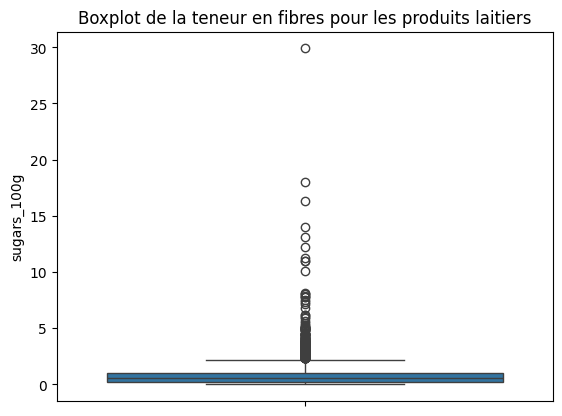

In [251]:
data = df_work2[df_work2['pnns_groups_1'] == 'Fish Meat Eggs']['sugars_100g']

# Créer le boxplot avec seaborn
sns.boxplot(data=data)

# Ajouter un titre
plt.title("Boxplot de la teneur en fibres pour les produits laitiers")
#plt.yscale('log')
# Afficher le boxplot
plt.show()

In [252]:
df_work2[(df_work2['pnns_groups_1'] == 'Fish Meat Eggs') & (df_work2['sugars_100g'] >3)]

product_name  \
209407  Bâtonnets de la mer goût Crabe (28 Bâtonnets)   
204360    Bâtonnets Saveur Crabe (24 bâtonnets) 405 g   
310305    Fuet Extra aux Figues - Tradition Espagnole   
310300         Salami Gourmet Poivre Moitié Sous vide   
312128   Chorizo Pur Porc (Fort) au Piment d'Espagne    
...                                               ...   
224849    Brioche au véritable saucisson cuit de Lyon   
230052                             Paupiettes de Veau   
204457                               Feuilles de nori   
106147                          Chinese Style Sausage   
275876                                         Surimi   

                              brands   pnns_groups_1 nutrition_grade_fr  \
209407                             U  Fish Meat Eggs                  c   
204360  Carrefour Discount,Carrefour  Fish Meat Eggs                  c   
310305                        Soélia  Fish Meat Eggs                  e   
310300                        Soélia  Fish Meat Eggs                  e   
312128                           Dia  Fish Meat Eggs                  e   
...                              ...             ...                ...   
224849                         Randy  Fish Meat Eggs                  e   
230052                     Tendriade  Fish Meat Eggs                  d   
204457                          Ming  Fish Meat Eggs                  e   
106147                Flamingo brand  Fish Meat Eggs                NaN   
275876                     Carrefour  Fish Meat Eggs                NaN   

        energy_100g  proteins_100g  salt_100g  sodium_100g  sugars_100g  \
209407        491.0            7.4     1.7800     0.700787         3.40   
204360        477.0            8.4     1.4986     0.590000         3.80   
310305       1736.0           22.3     2.9000     1.141732        13.10   
310300       1680.0           14.3     3.9000     1.535433         4.50   
312128       2155.0           18.1     4.8260     1.900000         3.20   
...             ...            ...        ...          ...          ...   
224849       1431.0           12.0     1.6000     0.629921         3.30   
230052        891.0            0.7     0.9800     0.385827         4.20   
204457       1774.0           49.5     1.5000     0.590551        29.90   
106147          NaN           21.2     4.0800     1.610000        10.10   
275876        418.0            NaN     1.5300     0.602000         5.88   

        carbohydrates_100g  fat_100g  saturated-fat_100g  fiber_100g  \
209407                12.1      4.30                0.40        0.00   
204360                12.6      3.20                1.21        0.50   
310305                14.2     30.10               11.00        4.00   
310300                 5.0     36.60               13.00        2.01   
312128                 4.2     48.00               18.00        0.00   
...                    ...       ...                 ...         ...   
224849                 NaN       NaN               10.00        0.00   
230052                 NaN       NaN                6.60        0.00   
204457                 NaN       NaN                5.30        0.00   
106147                13.1     38.40               14.10        3.03   
275876                 NaN      2.94                2.94         NaN   

        nutrition-score-fr_100g  nb_valeurs  
209407                      4.0          12  
204360                      3.0          12  
310305                     22.0          12  
310300                     23.0          12  
312128                     26.0          12  
...                         ...         ...  
224849                     19.0          10  
230052                     12.0          10  
204457                     22.0          10  
106147                      NaN           9  
275876                      NaN           7  

[179 rows x 15 columns]

#### médiane

In [253]:
df_work2.isna().sum()

product_name                    0
brands                       4621
pnns_groups_1              192663
nutrition_grade_fr          56020
energy_100g                 21021
proteins_100g               22070
salt_100g                   26006
sodium_100g                 26045
sugars_100g                 35227
carbohydrates_100g          37903
fat_100g                    37583
saturated-fat_100g          48846
fiber_100g                  74989
nutrition-score-fr_100g     56020
nb_valeurs                      0
dtype: int64

In [254]:
df_work2.columns

Index(['product_name', 'brands', 'pnns_groups_1', 'nutrition_grade_fr',
       'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
       'fiber_100g', 'nutrition-score-fr_100g', 'nb_valeurs'],
      dtype='object')

In [255]:
df_work2.shape

(258053, 15)

<BarContainer object of 12 artists>

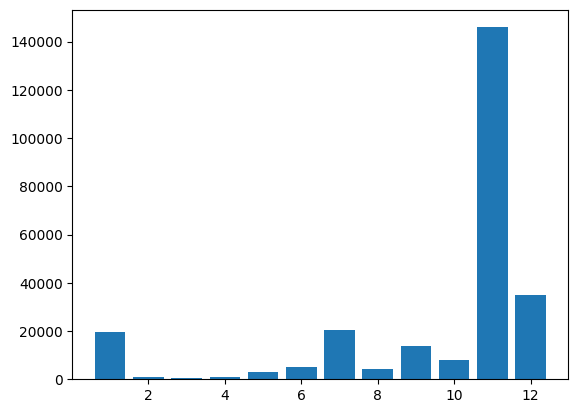

In [256]:
effect = df_work2['nb_valeurs'].value_counts()
plt.bar(effect.index, effect.values)

In [257]:
df_work2['nb_valeurs'].value_counts()

nb_valeurs
11    145966
12     34760
7      20563
1      19617
9      13976
10      7983
6       5282
8       4396
5       3070
4        967
2        746
3        727
Name: count, dtype: int64

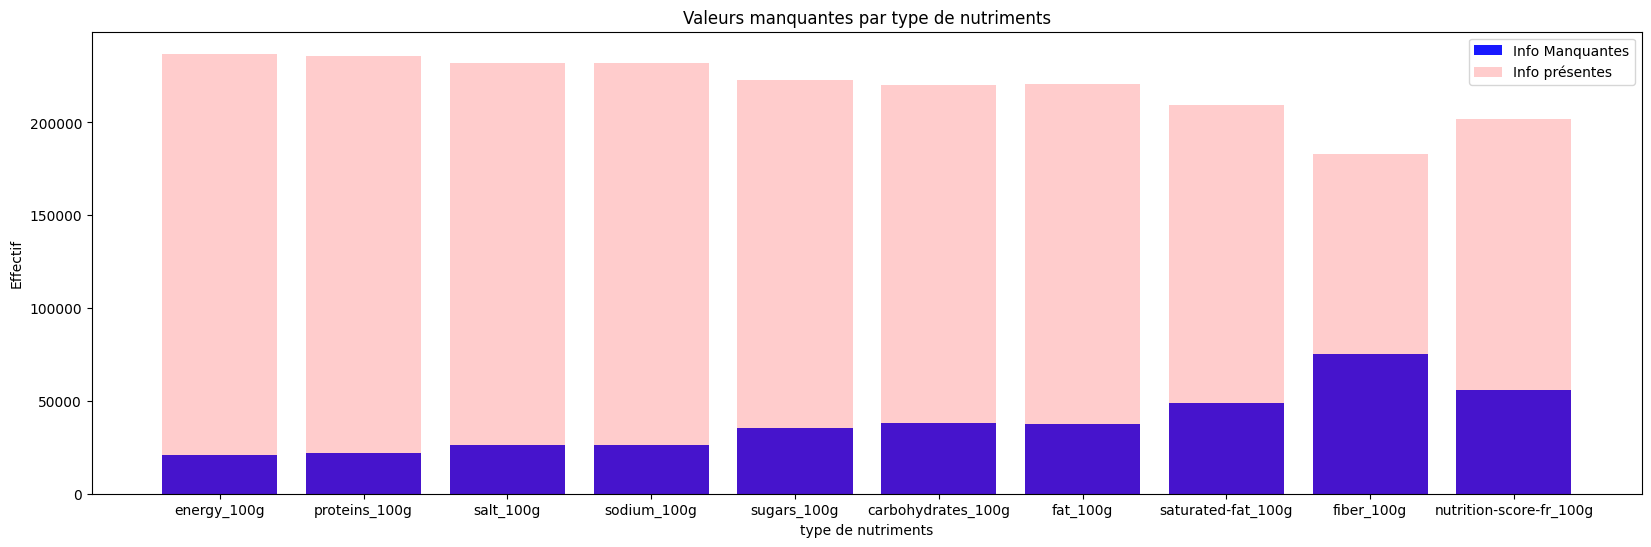

In [258]:
info_manquantes  = df_work2[df_work2.columns[4:-1]].isna().sum()
info_presentes  = df_work2[df_work2.columns[4:-1]].notna().sum()

# Définir la taille de la figure
plt.figure(figsize=(20, 6)) 
plt.bar(info_manquantes.index, info_manquantes.values, color='blue', alpha=0.9, label='Info Manquantes')

plt.bar(info_presentes.index, info_presentes.values, color='red', alpha=0.2, label='Info présentes')

# Ajout de titres et de labels d'axes
plt.title('Valeurs manquantes par type de nutriments')
plt.xlabel('type de nutriments')
plt.ylabel('Effectif')

plt.legend()

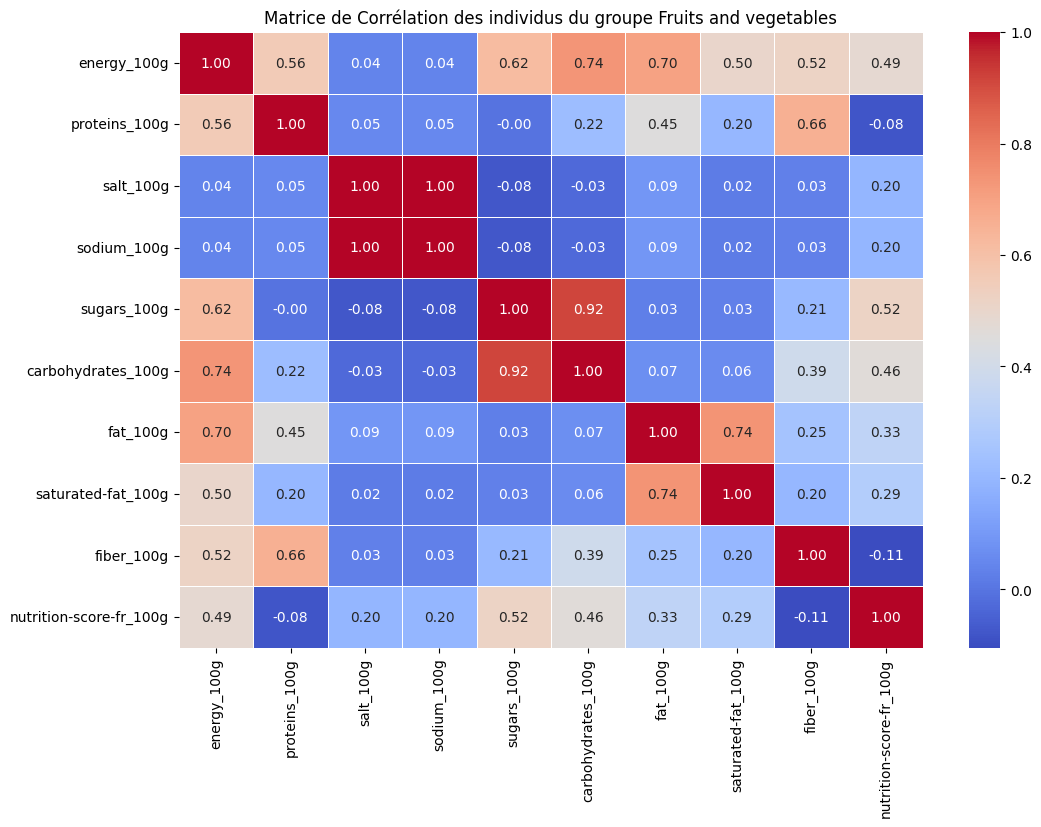

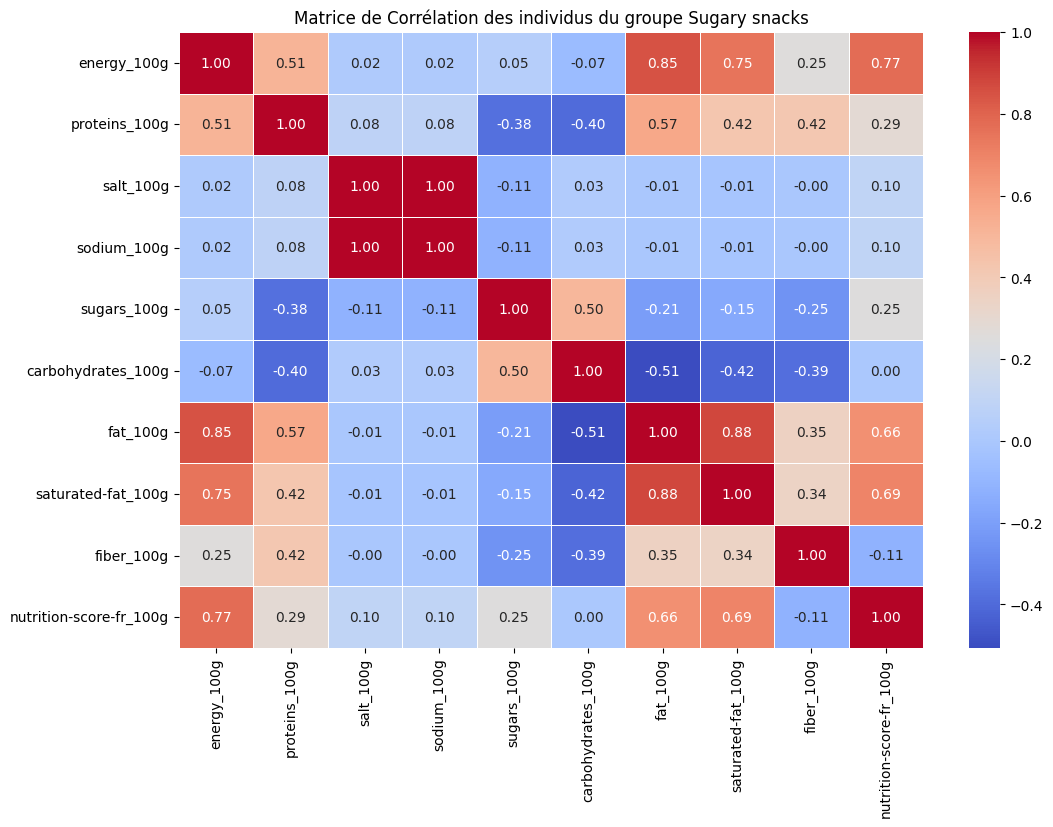

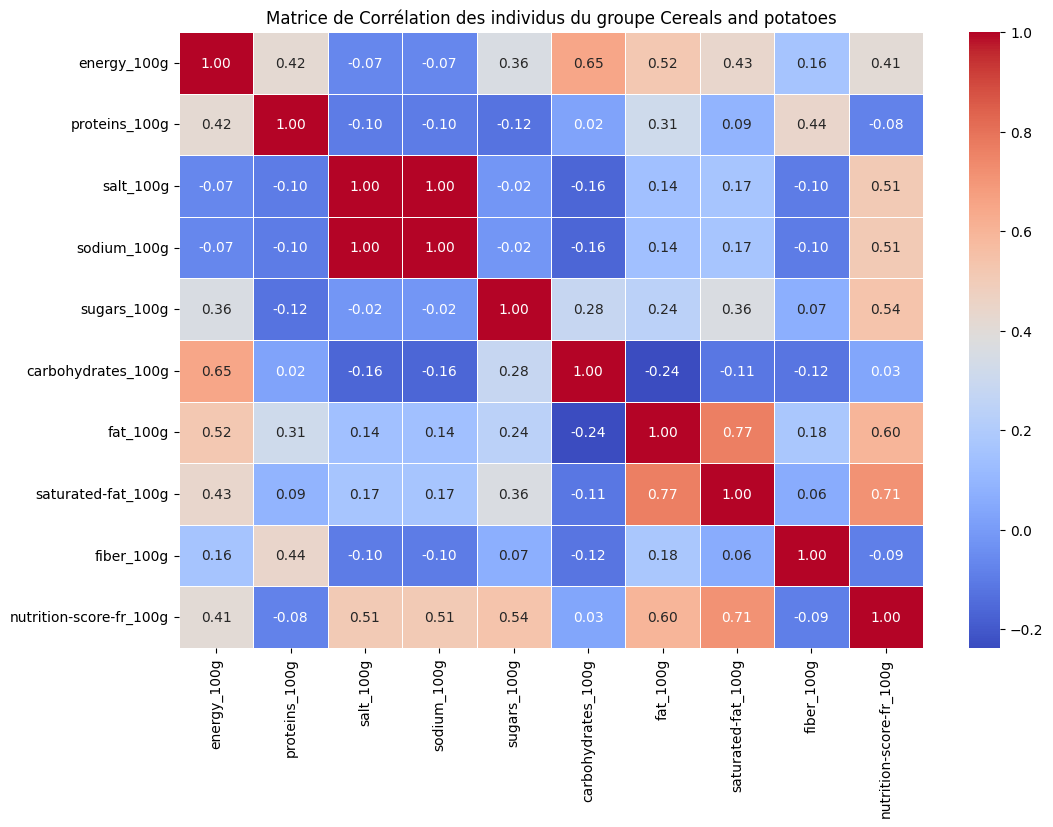

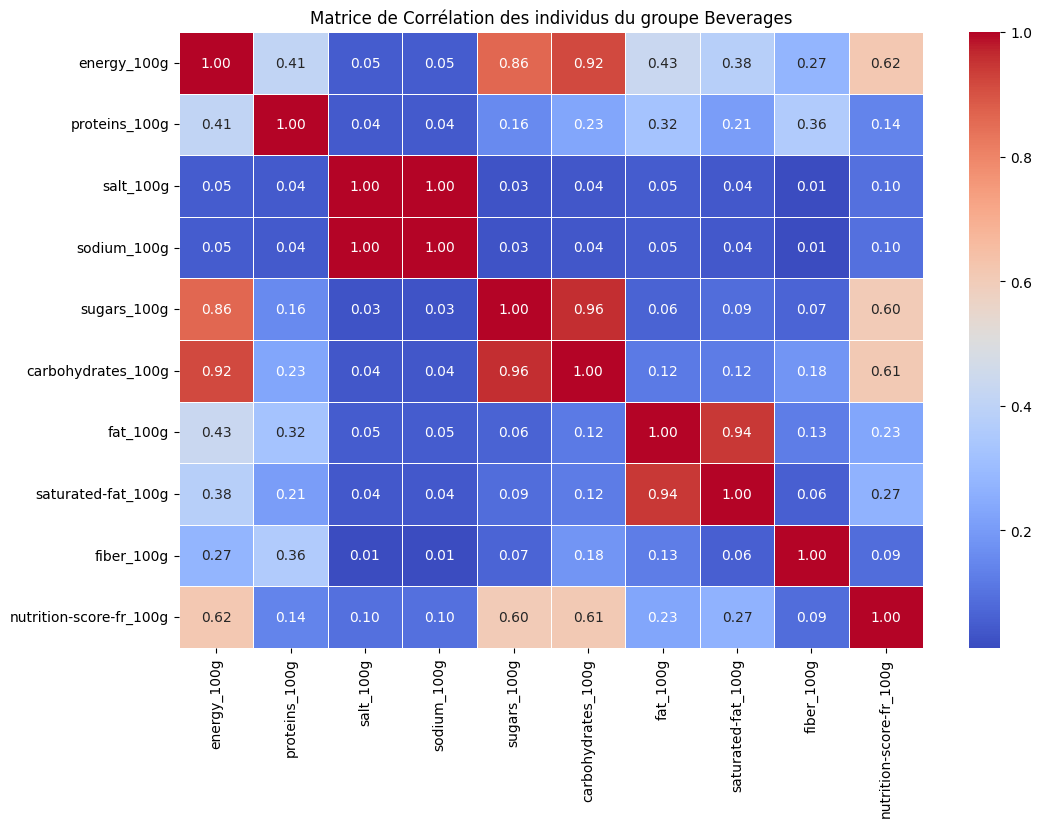

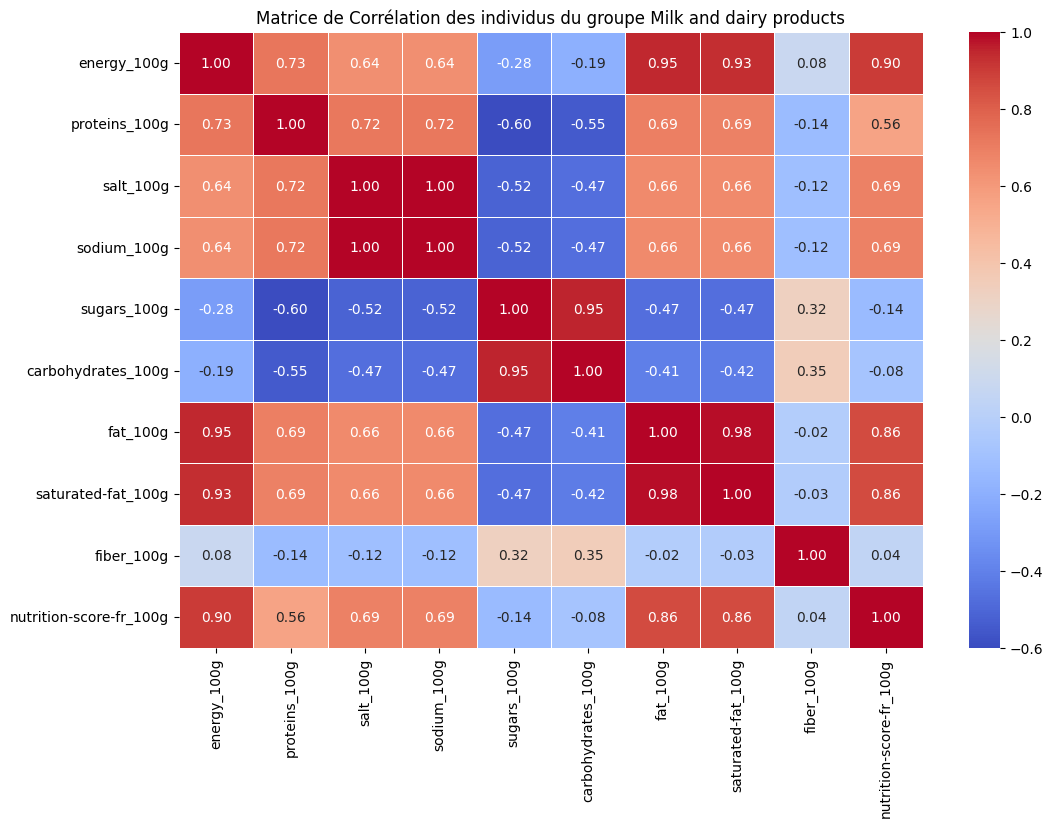

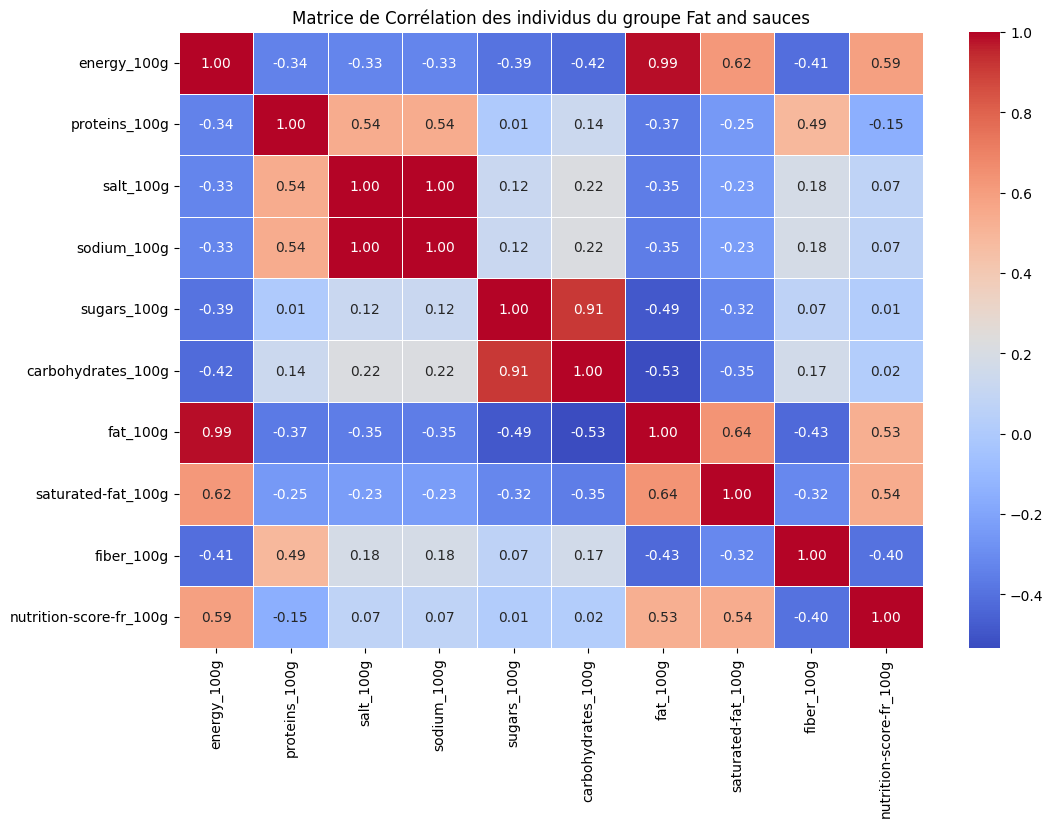

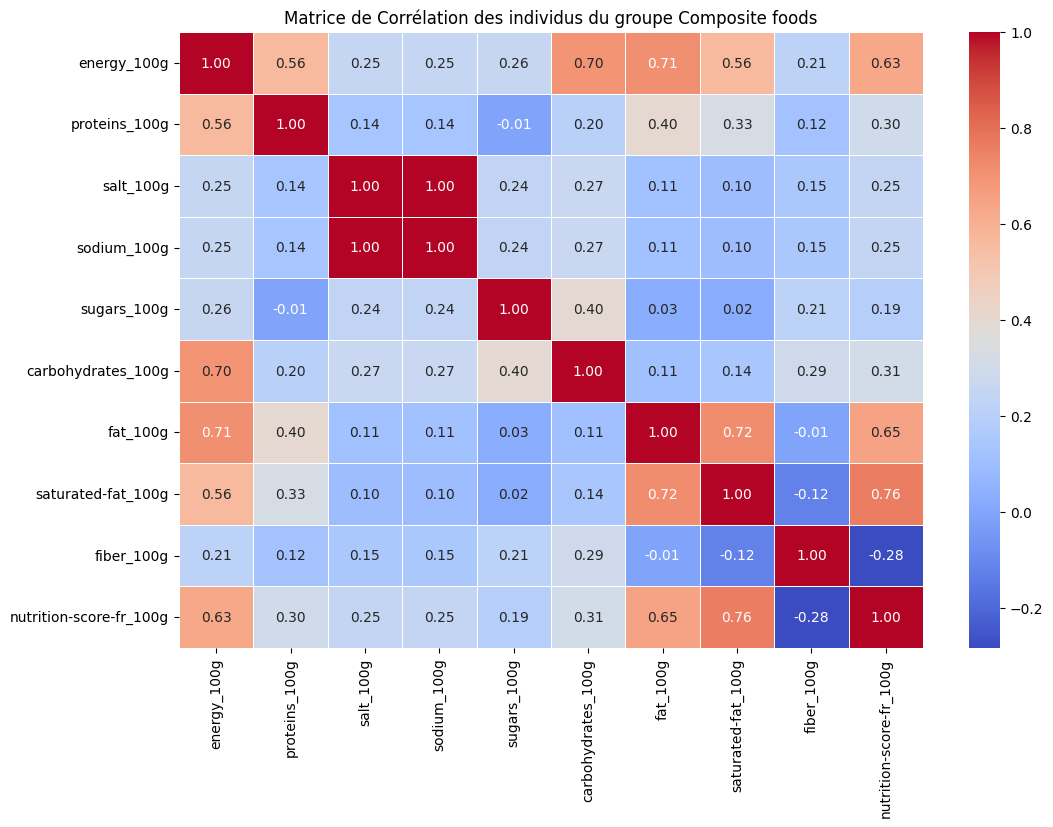

/home/alexandre/anaconda3/envs/stabadenvP3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/alexandre/anaconda3/envs/stabadenvP3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


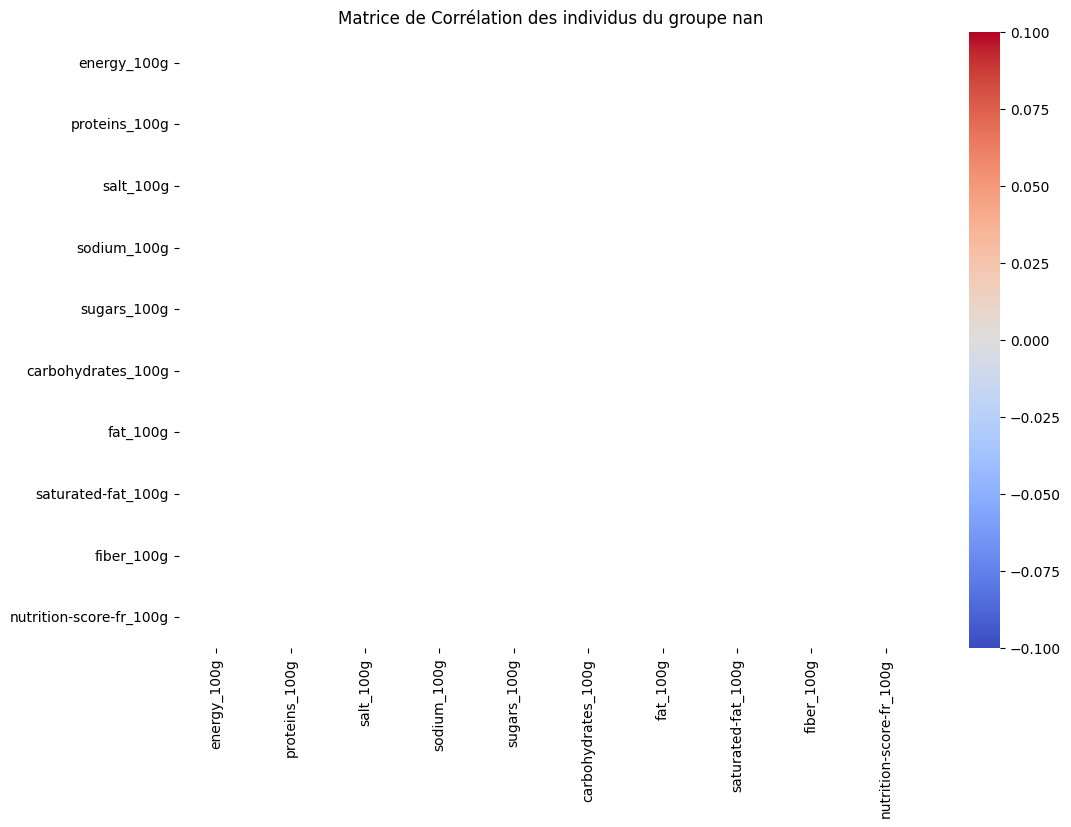

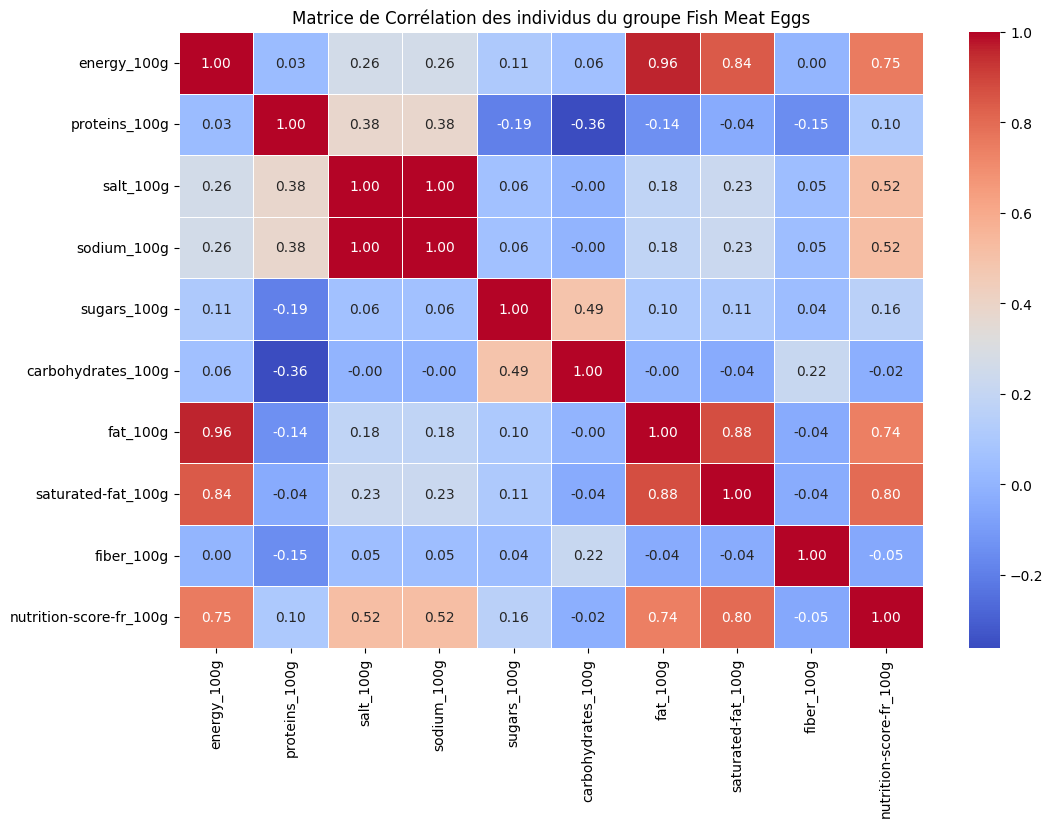

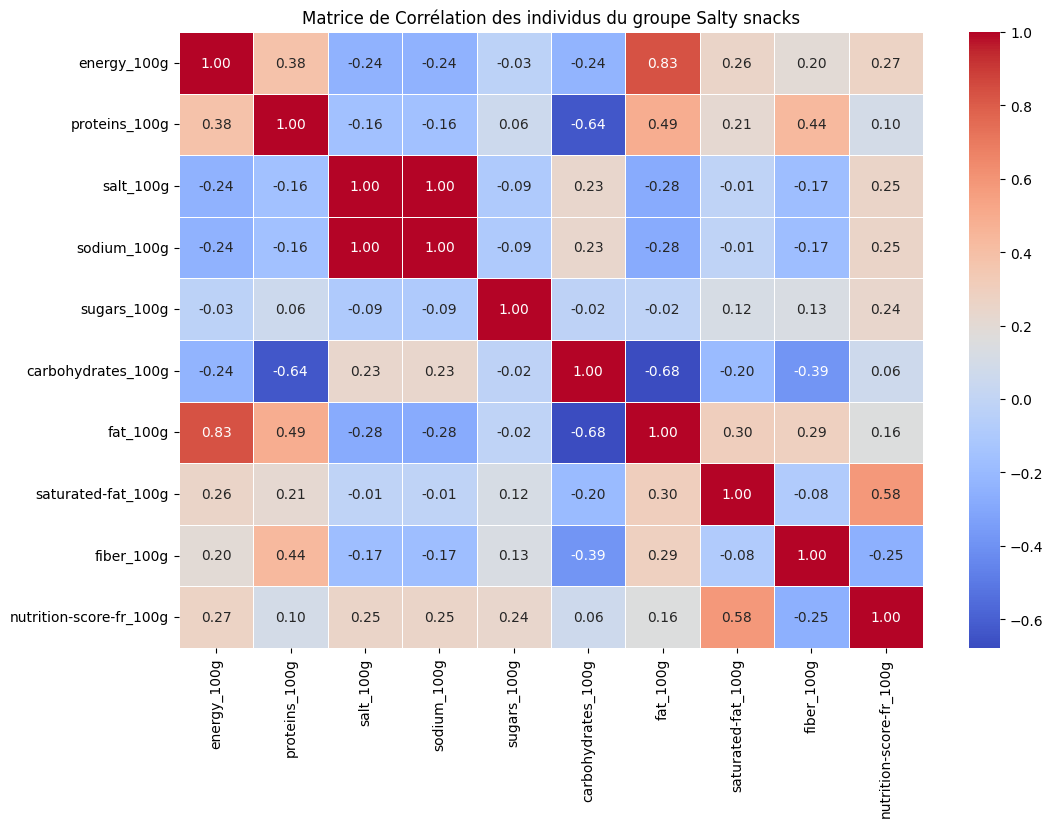

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt
for categorie in df_work2['pnns_groups_1'].unique():
    # Créer la matrice de corrélation
    correlation_matrix = df_work2[df_work2['pnns_groups_1']==categorie][df_work2.columns[4:-1]].corr()
    
    # Créer une figure
    plt.figure(figsize=(12, 8))
    
    # Utiliser Seaborn pour dessiner la matrice de corrélation sous forme de heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    
    # Ajouter un titre
    plt.title(f'Matrice de Corrélation des individus du groupe {categorie}')
    
    # Afficher le plot
    plt.show()


In [260]:
df_work2

product_name  \
175609                Piña &quot;Agropen&quot;   
204933                    Cookies Nougat' Choc   
202210  Burger Gourmand aux graines & céréales   
204930                      Sirop de grenadine   
202208              Longue Conservation nature   
...                                        ...   
250606        Le Haché 100 % canard assaisonné   
250607                                 Endives   
250609                       Pur jus de pommes   
250771                          Basilic Grande   
215598                          Miel de fleurs   

                                        brands          pnns_groups_1  \
175609  Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
204933                                Chabrior          Sugary snacks   
202210                          Harrys,Barilla   Cereals and potatoes   
204930                                 Paquito              Beverages   
202208                                  Harrys   Cereals and potatoes   
...                                        ...                    ...   
250606                          Les Thomasines         Fish Meat Eggs   
250607                                 En'Diva  Fruits and vegetables   
250609                     Le petit producteur              Beverages   
250771                               Pronatura                    NaN   
215598                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
175609                  a        209.0            1.0    0.00000        0.000   
204933                  e       2117.0            5.8    1.21920        0.480   
202210                  a       1118.0           10.3    1.09982        0.433   
204930                  e       1376.0            1.6    0.00254        0.001   
202208                  c       1201.0            9.5    1.32842        0.523   
...                   ...          ...            ...        ...          ...   
250606                NaN          NaN            NaN        NaN          NaN   
250607                NaN          NaN            NaN        NaN          NaN   
250609                NaN          NaN            NaN        NaN          NaN   
250771                NaN          NaN            NaN        NaN          NaN   
215598                NaN          NaN            NaN        NaN          NaN   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
175609         10.0                14.0       0.0                 0.0   
204933         27.8                61.1      26.0                13.1   
202210          2.8                44.9       3.7                 0.6   
204930         77.6                77.6       0.8                 0.1   
202208          6.0                51.8       4.1                 2.4   
...             ...                 ...       ...                 ...   
250606          NaN                 NaN       NaN                 NaN   
250607          NaN                 NaN       NaN                 NaN   
250609          NaN                 NaN       NaN                 NaN   
250771          NaN                 NaN       NaN                 NaN   
215598          NaN                 NaN       NaN                 NaN   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
175609         4.0                     -8.0          12  
204933         2.2                     24.0          12  
202210         5.3                     -3.0          12  
204930         0.5                     20.0          12  
202208         2.4                      8.0          12  
...            ...                      ...         ...  
250606         NaN                      NaN           1  
250607         NaN                      NaN           1  
250609         NaN                      NaN           1  
250771         NaN                      NaN           1  
215598         NaN                      NaN           1  

[258053 r

In [261]:
df_work2.shape

(258053, 15)

In [262]:
df_work2.isna().sum()

product_name                    0
brands                       4621
pnns_groups_1              192663
nutrition_grade_fr          56020
energy_100g                 21021
proteins_100g               22070
salt_100g                   26006
sodium_100g                 26045
sugars_100g                 35227
carbohydrates_100g          37903
fat_100g                    37583
saturated-fat_100g          48846
fiber_100g                  74989
nutrition-score-fr_100g     56020
nb_valeurs                      0
dtype: int64

### Remplissage par Iterative Imputer

 - Avantages :
   - Tient compte des relations entre les variables en utilisant une méthode itérative.
   - Peut être plus précis que le remplissage par valeurs constantes.
   - Gère les valeurs manquantes de manière plus sophistiquée.

 - Inconvénients :
   - Plus complexe à mettre en œuvre.
   - Plus de temps de calcul nécessaire.
   - Sensible aux valeurs aberrantes et aux données non linéaires.

#### remplissage total du dataframe avec l'iterative imputer

In [263]:
#copie du dataframe de travail
df_work2_bis = df_work2.copy()

# Sélection des colonnes numériques
df_work2_numeric = df_work2_bis.select_dtypes(include=[np.number])

# Création de l'instance IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

# Entraînement du modèle sur les données numériques
imp.fit(df_work2_numeric)

# Imputation des valeurs manquantes dans les données numériques du DataFrame d'origine
df_work2_bis[df_work2_numeric.columns] = imp.fit_transform(df_work2_numeric)

In [264]:
# Affichage du DataFrame imputé
df_work2_bis['proteins_100g'].isna().sum()

0

In [265]:
df_work2['proteins_100g'].isna().sum()

22070

#### remplissage d'une seule variable cible avec ses features corrélées

les valeurs pour la feature proteins_100g des individus marqués dans la catégorie Milk and Dairy products sont fortement corrélés avec les features energy_100g, salt_100g et fat_100g

utilisons ces valeurs pour prédire la colonne proteins puis comparons les résultats avec la méthode précédente 

In [266]:
df_work2_ter = df_work2.copy()

df_work2_ter = df_work2_ter[df_work2_ter['pnns_groups_1'] == "Milk and dairy products"]

from sklearn.impute import SimpleImputer

# Sélection des colonnes nécessaires pour l'imputation
columns_for_imputation = ['energy_100g', 'salt_100g', 'fat_100g', 'proteins_100g']

# Extraction des données pour l'imputation
data_for_imputation = df_work2_ter[columns_for_imputation]

# Création de l'instance de l'imputeur
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Imputation des valeurs manquantes
imputed_values = imp.fit_transform(data_for_imputation)

# Remplacement des valeurs imputées dans le DataFrame original
df_work2_ter['proteins_100g'] = imputed_values[:, 3]  # La colonne 'proteins_100g' est à l'indice 3 dans imputed_values


In [267]:
df_work2_ter.describe()

energy_100g  proteins_100g    salt_100g  sodium_100g  sugars_100g  \
count  7236.000000    8494.000000  6747.000000  6746.000000  6717.000000   
mean    815.345522       9.653637     0.677646     0.266830     7.634871   
std     496.699274       8.078891     0.829160     0.326449     8.001201   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%     372.000000       3.300000     0.101600     0.040000     0.800000   
50%     676.500000       6.900000     0.152400     0.060000     4.700000   
75%    1243.000000      14.000000     1.300000     0.511811    13.000000   
max    2448.000000      52.200000     9.652000     3.800000    91.000000   

       carbohydrates_100g     fat_100g  saturated-fat_100g   fiber_100g  \
count         6902.000000  7283.000000         6753.000000  3128.000000   
mean             8.918180    13.967858            9.155958     0.405435   
std              9.656374    11.826579            8.052547     0.903144   
min              0.000000     0.000000            0.000000     0.000000   
25%              1.500000     3.000000            1.900000     0.000000   
50%              4.800000    10.000000            6.000000     0.000000   
75%             14.000000    25.000000           17.000000     0.500000   
max             95.000000    60.000000           43.100000    24.000000   

       nutrition-score-fr_100g   nb_valeurs  
count              6644.000000  8494.000000  
mean                  8.145545     9.476454  
std                   6.811766     3.783322  
min                  -6.000000     1.000000  
25%                   2.000000    11.000000  
50%                   8.000000    11.000000  
75%                  14.000000    12.000000  
max                  30.000000    12.000000

In [268]:
df_work2.describe()

energy_100g  proteins_100g      salt_100g    sodium_100g  \
count  237032.000000  235983.000000  232047.000000  232008.000000   
mean     1118.079247       7.078799       1.605682       0.632263   
std       786.870195       8.073821       6.284254       2.474302   
min         0.000000       0.000000       0.000000       0.000000   
25%       382.775000       0.700000       0.063500       0.025000   
50%      1096.000000       4.800000       0.591820       0.233000   
75%      1670.000000      10.000000       1.381760       0.544000   
max      4000.000000     100.000000     100.000000      39.370079   

         sugars_100g  carbohydrates_100g       fat_100g  saturated-fat_100g  \
count  222826.000000       220150.000000  220470.000000       209207.000000   
mean       15.733676           32.025061      12.537453            5.083836   
std        20.928711           29.045646      17.188183            7.903319   
min         0.000000            0.000000       0.000000            0.000000   
25%         1.280000            6.000000       0.000000            0.000000   
50%         5.500000           20.590000       5.000000            1.790000   
75%        23.530000           58.140000      20.000000            7.140000   
max       100.000000          100.000000     100.000000          100.000000   

          fiber_100g  nutrition-score-fr_100g     nb_valeurs  
count  183064.000000            202033.000000  258053.000000  
mean        2.823858                 9.074013       9.616897  
std         4.582908                 9.041357       3.006264  
min         0.000000               -15.000000       1.000000  
25%         0.000000                 1.000000       9.000000  
50%         1.500000                10.000000      11.000000  
75%         3.600000                16.000000      11.000000  
max       100.000000                40.000000      12.000000

In [269]:
#colonne proteins itérée selon ttes les features
df_work2_total = df_work2_bis[df_work2_bis['pnns_groups_1']=='Milk and dairy products']['proteins_100g']
df_work2_total.describe()

count    8494.000000
mean        8.250761
std         8.749107
min        -0.881495
25%         2.800000
50%         3.800000
75%        14.000000
max        52.200000
Name: proteins_100g, dtype: float64

In [270]:
df_work2_corr = df_work2_ter['proteins_100g']
df_work2_corr.describe()

count    8494.000000
mean        9.653637
std         8.078891
min         0.000000
25%         3.300000
50%         6.900000
75%        14.000000
max        52.200000
Name: proteins_100g, dtype: float64

In [271]:
df_work2_original = df_work2[df_work2['pnns_groups_1']=='Milk and dairy products']['proteins_100g']
df_work2_original  = df_work2_original.dropna()

#### comparaison des méthodes

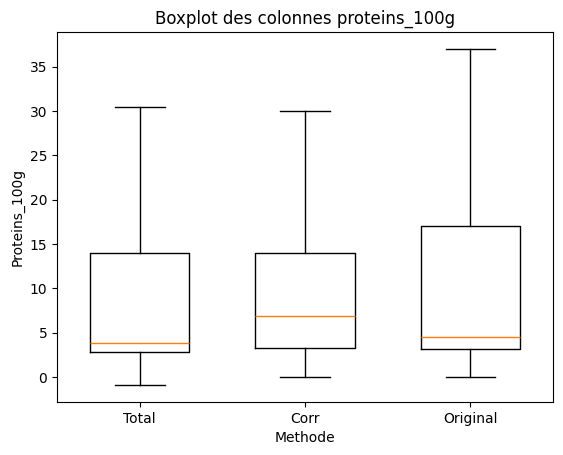

In [272]:
# Création d'une liste contenant les DataFrames
dataframes = [df_work2_total, df_work2_corr, df_work2_original]

# Création d'une liste contenant les noms correspondants pour la légende
labels = ['Total', 'Corr', 'Original']

# Création de la figure et des axes
fig, ax = plt.subplots()

# Tracé des boxplots pour chaque DataFrame
for i in range(len(dataframes)):
    ax.boxplot(dataframes[i].values, positions=[i+1], widths=0.6, showfliers=False)

# Réglage des étiquettes d'axe x
ax.set_xticklabels(labels)

# Titre et étiquettes des axes
plt.title('Boxplot des colonnes proteins_100g')
plt.xlabel('Methode')
plt.ylabel('Proteins_100g')

# Affichage du graphique
plt.show()


#### commentaire

On remarque que les valeurs imputées par les méthodes d'imputation selon toutes les features ou bien pour seulement des features choisies selon la corrélation sont relativement proches des valeurs originales

### Remplissage par KNN

 - Avantages :
    - Utilise l'information des voisins les plus proches pour estimer les valeurs manquantes.
    - Peut être plus précis que d'autres méthodes, surtout si les données sont bien regroupées.

 - Inconvénients :
    - Sensible à la dimensionnalité élevée des données.
    - Plus de temps de calcul nécessaire, surtout avec de grands ensembles de données.
    - Nécessite de définir le nombre de voisins K.


#### Imputation des valeurs numériques

In [273]:
# Création du DataFrame df_work3 en excluant les colonnes non numériques et la colonne nb_valeurs
df_work3 = df_work2[['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                      'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                      'fiber_100g', 'nutrition-score-fr_100g']].copy()

# Création de l'instance de l'imputeur kNN
imputer = KNNImputer(n_neighbors=5)

# Imputation des valeurs manquantes dans df_work3
df_work3_imputed = pd.DataFrame(imputer.fit_transform(df_work3), columns=df_work3.columns)


In [274]:
 df_work3_imputed.isnull().sum()

energy_100g                0
proteins_100g              0
salt_100g                  0
sodium_100g                0
sugars_100g                0
carbohydrates_100g         0
fat_100g                   0
saturated-fat_100g         0
fiber_100g                 0
nutrition-score-fr_100g    0
dtype: int64

In [275]:
df_work3.describe()

energy_100g  proteins_100g      salt_100g    sodium_100g  \
count  237032.000000  235983.000000  232047.000000  232008.000000   
mean     1118.079247       7.078799       1.605682       0.632263   
std       786.870195       8.073821       6.284254       2.474302   
min         0.000000       0.000000       0.000000       0.000000   
25%       382.775000       0.700000       0.063500       0.025000   
50%      1096.000000       4.800000       0.591820       0.233000   
75%      1670.000000      10.000000       1.381760       0.544000   
max      4000.000000     100.000000     100.000000      39.370079   

         sugars_100g  carbohydrates_100g       fat_100g  saturated-fat_100g  \
count  222826.000000       220150.000000  220470.000000       209207.000000   
mean       15.733676           32.025061      12.537453            5.083836   
std        20.928711           29.045646      17.188183            7.903319   
min         0.000000            0.000000       0.000000            0.000000   
25%         1.280000            6.000000       0.000000            0.000000   
50%         5.500000           20.590000       5.000000            1.790000   
75%        23.530000           58.140000      20.000000            7.140000   
max       100.000000          100.000000     100.000000          100.000000   

          fiber_100g  nutrition-score-fr_100g  
count  183064.000000            202033.000000  
mean        2.823858                 9.074013  
std         4.582908                 9.041357  
min         0.000000               -15.000000  
25%         0.000000                 1.000000  
50%         1.500000                10.000000  
75%         3.600000                16.000000  
max       100.000000                40.000000

In [276]:
df_work3_imputed.describe()

energy_100g  proteins_100g      salt_100g    sodium_100g  \
count  258053.000000  258053.000000  258053.000000  258053.000000   
mean     1117.942822       7.071034       1.595491       0.626742   
std       755.897835       7.741228       5.991474       2.351299   
min         0.000000       0.000000       0.000000       0.000000   
25%       422.000000       0.900000       0.090000       0.035433   
50%      1118.079247       5.560000       0.701040       0.277000   
75%      1636.000000       9.520000       1.605682       0.632263   
max      4000.000000     100.000000     100.000000      39.370079   

         sugars_100g  carbohydrates_100g       fat_100g  saturated-fat_100g  \
count  258053.000000       258053.000000  258053.000000       258053.000000   
mean       15.118925           31.523598      12.258321            4.630689   
std        19.783277           27.261597      16.149491            7.334251   
min         0.000000            0.000000       0.000000            0.000000   
25%         1.260000            7.030000       0.160000            0.000000   
50%         6.670000           25.170000       6.800000            1.790000   
75%        20.000000           53.850000      17.800000            5.800000   
max       100.000000          100.000000     100.000000          100.000000   

          fiber_100g  nutrition-score-fr_100g  
count  258053.000000            258053.000000  
mean        2.552557                 8.932781  
std         4.116751                 8.455487  
min         0.000000               -15.000000  
25%         0.000000                 1.800000  
50%         1.400000                 9.074013  
75%         3.200000                15.000000  
max       100.000000                40.000000

#### Scoring du modèle KNN

In [277]:
#selection du dataset qui contient 10 valeurs renseignées sur 10 pour les colonnes nutritionnelles

nb_val_num = df_work2[['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g','fiber_100g', 'nutrition-score-fr_100g']].notna().sum(axis=1)
df_work2['nb_valeurs'] = nb_val_num
df_score = df_work2[df_work2['nb_valeurs'] == 10].copy()
df_score

product_name  \
175609                           Piña &quot;Agropen&quot;   
204933                               Cookies Nougat' Choc   
202210             Burger Gourmand aux graines & céréales   
204930                                 Sirop de grenadine   
202208                         Longue Conservation nature   
...                                                   ...   
286358                                   Zwieback Classic   
286262                                          Blond pur   
286360                                    Venus papier A4   
286542                              Cractiv Chips Paprika   
286247  Villars Chocolat Liqueur Abricotine Tablette 100G   

                                        brands          pnns_groups_1  \
175609  Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
204933                                Chabrior          Sugary snacks   
202210                          Harrys,Barilla   Cereals and potatoes   
204930                                 Paquito              Beverages   
202208                                  Harrys   Cereals and potatoes   
...                                        ...                    ...   
286358                                  Roland                    NaN   
286262                                Villars                     NaN   
286360                          Roxcal, Roland                    NaN   
286542                                 Zweifel                    NaN   
286247                                 Villars                    NaN   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
175609                  a        209.0            1.0    0.00000     0.000000   
204933                  e       2117.0            5.8    1.21920     0.480000   
202210                  a       1118.0           10.3    1.09982     0.433000   
204930                  e       1376.0            1.6    0.00254     0.001000   
202208                  c       1201.0            9.5    1.32842     0.523000   
...                   ...          ...            ...        ...          ...   
286358                  d       1751.0           12.0   13.00000     5.118110   
286262                  e       2430.0            8.0    0.54000     0.212598   
286360                  d       1635.0           12.0    3.80000     1.496063   
286542                  c       1960.0            7.0    1.30000     0.511811   
286247                  e       2050.0            5.0    0.22000     0.086614   

        sugars_100g  carbohydrates_100g  fat_100g  saturated-fat_100g  \
175609         10.0                14.0       0.0                 0.0   
204933         27.8                61.1      26.0                13.1   
202210          2.8                44.9       3.7                 0.6   
204930         77.6                77.6       0.8                 0.1   
202208          6.0                51.8       4.1                 2.4   
...             ...                 ...       ...                 ...   
286358         15.0                74.0       7.0                 3.2   
286262         48.0                49.0      40.0                24.0   
286360          4.2                74.0       4.1                 1.7   
286542          9.0                60.0      21.0                 1.5   
286247         56.0                56.0      24.0                14.0   

        fiber_100g  nutrition-score-fr_100g  nb_valeurs  
175609         4.0                     -8.0          10  
204933         2.2                     24.0          10  
202210         5.3                     -3.0          10  
204930         0.5                     20.0          10  
202208         2.4                      8.0          10  
...            ...                      ...         ...  
286358         3.7                     16.0          10  
286262         0.0                     29.0          10  
286360         2.6                     12.0          10  
28654

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Diviser le dataframe en features (X) et la cible (y)
X = df_score[['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
              'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
              'fiber_100g', 'nutrition-score-fr_100g', 'nb_valeurs']]
y = df_score['nutrition_grade_fr']

# Diviser le jeu de données en ensembles d'entraînement et de test (80% pour l'entraînement et 20% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = knn.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))


Précision du modèle KNN : 87.66%


#### imputation par knn des valeurs qualitatives dans la colonne nutrition_grade_fr

In [279]:
#création d'un dataframe contenant les valeurs
df_work2_inter = df_work2.reset_index()[df_work2.columns[0:4]]

df_work2_imputed = pd.concat([df_work2_inter, df_work3_imputed], axis = 1)

Nous allons imputer les valeurs dans le df_work2_imputed pour la colonne nutrition_grade_fr en nous basant sur les valeurs dans les autres colonnes

In [280]:
df_work2_imputed['nutrition_grade_fr'].isna().sum()

56020

In [281]:
df_work2_imputed.columns


Index(['product_name', 'brands', 'pnns_groups_1', 'nutrition_grade_fr',
       'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
       'fiber_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [282]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                NaN  1118.079247       7.078799   1.605682     0.632263   
258049                NaN  1118.079247       7.078799   1.605682     0.632263   
258050                NaN  1118.079247       7.078799   1.605682     0.632263   
258051                NaN  1118.079247       7.078799   1.605682     0.632263   
258052                NaN  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  
0         4.000000                -8.000000  
1         2.200000                24.000000  
2         5.300000                -3.000000  
3         0.500000                20.000000  
4         2.400000                 8.000000  
...            ...                      ...  
258048    2.823858                 9.074013  
258049    2.823858                 9.074013  
258050    2.823858                 9.074013  
258051    2.823858                 9.074013  
258052    2.823858                 9.074013  

[258053 rows x 14 columns]

In [283]:
# Création d'un dictionnaire pour mapper les valeurs de 'nutrition_grade_fr' vers les valeurs numériques
grade_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}

# Ajout de la colonne 'nutrition_grade_fr_encoded' en appliquant le mapping
df_work2_imputed['nutrition_grade_fr_encoded'] = df_work2_imputed['nutrition_grade_fr'].map(grade_mapping)

In [284]:
# extraction du df pour l'imputation
df_knn_qual = df_work2_imputed[['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g','fiber_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr_encoded']]

#Filtrer les lignes où la valeur de 'nutrition_grade_fr_encoded' est présente
df_knn_qual_val = df_knn_qual[df_knn_qual['nutrition_grade_fr_encoded'].notnull()]

# Filtrer les lignes où la valeur de 'nutrition_grade_fr_encoded' est manquante
df_knn_qual_miss = df_knn_qual[df_knn_qual['nutrition_grade_fr_encoded'].isnull()]

# Séparation des features et de la cible pour le premier dataframe
X_train = df_knn_qual_val[['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                            'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                            'fiber_100g', 'nutrition-score-fr_100g']]
y_train = df_knn_qual_val['nutrition_grade_fr_encoded']

# Création d'un modèle KNN
knn_model = KNeighborsClassifier(n_neighbors=5) 

# Entraînement du modèle KNN sur les données disponibles
knn_model.fit(X_train, y_train)

# Sélection des features pour les prédictions dans le deuxième dataframe
X_test = df_knn_qual_miss[['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                            'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                            'fiber_100g', 'nutrition-score-fr_100g']]

# Prédiction des valeurs manquantes dans la colonne 'nutrition_grade_fr_encoded'
y_pred = knn_model.predict(X_test)

# Remplacement des valeurs manquantes dans le deuxième dataframe avec les prédictions
df_knn_qual_miss['nutrition_grade_fr_encoded'] = y_pred

# Maintenant, df_knn_qual_miss contient les valeurs prédites pour la colonne 'nutrition_grade_fr_encoded'

df_knn_qual_miss['nutrition_grade_fr_encoded']




/tmp/ipykernel_24391/992790926.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knn_qual_miss['nutrition_grade_fr_encoded'] = y_pred


180790    5.0
180791    5.0
180797    4.0
180810    1.0
180816    4.0
         ... 
258048    4.0
258049    4.0
258050    4.0
258051    4.0
258052    4.0
Name: nutrition_grade_fr_encoded, Length: 56020, dtype: float64

In [285]:
df_knn_qual_miss


energy_100g  proteins_100g  salt_100g  sodium_100g  sugars_100g  \
180790  1351.000000       3.300000  36.300000    14.291339     4.400000   
180791  1297.000000       5.900000  39.000000    15.354331     0.700000   
180797  1449.000000      10.000000   8.200000     3.228346    20.200000   
180810    75.000000       1.200000   1.000000     0.393701     1.200000   
180816   800.000000       7.500000  50.038000    19.700000    13.000000   
...             ...            ...        ...          ...          ...   
258048  1118.079247       7.078799   1.605682     0.632263    15.733676   
258049  1118.079247       7.078799   1.605682     0.632263    15.733676   
258050  1118.079247       7.078799   1.605682     0.632263    15.733676   
258051  1118.079247       7.078799   1.605682     0.632263    15.733676   
258052  1118.079247       7.078799   1.605682     0.632263    15.733676   

        carbohydrates_100g   fat_100g  saturated-fat_100g  fiber_100g  \
180790           27.000000  20.000000           10.400000    3.300000   
180791           31.100000  17.900000            7.900000    0.700000   
180797           53.500000   7.500000            6.400000   11.600000   
180810            1.700000   0.600000            0.000000    0.400000   
180816           29.000000   4.500000            0.500000    1.000000   
...                    ...        ...                 ...         ...   
258048           32.025061  12.537453            5.083836    2.823858   
258049           32.025061  12.537453            5.083836    2.823858   
258050           32.025061  12.537453            5.083836    2.823858   
258051           32.025061  12.537453            5.083836    2.823858   
258052           32.025061  12.537453            5.083836    2.823858   

        nutrition-score-fr_100g  nutrition_grade_fr_encoded  
180790                18.000000                         5.0  
180791                21.600000                         5.0  
180797                12.600000                         4.0  
180810                -0.200000                         1.0  
180816                16.000000                         4.0  
...                         ...                         ...  
258048                 9.074013                         4.0  
258049                 9.074013                         4.0  
258050                 9.074013                         4.0  
258051                 9.074013                         4.0  
258052                 9.074013                         4.0  

[56020 rows x 11 columns]

In [286]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                NaN  1118.079247       7.078799   1.605682     0.632263   
258049                NaN  1118.079247       7.078799   1.605682     0.632263   
258050                NaN  1118.079247       7.078799   1.605682     0.632263   
258051                NaN  1118.079247       7.078799   1.605682     0.632263   
258052                NaN  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  nutrition_grade_fr_encoded  
0         4.000000                -8.000000                         1.0  
1         2.200000                24.000000                         5.0  
2         5.300000                -3.000000                         1.0  
3         0.500000                20.000000                         5.0  
4         2.400000                 8.000000                         3.0  
...            ...                      ...                         ...  
258048    2.823858                 9.074013                         NaN  
258049    2.823858                 9.074013                         NaN  
258050    2.823858          

In [287]:

# Récupérer les index des individus avec des valeurs dans df_knn_qual_miss
indexes_with_values = df_knn_qual_miss.index

# Mettre à jour les valeurs NaN dans df_work2_imputed en utilisant les valeurs de df_knn_qual_miss
for index in indexes_with_values:
    value_to_assign = df_knn_qual_miss.loc[index, 'nutrition_grade_fr_encoded']
    df_work2_imputed.loc[index, 'nutrition_grade_fr_encoded'] = value_to_assign

# Maintenant, df_work2_imputed contient les valeurs mises à jour de 'nutrition_grade_fr_encoded' correspondant aux individus de df_knn_qual_miss



In [288]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                NaN  1118.079247       7.078799   1.605682     0.632263   
258049                NaN  1118.079247       7.078799   1.605682     0.632263   
258050                NaN  1118.079247       7.078799   1.605682     0.632263   
258051                NaN  1118.079247       7.078799   1.605682     0.632263   
258052                NaN  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  nutrition_grade_fr_encoded  
0         4.000000                -8.000000                         1.0  
1         2.200000                24.000000                         5.0  
2         5.300000                -3.000000                         1.0  
3         0.500000                20.000000                         5.0  
4         2.400000                 8.000000                         3.0  
...            ...                      ...                         ...  
258048    2.823858                 9.074013                         4.0  
258049    2.823858                 9.074013                         4.0  
258050    2.823858          

In [289]:
# Créer un dictionnaire de mapping des valeurs
mapping_dict = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e'}

# Remplacer les valeurs NaN dans la colonne 'nutrition_grade_fr' en fonction des valeurs de 'nutrition_grade_fr_encoded'
df_work2_imputed['nutrition_grade_fr'] = df_work2_imputed['nutrition_grade_fr_encoded'].map(mapping_dict).fillna(df_work2_imputed['nutrition_grade_fr'])

# Maintenant, les valeurs NaN dans la colonne 'nutrition_grade_fr' sont remplacées par les lettres correspondantes aux valeurs de 'nutrition_grade_fr_encoded'


In [290]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                  d  1118.079247       7.078799   1.605682     0.632263   
258049                  d  1118.079247       7.078799   1.605682     0.632263   
258050                  d  1118.079247       7.078799   1.605682     0.632263   
258051                  d  1118.079247       7.078799   1.605682     0.632263   
258052                  d  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  nutrition_grade_fr_encoded  
0         4.000000                -8.000000                         1.0  
1         2.200000                24.000000                         5.0  
2         5.300000                -3.000000                         1.0  
3         0.500000                20.000000                         5.0  
4         2.400000                 8.000000                         3.0  
...            ...                      ...                         ...  
258048    2.823858                 9.074013                         4.0  
258049    2.823858                 9.074013                         4.0  
258050    2.823858          

In [291]:
# Supprimer la colonne 'nutrition_grade_fr_encoded' du dataframe df_work2_imputed
df_work2_imputed = df_work2_imputed.drop(columns=['nutrition_grade_fr_encoded'])

# Maintenant, la colonne 'nutrition_grade_fr_encoded' est supprimée du dataframe df_work2_imputed


In [292]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                  d  1118.079247       7.078799   1.605682     0.632263   
258049                  d  1118.079247       7.078799   1.605682     0.632263   
258050                  d  1118.079247       7.078799   1.605682     0.632263   
258051                  d  1118.079247       7.078799   1.605682     0.632263   
258052                  d  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  
0         4.000000                -8.000000  
1         2.200000                24.000000  
2         5.300000                -3.000000  
3         0.500000                20.000000  
4         2.400000                 8.000000  
...            ...                      ...  
258048    2.823858                 9.074013  
258049    2.823858                 9.074013  
258050    2.823858                 9.074013  
258051    2.823858                 9.074013  
258052    2.823858                 9.074013  

[258053 rows x 14 columns]

In [293]:
df_work2_imputed.describe()

energy_100g  proteins_100g      salt_100g    sodium_100g  \
count  258053.000000  258053.000000  258053.000000  258053.000000   
mean     1117.942822       7.071034       1.595491       0.626742   
std       755.897835       7.741228       5.991474       2.351299   
min         0.000000       0.000000       0.000000       0.000000   
25%       422.000000       0.900000       0.090000       0.035433   
50%      1118.079247       5.560000       0.701040       0.277000   
75%      1636.000000       9.520000       1.605682       0.632263   
max      4000.000000     100.000000     100.000000      39.370079   

         sugars_100g  carbohydrates_100g       fat_100g  saturated-fat_100g  \
count  258053.000000       258053.000000  258053.000000       258053.000000   
mean       15.118925           31.523598      12.258321            4.630689   
std        19.783277           27.261597      16.149491            7.334251   
min         0.000000            0.000000       0.000000            0.000000   
25%         1.260000            7.030000       0.160000            0.000000   
50%         6.670000           25.170000       6.800000            1.790000   
75%        20.000000           53.850000      17.800000            5.800000   
max       100.000000          100.000000     100.000000          100.000000   

          fiber_100g  nutrition-score-fr_100g  
count  258053.000000            258053.000000  
mean        2.552557                 8.932781  
std         4.116751                 8.455487  
min         0.000000               -15.000000  
25%         0.000000                 1.800000  
50%         1.400000                 9.074013  
75%         3.200000                15.000000  
max       100.000000                40.000000

Nous possédons désormais un dataframe intitulé df_work2_imputed qui contient les valeurs complètement remplies par imputation knn

# 4 - Analyses uni-variée et bi-variée

**Objectifs :**

 - Réalisation de l'analyse univarié de feature
 - Réalisation d'une analyse bivariée entre différentes paires de features

In [294]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                  d  1118.079247       7.078799   1.605682     0.632263   
258049                  d  1118.079247       7.078799   1.605682     0.632263   
258050                  d  1118.079247       7.078799   1.605682     0.632263   
258051                  d  1118.079247       7.078799   1.605682     0.632263   
258052                  d  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  
0         4.000000                -8.000000  
1         2.200000                24.000000  
2         5.300000                -3.000000  
3         0.500000                20.000000  
4         2.400000                 8.000000  
...            ...                      ...  
258048    2.823858                 9.074013  
258049    2.823858                 9.074013  
258050    2.823858                 9.074013  
258051    2.823858                 9.074013  
258052    2.823858                 9.074013  

[258053 rows x 14 columns]

#### Etude des répartitions des nutriscore selon la catégorie (piecharts)

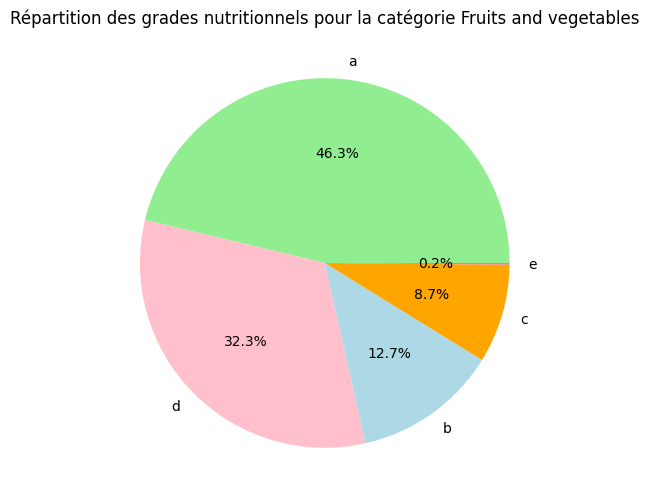

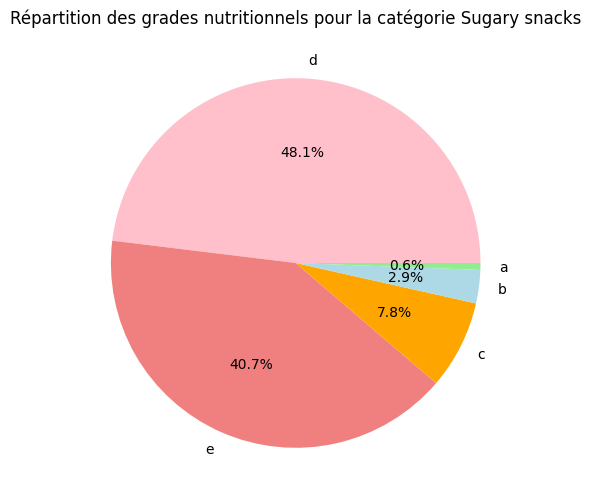

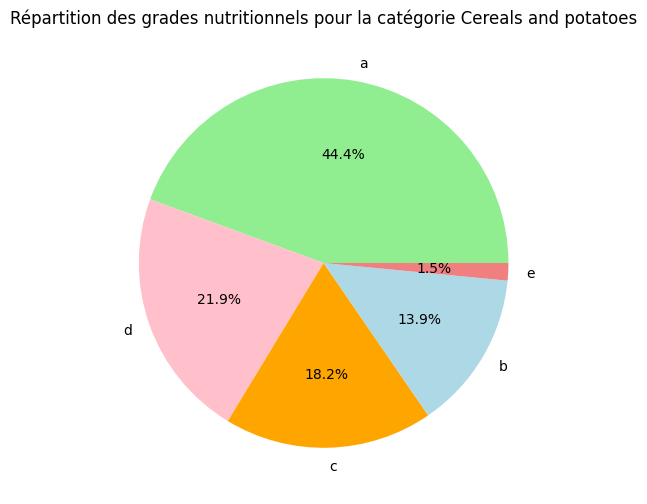

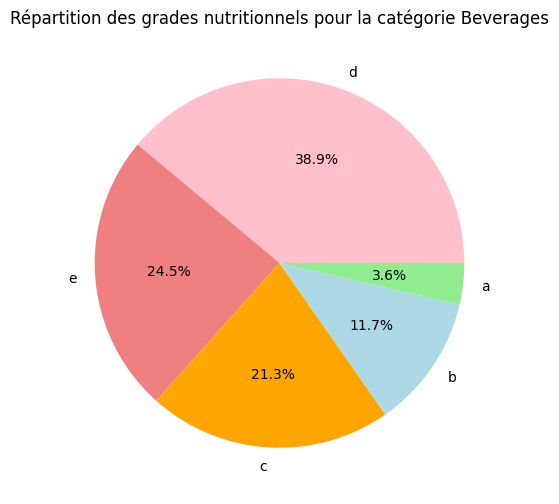

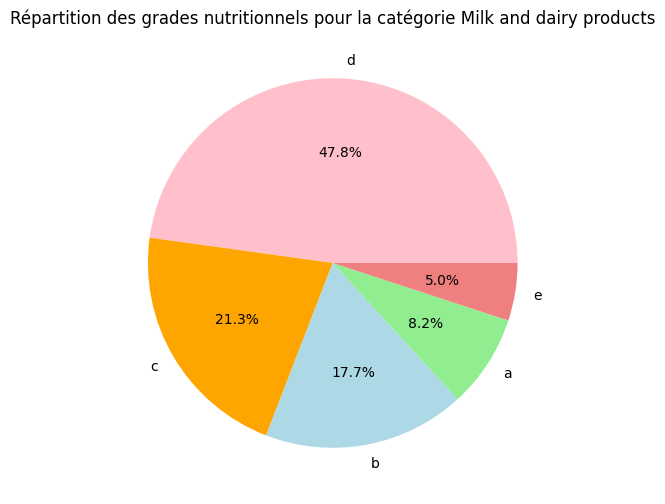

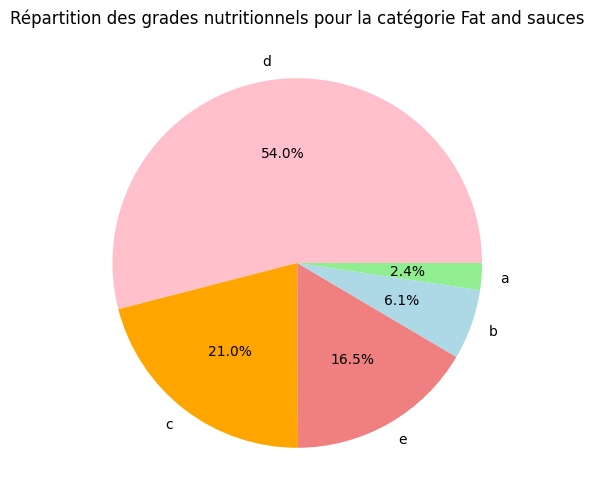

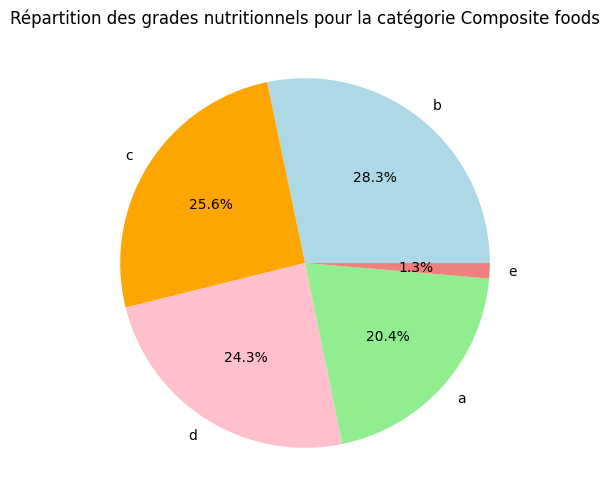

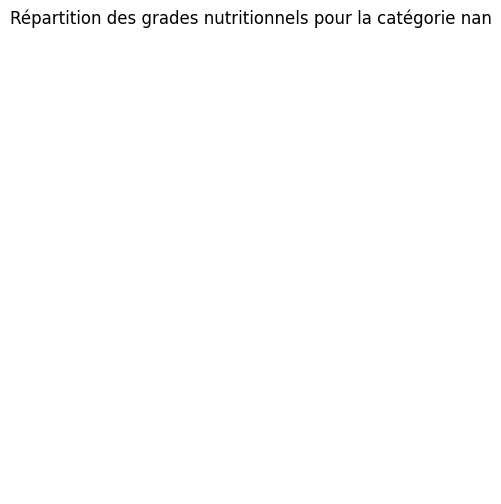

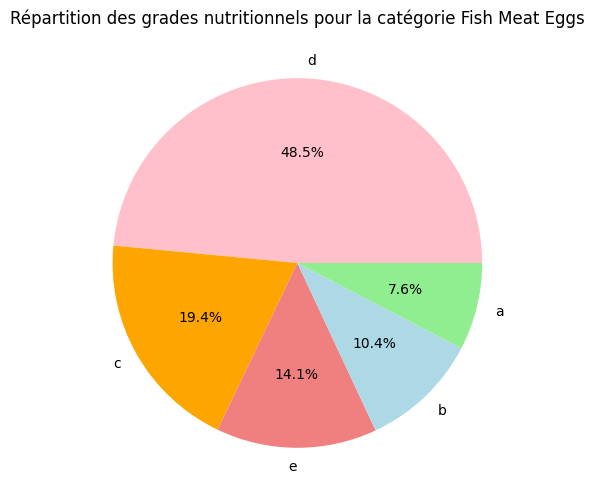

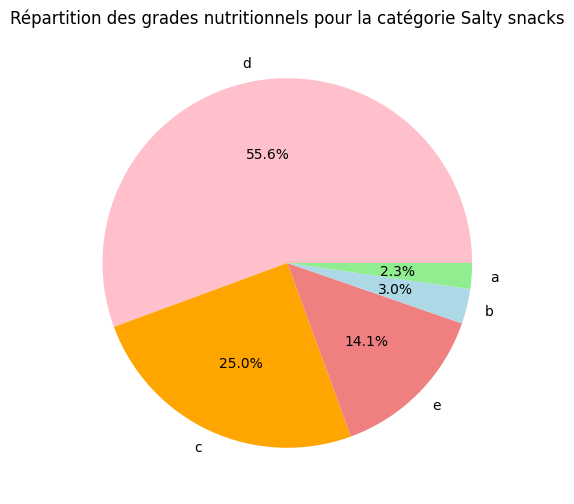

In [295]:
import matplotlib.pyplot as plt

# Sélectionner les colonnes pertinentes pour l'analyse
data = df_work2_imputed[['pnns_groups_1', 'nutrition_grade_fr']]

# Obtenir les catégories uniques de pnns_groups_1
categories = data['pnns_groups_1'].unique()

# Définir les couleurs pour chaque grade nutritionnel
colors = {'a': 'lightgreen', 'b': 'lightblue', 'c': 'orange', 'd': 'pink', 'e': 'lightcoral'}

# Parcourir les catégories et créer un pie chart pour chaque catégorie
for category in categories:
    # Filtrer les données pour la catégorie spécifique
    category_data = data[data['pnns_groups_1'] == category]
    
    # Compter le nombre d'occurrences de chaque grade nutritionnel dans cette catégorie
    grade_counts = category_data['nutrition_grade_fr'].value_counts()
    
    # Créer un pie chart pour la catégorie actuelle
    plt.figure(figsize=(6, 6))
    plt.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', colors=[colors[grade] for grade in grade_counts.index])
    plt.title(f"Répartition des grades nutritionnels pour la catégorie {category}")
    plt.show()


#### Etude de la distribution d'énergie par catégorie

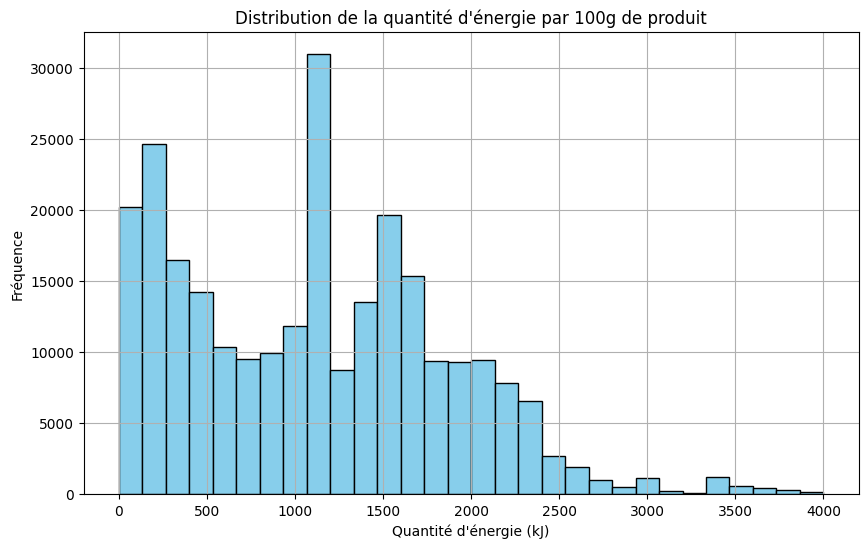

In [296]:
import matplotlib.pyplot as plt

# Sélectionner les données de la colonne 'energy_100g'
energy_data = df_work2_imputed['energy_100g']

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(energy_data, bins=30, color='skyblue', edgecolor='black') 
plt.xlabel('Quantité d\'énergie (kJ)')
plt.ylabel('Fréquence')
plt.title('Distribution de la quantité d\'énergie par 100g de produit')
plt.grid(True)
plt.show()


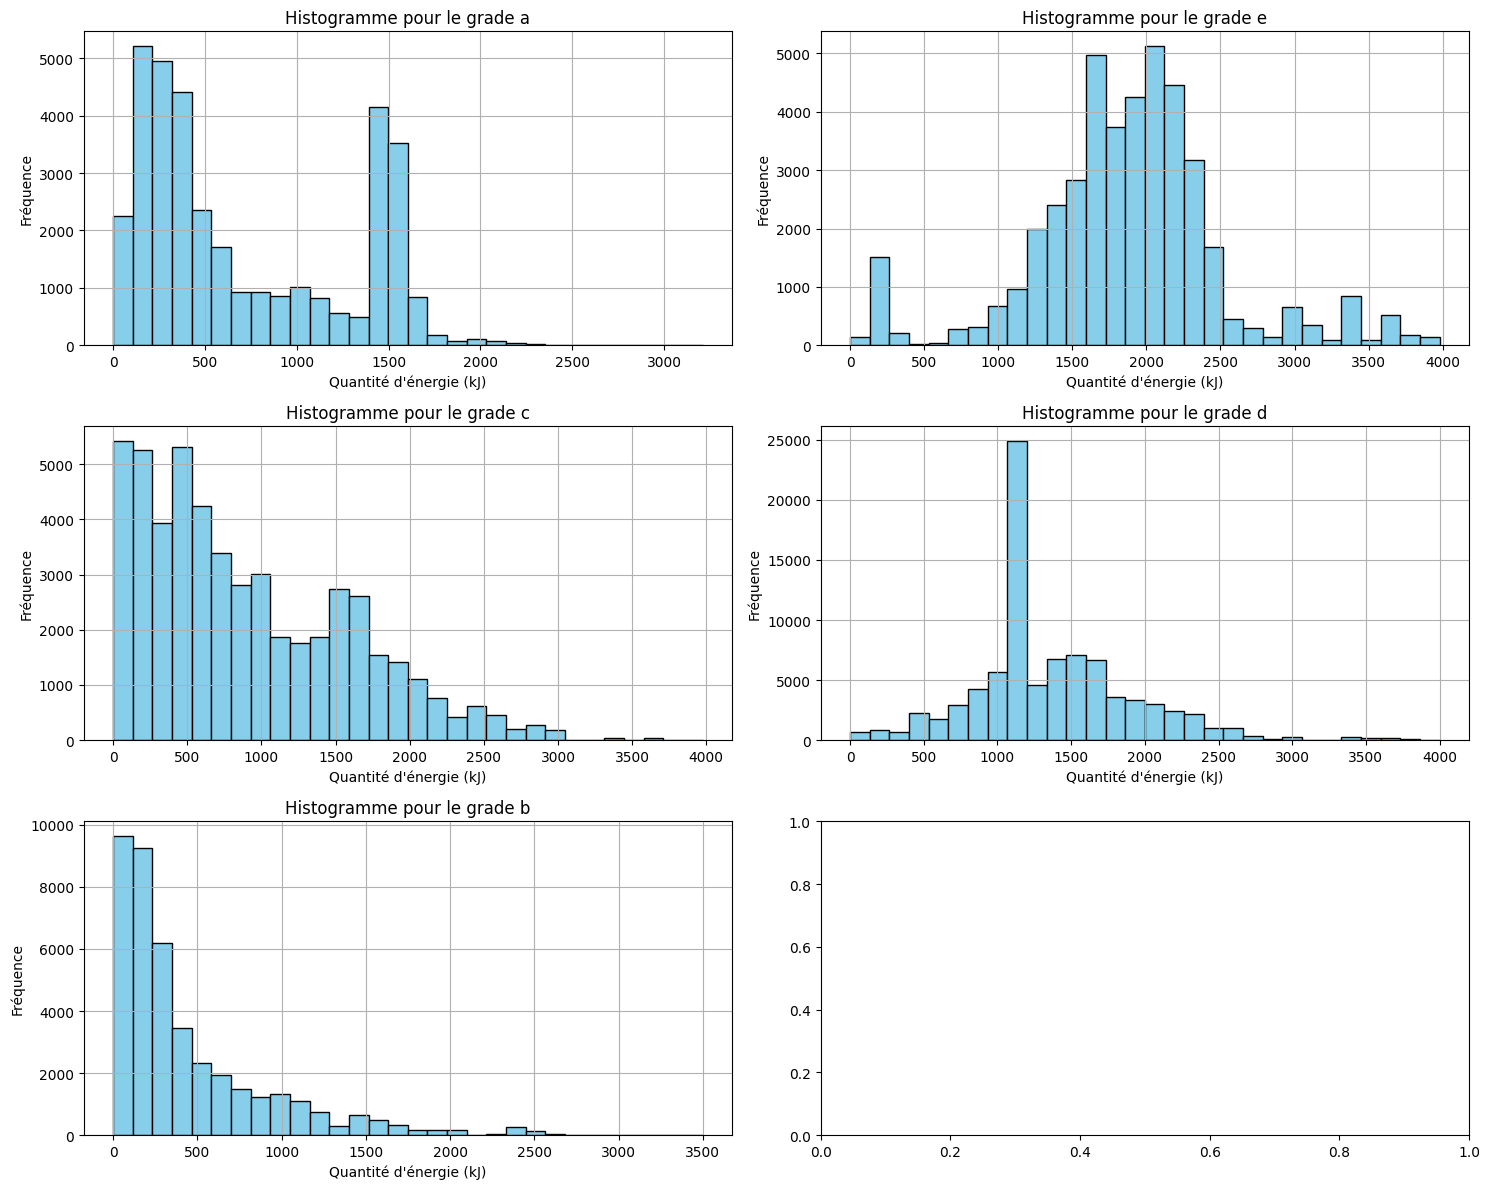

In [297]:
import matplotlib.pyplot as plt

# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Sélectionner les grades nutritionnels uniques
grades = df_work2_imputed['nutrition_grade_fr'].unique()

# Créer un histogramme pour chaque grade nutritionnel
for i, grade in enumerate(grades):
    # Sélectionner les données de la colonne 'energy_100g' pour le grade actuel
    energy_data = df_work2_imputed[df_work2_imputed['nutrition_grade_fr'] == grade]['energy_100g']
    
    # Calculer le numéro de subplot
    row = i // 2
    col = i % 2
    
    # Tracer l'histogramme pour le grade actuel
    axes[row, col].hist(energy_data, bins=30, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'Histogramme pour le grade {grade}')
    axes[row, col].set_xlabel('Quantité d\'énergie (kJ)')
    axes[row, col].set_ylabel('Fréquence')
    axes[row, col].grid(True)

# Ajuster automatiquement les sous-plots pour éviter les superpositions
plt.tight_layout()
plt.show()


#### Etude de features corrélées

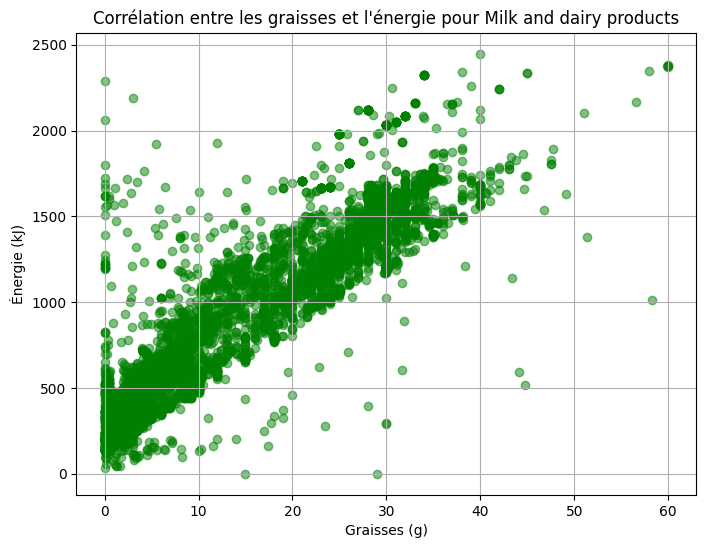

In [298]:
import matplotlib.pyplot as plt

# Filtrer les données pour la catégorie 'Milk and dairy products'
milk_dairy_data = df_work2_imputed[df_work2_imputed['pnns_groups_1'] == 'Milk and dairy products']

# Sélectionner les données des colonnes 'fat_100g' et 'energy_100g' pour cette catégorie
fat_data = milk_dairy_data['fat_100g']
energy_data = milk_dairy_data['energy_100g']

# Tracer le scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(fat_data, energy_data, color='green', alpha=0.5)
plt.title('Corrélation entre les graisses et l\'énergie pour Milk and dairy products')
plt.xlabel('Graisses (g)')
plt.ylabel('Énergie (kJ)')
plt.grid(True)
plt.show()


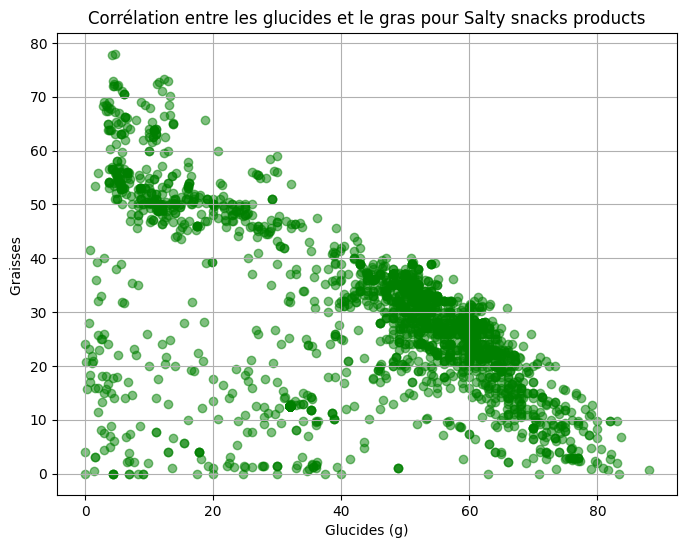

In [299]:
import matplotlib.pyplot as plt

# Filtrer les données pour la catégorie 'Milk and dairy products'
milk_dairy_data = df_work2_imputed[df_work2_imputed['pnns_groups_1'] == 'Salty snacks']

# Sélectionner les données des colonnes 'fat_100g' et 'energy_100g' pour cette catégorie
fat_data = milk_dairy_data['carbohydrates_100g']
energy_data = milk_dairy_data['fat_100g']

# Tracer le scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(fat_data, energy_data, color='green', alpha=0.5)
plt.title('Corrélation entre les glucides et le gras pour Salty snacks products')
plt.xlabel('Glucides (g)')
plt.ylabel('Graisses ')
plt.grid(True)
plt.show()


# 5 - Analyse multi-variée

**Objectifs :**

 - Obtenir une compréhension approfondie des relations complexes entre plusieurs features de l'ensemble des données
 - Identification des interactions significatives entre variables

In [300]:
df_work2_imputed

product_name  \
0                     Piña &quot;Agropen&quot;   
1                         Cookies Nougat' Choc   
2       Burger Gourmand aux graines & céréales   
3                           Sirop de grenadine   
4                   Longue Conservation nature   
...                                        ...   
258048        Le Haché 100 % canard assaisonné   
258049                                 Endives   
258050                       Pur jus de pommes   
258051                          Basilic Grande   
258052                          Miel de fleurs   

                                        brands          pnns_groups_1  \
0       Agropen,//Propiedad de://,Agropen S.A.  Fruits and vegetables   
1                                     Chabrior          Sugary snacks   
2                               Harrys,Barilla   Cereals and potatoes   
3                                      Paquito              Beverages   
4                                       Harrys   Cereals and potatoes   
...                                        ...                    ...   
258048                          Les Thomasines         Fish Meat Eggs   
258049                                 En'Diva  Fruits and vegetables   
258050                     Le petit producteur              Beverages   
258051                               Pronatura                    NaN   
258052                            Leader Price          Sugary snacks   

       nutrition_grade_fr  energy_100g  proteins_100g  salt_100g  sodium_100g  \
0                       a   209.000000       1.000000   0.000000     0.000000   
1                       e  2117.000000       5.800000   1.219200     0.480000   
2                       a  1118.000000      10.300000   1.099820     0.433000   
3                       e  1376.000000       1.600000   0.002540     0.001000   
4                       c  1201.000000       9.500000   1.328420     0.523000   
...                   ...          ...            ...        ...          ...   
258048                  d  1118.079247       7.078799   1.605682     0.632263   
258049                  d  1118.079247       7.078799   1.605682     0.632263   
258050                  d  1118.079247       7.078799   1.605682     0.632263   
258051                  d  1118.079247       7.078799   1.605682     0.632263   
258052                  d  1118.079247       7.078799   1.605682     0.632263   

        sugars_100g  carbohydrates_100g   fat_100g  saturated-fat_100g  \
0         10.000000           14.000000   0.000000            0.000000   
1         27.800000           61.100000  26.000000           13.100000   
2          2.800000           44.900000   3.700000            0.600000   
3         77.600000           77.600000   0.800000            0.100000   
4          6.000000           51.800000   4.100000            2.400000   
...             ...                 ...        ...                 ...   
258048    15.733676           32.025061  12.537453            5.083836   
258049    15.733676           32.025061  12.537453            5.083836   
258050    15.733676           32.025061  12.537453            5.083836   
258051    15.733676           32.025061  12.537453            5.083836   
258052    15.733676           32.025061  12.537453            5.083836   

        fiber_100g  nutrition-score-fr_100g  
0         4.000000                -8.000000  
1         2.200000                24.000000  
2         5.300000                -3.000000  
3         0.500000                20.000000  
4         2.400000                 8.000000  
...            ...                      ...  
258048    2.823858                 9.074013  
258049    2.823858                 9.074013  
258050    2.823858                 9.074013  
258051    2.823858                 9.074013  
258052    2.823858                 9.074013  

[258053 rows x 14 columns]

### Analyse en Composante Principale

#### ACP de tous les individus

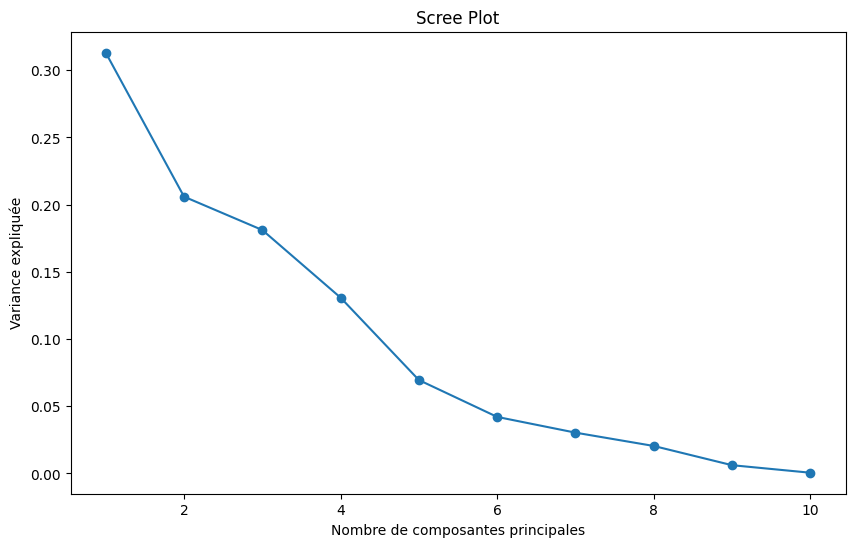

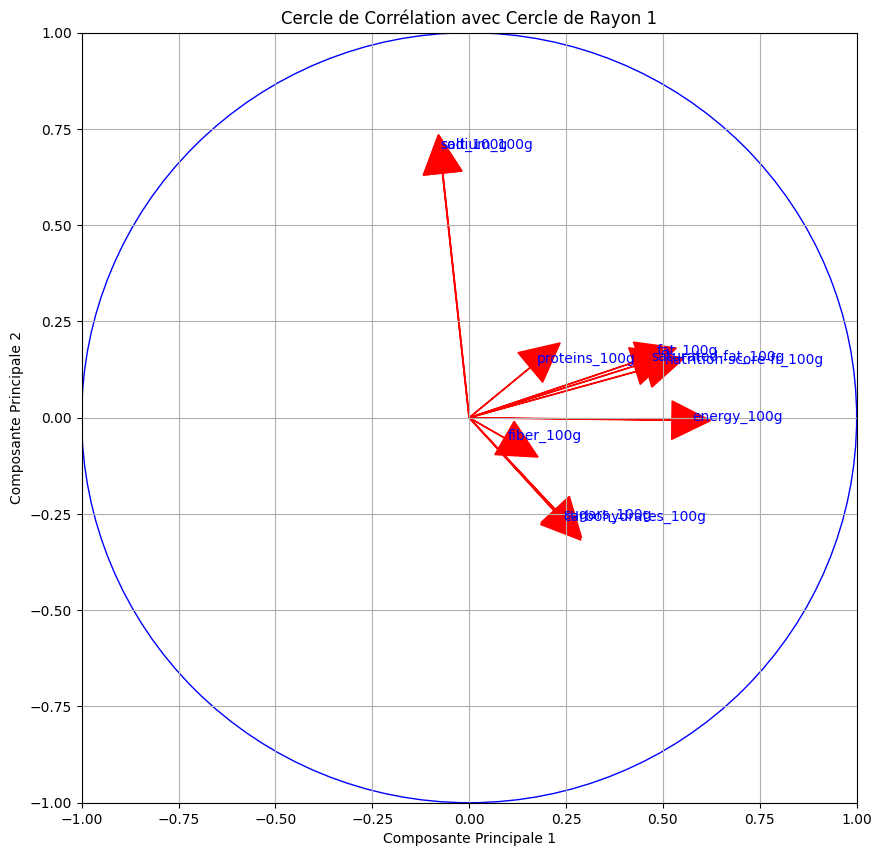

In [301]:


# Sélectionner les colonnes quantitatives
quantitative_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                        'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                        'fiber_100g', 'nutrition-score-fr_100g']

# Créer un nouveau dataframe contenant uniquement les colonnes quantitatives
df_quantitative = df_work2_imputed[quantitative_columns]

# Normaliser les valeurs quantitatives
scaler = StandardScaler()
df_quantitative_scaled = scaler.fit_transform(df_quantitative)

# Créer l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données quantitatives
pca.fit(df_quantitative_scaled)

# Récupérer les composantes principales
components = pca.components_

# Récupérer les valeurs propres
explained_variance = pca.explained_variance_

# Récupérer le pourcentage de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Tracer le scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot')
plt.show()

# Tracer le cercle de corrélation avec un cercle de rayon 1
pc1 = components[0]
pc2 = components[1]

fig, ax = plt.subplots(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pc1, pc2)):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='r', ec='r')
    # Réduire la taille des noms des features pour éviter la superposition
    ax.text(x * 1.1, y * 1.1, quantitative_columns[i], color='b')

# Ajouter le cercle de rayon 1
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid()
plt.title('Cercle de Corrélation avec Cercle de Rayon 1')
plt.show()


In [302]:
# Supposons que pca est l'objet PCA que tu as déjà ajusté sur tes données

# Récupérer les composantes principales
components = pca.components_

# Récupérer les noms des variables
quantitative_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                        'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                        'fiber_100g', 'nutrition-score-fr_100g']

# Afficher les coordonnées des variables sur les composantes principales
for i, component in enumerate(components):
    print(f"Composante Principale {i+1}:")
    for j, variable in enumerate(quantitative_columns):
        print(f"{variable}: {component[j]}")
    print("\n")


Composante Principale 1:
energy_100g: 0.5231988462933741
proteins_100g: 0.157794037178557
salt_100g: -0.06871633980028993
sodium_100g: -0.0681722723485175
sugars_100g: 0.22197862913131933
carbohydrates_100g: 0.2211924159266282
fat_100g: 0.4399856763959082
saturated-fat_100g: 0.42670599895079725
fiber_100g: 0.09119544444263496
nutrition-score-fr_100g: 0.45805240342097797


Composante Principale 2:
energy_100g: -0.006323331473520785
proteins_100g: 0.13053957214968268
salt_100g: 0.6354131593302379
sodium_100g: 0.635459944872386
sugars_100g: -0.23813848970564705
carbohydrates_100g: -0.2437495052652322
fat_100g: 0.1490362921549803
saturated-fat_100g: 0.13419476776610118
fiber_100g: -0.05244729918728747
nutrition-score-fr_100g: 0.12753696770476589


Composante Principale 3:
energy_100g: 0.022216901818751314
proteins_100g: -0.3485855763351593
salt_100g: 0.27753803705793356
sodium_100g: 0.27769395916948003
sugars_100g: 0.5503087516948804
carbohydrates_100g: 0.514119074628374
fat_100g: -0.29315

Composante Principale 1 semble être fortement influencée par les nutriments généraux tels que l'énergie, les protéines, les lipides et les glucides. La nutrition-score-fr_100g (score nutritionnel) est également assez bien corrélée avec cette composante.

Composante Principale 2 semble être influencée par la teneur en sel et en sodium, avec des corrélations positives relativement fortes.

Composante Principale 3 semble être influencée par la teneur en sucre et en glucides, avec des corrélations positives avec ces variables.

Composante Principale 4 semble être influencée par la teneur en fibres, avec une forte corrélation positive.

Composante Principale 5 semble être influencée négativement par la teneur en protéines et positivement par la teneur en fibres.

Composante Principale 6 semble être influencée par la teneur en graisses saturées et non saturées, ainsi que par la teneur en fibres.

Composante Principale 7 semble être influencée par la teneur en graisses saturées, en glucides et en énergie.

Composante Principale 8 semble être influencée par la nutrition-score-fr_100g (score nutritionnel), avec une corrélation positive relativement forte.

Composante Principale 9 semble être influencée par la teneur en énergie et en graisses.

Composante Principale 10 semble être principalement influencée par la teneur en sel et en sodium.

#### ACP des individus de la catégorie Milk and dairy products

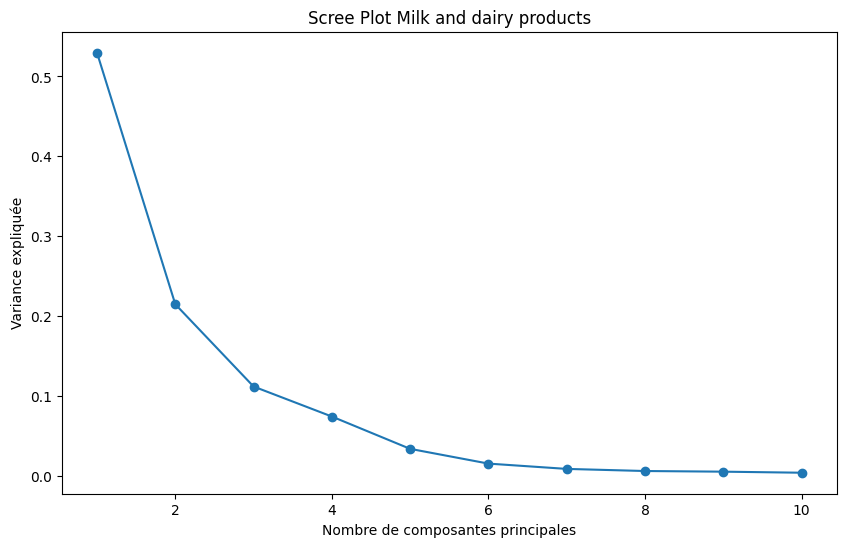

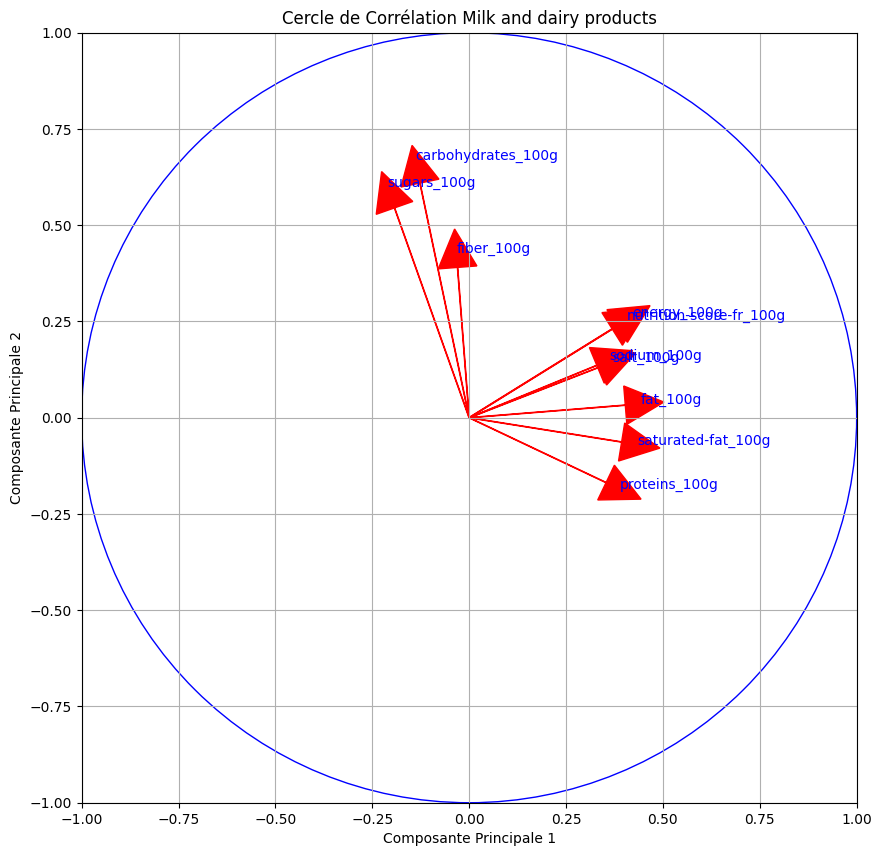

In [303]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Sélectionner les colonnes quantitatives
quantitative_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                        'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                        'fiber_100g', 'nutrition-score-fr_100g']



# Créer un nouveau dataframe contenant uniquement les colonnes quantitatives
df_quantitative = df_work2_imputed[df_work2_imputed['pnns_groups_1']=='Milk and dairy products'][quantitative_columns]

# Normaliser les valeurs quantitatives
scaler = StandardScaler()
df_quantitative_scaled = scaler.fit_transform(df_quantitative)

# Créer l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données quantitatives
pca.fit(df_quantitative_scaled)

# Récupérer les composantes principales
components = pca.components_

# Récupérer les valeurs propres
explained_variance = pca.explained_variance_

# Récupérer le pourcentage de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Tracer le scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot Milk and dairy products')
plt.show()

# Tracer le cercle de corrélation avec un cercle de rayon 1
pc1 = components[0]
pc2 = components[1]

fig, ax = plt.subplots(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pc1, pc2)):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='r', ec='r')
    # Réduire la taille des noms des features pour éviter la superposition
    ax.text(x * 1.1, y * 1.1, quantitative_columns[i], color='b')

# Ajouter le cercle de rayon 1
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid()
plt.title('Cercle de Corrélation Milk and dairy products')
plt.show()


#### ACP sur individus catégorie Beverages

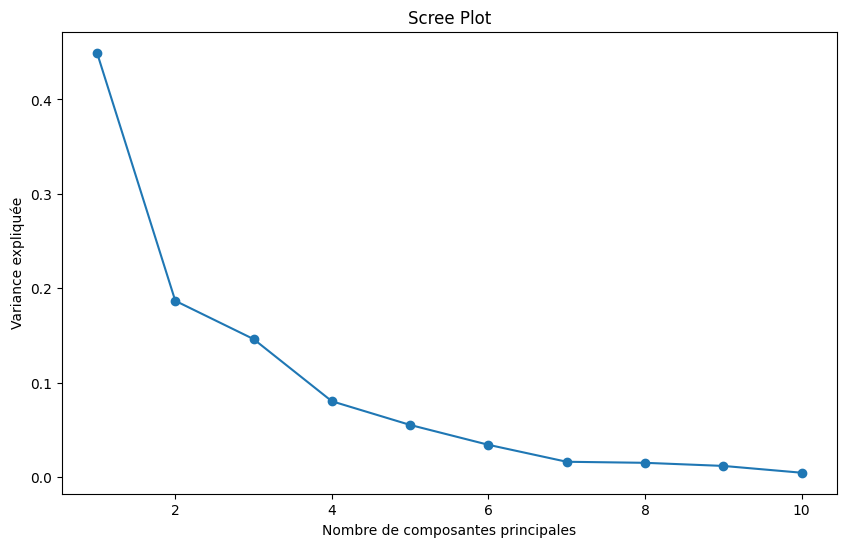

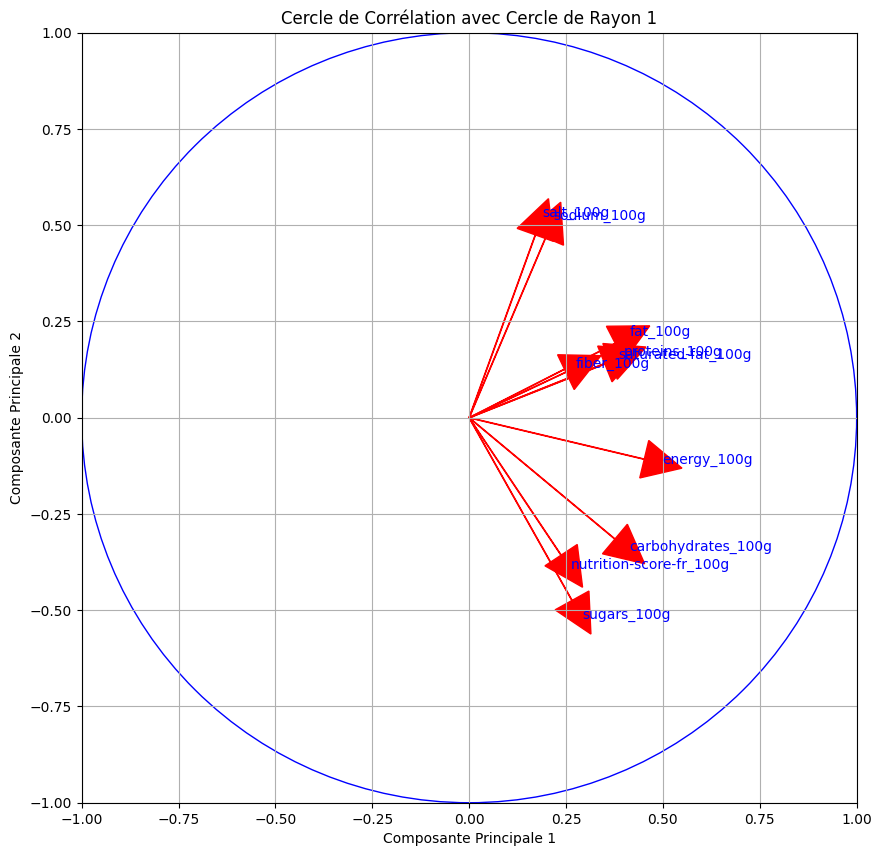

In [304]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Sélectionner les colonnes quantitatives
quantitative_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                        'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                        'fiber_100g', 'nutrition-score-fr_100g']



# Créer un nouveau dataframe contenant uniquement les colonnes quantitatives
df_quantitative = df_work2_imputed[df_work2_imputed['pnns_groups_1']=='Beverages'][quantitative_columns]

# Normaliser les valeurs quantitatives
scaler = StandardScaler()
df_quantitative_scaled = scaler.fit_transform(df_quantitative)

# Créer l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données quantitatives
pca.fit(df_quantitative_scaled)

# Récupérer les composantes principales
components = pca.components_

# Récupérer les valeurs propres
explained_variance = pca.explained_variance_

# Récupérer le pourcentage de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Tracer le scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot')
plt.show()

# Tracer le cercle de corrélation avec un cercle de rayon 1
pc1 = components[0]
pc2 = components[1]

fig, ax = plt.subplots(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pc1, pc2)):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='r', ec='r')
    # Réduire la taille des noms des features pour éviter la superposition
    ax.text(x * 1.1, y * 1.1, quantitative_columns[i], color='b')

# Ajouter le cercle de rayon 1
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid()
plt.title('Cercle de Corrélation avec Cercle de Rayon 1')
plt.show()


#### ACP sur individus groupe Fruits and vegetables

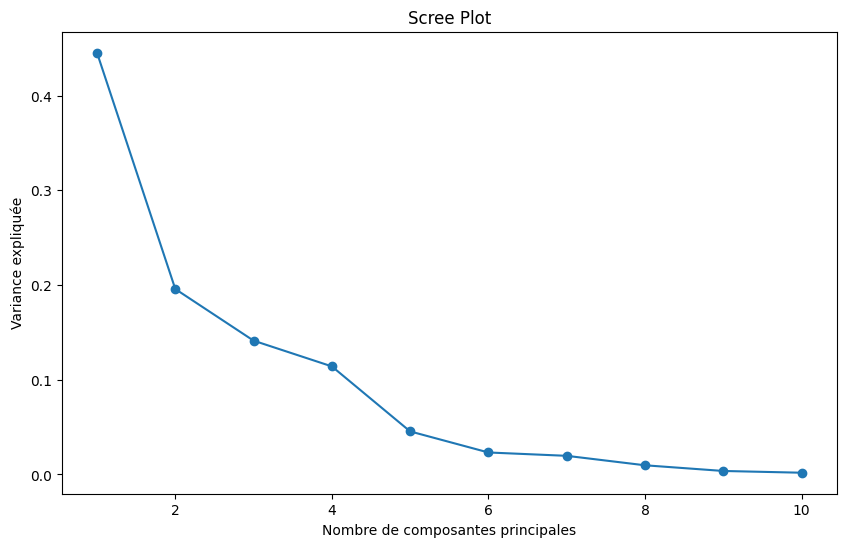

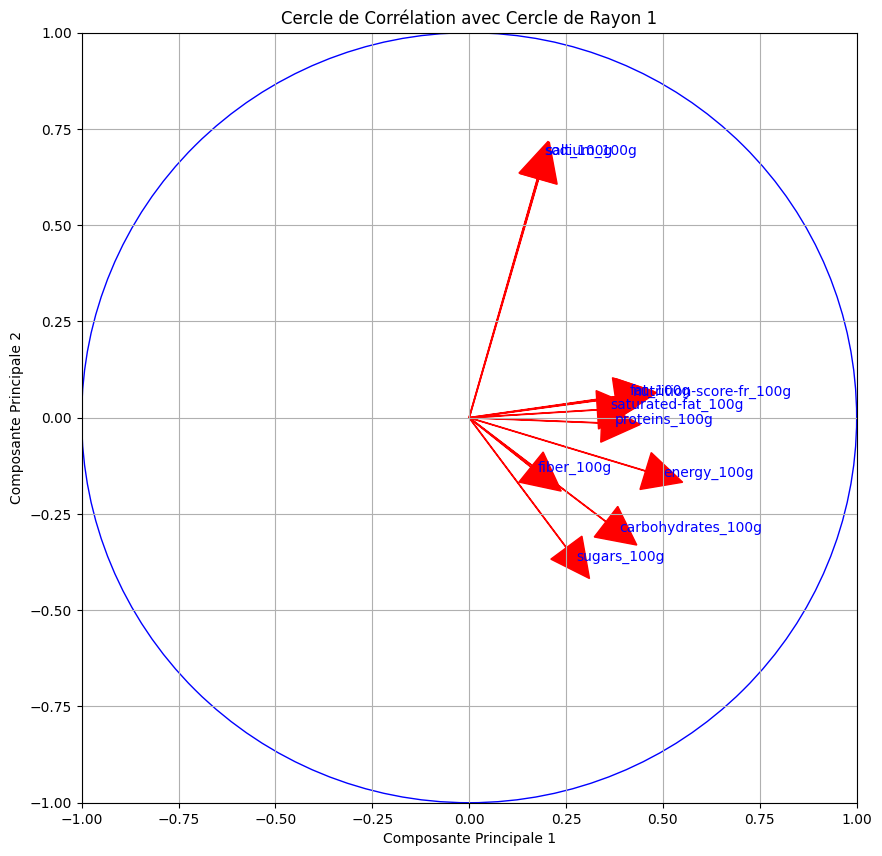

In [305]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Sélectionner les colonnes quantitatives
quantitative_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                        'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
                        'fiber_100g', 'nutrition-score-fr_100g']



# Créer un nouveau dataframe contenant uniquement les colonnes quantitatives
df_quantitative = df_work2_imputed[df_work2_imputed['pnns_groups_1']=='Fruits and vegetables'][quantitative_columns]

# Normaliser les valeurs quantitatives
scaler = StandardScaler()
df_quantitative_scaled = scaler.fit_transform(df_quantitative)

# Créer l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données quantitatives
pca.fit(df_quantitative_scaled)

# Récupérer les composantes principales
components = pca.components_

# Récupérer les valeurs propres
explained_variance = pca.explained_variance_

# Récupérer le pourcentage de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Tracer le scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot')
plt.show()

# Tracer le cercle de corrélation avec un cercle de rayon 1
pc1 = components[0]
pc2 = components[1]

fig, ax = plt.subplots(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pc1, pc2)):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='r', ec='r')
    # Réduire la taille des noms des features pour éviter la superposition
    ax.text(x * 1.1, y * 1.1, quantitative_columns[i], color='b')

# Ajouter le cercle de rayon 1
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid()
plt.title('Cercle de Corrélation avec Cercle de Rayon 1')
plt.show()


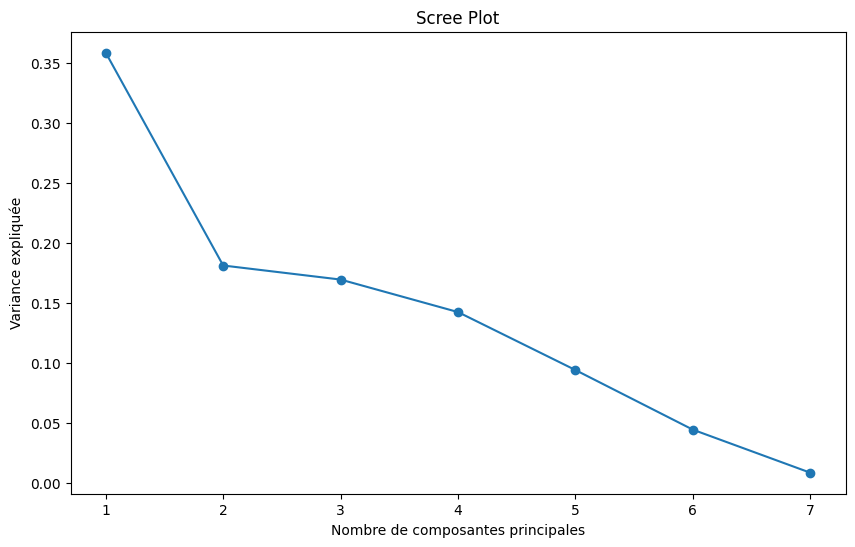

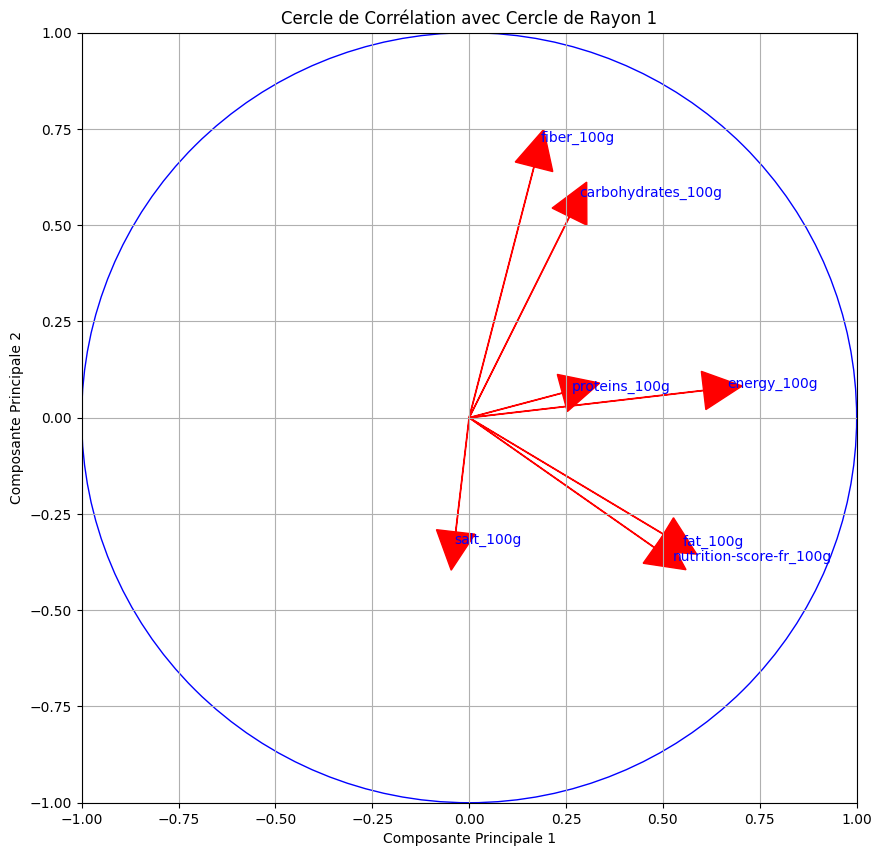

In [306]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Sélectionner les colonnes quantitatives
quantitative_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g','fiber_100g', 'nutrition-score-fr_100g']



# Créer un nouveau dataframe contenant uniquement les colonnes quantitatives
df_quantitative = df_work2_imputed[quantitative_columns]

# Normaliser les valeurs quantitatives
scaler = StandardScaler()
df_quantitative_scaled = scaler.fit_transform(df_quantitative)

# Créer l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données quantitatives
pca.fit(df_quantitative_scaled)

# Récupérer les composantes principales
components = pca.components_

# Récupérer les valeurs propres
explained_variance = pca.explained_variance_

# Récupérer le pourcentage de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Tracer le scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot')
plt.show()

# Tracer le cercle de corrélation avec un cercle de rayon 1
pc1 = components[0]
pc2 = components[1]

fig, ax = plt.subplots(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pc1, pc2)):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='r', ec='r')
    # Réduire la taille des noms des features pour éviter la superposition
    ax.text(x * 1.1, y * 1.1, quantitative_columns[i], color='b')



# Ajouter le cercle de rayon 1
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid()
plt.title('Cercle de Corrélation avec Cercle de Rayon 1')
plt.show()


### ANalysis Of VAriance - ANOVA

In [307]:
df_work2_imputed.columns

Index(['product_name', 'brands', 'pnns_groups_1', 'nutrition_grade_fr',
       'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g',
       'fiber_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [308]:
import pandas as pd
from scipy.stats import f_oneway

# Liste des variables nutritionnelles
nutritional_variables = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g']

# Parcours des variables nutritionnelles
for variable in nutritional_variables:
    # ANOVA
    result = f_oneway(*[group[variable].dropna() for name, group in df_work2_imputed.groupby('nutrition_grade_fr')])
    
    # Affichage des résultats
    print(f"ANOVA for {variable}:")
    print("F-statistic:", result.statistic)
    print("p-value:", result.pvalue)
    print("------------------------")



ANOVA for energy_100g:
F-statistic: 40593.76178260351
p-value: 0.0
------------------------
ANOVA for proteins_100g:
F-statistic: 2642.4524791807794
p-value: 0.0
------------------------
ANOVA for salt_100g:
F-statistic: 1631.667867149198
p-value: 0.0
------------------------
ANOVA for sodium_100g:
F-statistic: 1616.1676663900823
p-value: 0.0
------------------------
ANOVA for sugars_100g:
F-statistic: 14605.137473480041
p-value: 0.0
------------------------
ANOVA for carbohydrates_100g:
F-statistic: 6466.289722246683
p-value: 0.0
------------------------
ANOVA for fat_100g:
F-statistic: 25170.786683899285
p-value: 0.0
------------------------
ANOVA for saturated-fat_100g:
F-statistic: 42757.93475239021
p-value: 0.0
------------------------
ANOVA for fiber_100g:
F-statistic: 3824.1605463401443
p-value: 0.0
------------------------


Les résultats de l'ANOVA montrent que pour chaque variable nutritionnelle ('energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g'), la p-value est extrêmement faible (0.0). Cela signifie qu'il existe des différences significatives entre les différentes catégories de nutriscore pour chacune de ces variables nutritionnelles.

En d'autres termes, les contenus nutritionnels des aliments, tels que l'énergie, les protéines, le sel, le sucre, etc., varient considérablement en fonction du nutriscore attribué à chaque aliment.

# Annexes

/tmp/ipykernel_24391/3628126030.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_counts = df.resample('M', on='created_datetime').size()


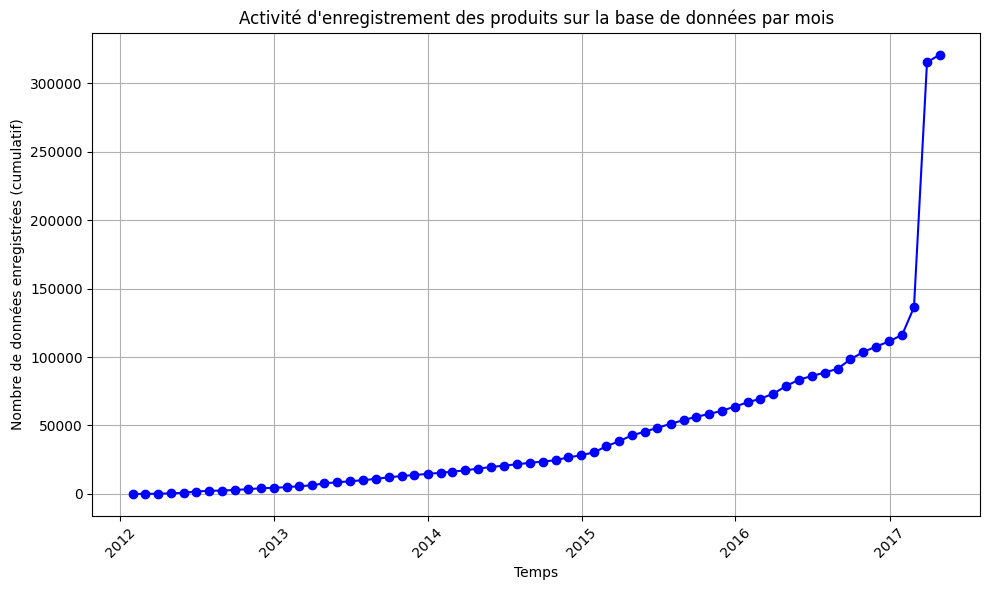

In [309]:
# Supprimer les lignes avec des valeurs non conformes dans la colonne 'created_datetime'
df = df.dropna(subset=['created_datetime'])

# Convertir la colonne 'created_datetime' en datetime
df['created_datetime'] = pd.to_datetime(df['created_datetime'], errors='coerce')

# Agréger les données par semaine et compter le nombre de données enregistrées pour chaque semaine
weekly_counts = df.resample('M', on='created_datetime').size()

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(weekly_counts.index, weekly_counts.values.cumsum(), color='blue', marker='o', linestyle='-')
plt.xlabel('Temps')
plt.ylabel('Nombre de données enregistrées (cumulatif)')
plt.title('Activité d\'enregistrement des produits sur la base de données par mois')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [310]:
df

code                                                url  \
0                3087  http://world-fr.openfoodfacts.org/produit/0000...   
1                4530  http://world-fr.openfoodfacts.org/produit/0000...   
2                4559  http://world-fr.openfoodfacts.org/produit/0000...   
3               16087  http://world-fr.openfoodfacts.org/produit/0000...   
4               16094  http://world-fr.openfoodfacts.org/produit/0000...   
...               ...                                                ...   
320767  9948282780603  http://world-fr.openfoodfacts.org/produit/9948...   
320768       99567453  http://world-fr.openfoodfacts.org/produit/9956...   
320769  9970229501521  http://world-fr.openfoodfacts.org/produit/9970...   
320770  9980282863788  http://world-fr.openfoodfacts.org/produit/9980...   
320771   999990026839  http://world-fr.openfoodfacts.org/produit/9999...   

                           creator   created_t          created_datetime  \
0       openfoodfacts-contributors  1474103866 2016-09-17 09:17:46+00:00   
1                  usda-ndb-import  1489069957 2017-03-09 14:32:37+00:00   
2                  usda-ndb-import  1489069957 2017-03-09 14:32:37+00:00   
3                  usda-ndb-import  1489055731 2017-03-09 10:35:31+00:00   
4                  usda-ndb-import  1489055653 2017-03-09 10:34:13+00:00   
...                            ...         ...                       ...   
320767  openfoodfacts-contributors  1490631299 2017-03-27 16:14:59+00:00   
320768             usda-ndb-import  1489059076 2017-03-09 11:31:16+00:00   
320769                      tomato  1422099377 2015-01-24 11:36:17+00:00   
320770  openfoodfacts-contributors  1492340089 2017-04-16 10:54:49+00:00   
320771             usda-ndb-import  1489072709 2017-03-09 15:18:29+00:00   

       last_modified_t last_modified_datetime  \
0           1474103893   2016-09-17T09:18:13Z   
1           1489069957   2017-03-09T14:32:37Z   
2           1489069957   2017-03-09T14:32:37Z   
3           1489055731   2017-03-09T10:35:31Z   
4           1489055653   2017-03-09T10:34:13Z   
...                ...                    ...   
320767      1491244498   2017-04-03T18:34:58Z   
320768      1491244499   2017-04-03T18:34:59Z   
320769      1491244499   2017-04-03T18:34:59Z   
320770      1492340089   2017-04-16T10:54:49Z   
320771      1491244499   2017-04-03T18:34:59Z   

                                             product_name  \
0                                      Farine de blé noir   
1                          Banana Chips Sweetened (Whole)   
2                                                 Peanuts   
3                                  Organic Salted Nut Mix   
4                                         Organic Polenta   
...                                                   ...   
320767                                  Tomato & ricotta    
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...   
320769                                            乐吧泡菜味薯片   
320770                           Tomates aux Vermicelles    
320771                    Sugar Free Drink Mix, Peach Tea   

                           generic_name quantity  ...  \
0                                   NaN      1kg  ...   
1                                   NaN      NaN  ...   
2                                   NaN      NaN  ...   
3                                   NaN      NaN  ...   
4                                   NaN      NaN  ...   
...                                 ...      ...  ...   
320767                              NaN        1  ...   
320768                              NaN      NaN  ...   
320769  Leba pickle flavor potato chips     50 g  ...   
320770                              NaN      67g  ...   
320771                              NaN      NaN  ...   

       fruits-vegetables-nuts_100g collagen-meat-protein-ratio_100g  \
0                              NaN                              NaN   
1                              NaN        

In [311]:
len(df.columns)


163